In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [2]:
from keras import backend as K

if 'tensorflow' == K.backend():
  import tensorflow as tf
  from keras.backend.tensorflow_backend import set_session
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  config.gpu_options.visible_device_list = "0"
  set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
# PyDrive Wrapper installieren, Bibliotheken importieren.
# Muß nur einmal pro Notebook durchgeführt werden
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Ältere Version von Matplotlib installieren, da die neueste Version Bugs enthält
!pip install matplotlib==3.0.2
import matplotlib
from matplotlib import pyplot as plt
matplotlib.__version__

'3.0.2'

In [5]:
# choose a local (colab) directory to store the data.
import os
local_root_path = os.path.expanduser("~/data/data")
try:
  os.makedirs(local_root_path, exist_ok=True)    
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # If it is a directory then, create the dicrectory and upload the file inside it
    if f['mimeType']=='application/vnd.google-apps.folder': 
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path, exist_ok=True)
      print('creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('{} files were uploaded in {}'.format(counter, destination))
ListFolder("1E4Oit_TJ9ayeobjtiCS1NsGJ4Pz9s7hI", local_root_path)

creating directory /root/data/data/data
creating directory /root/data/data/data/fashion
2 files were uploaded in /root/data/data/data/fashion
creating directory /root/data/data/data/GTSRB
2 files were uploaded in /root/data/data/data/GTSRB
0 files were uploaded in /root/data/data/data
creating directory /root/data/data/300 - CNN
11 files were uploaded in /root/data/data/300 - CNN
0 files were uploaded in /root/data/data


In [0]:
import glob
import h5py
import gzip

import time
import timeit
from timeit import default_timer as timer

from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

from keras.utils import np_utils,to_categorical

#from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization, Dense, Flatten
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#from matplotlib import pyplot as plt
#%matplotlib inline

import numpy as np
from numpy import mean, std

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import cohen_kappa_score, precision_recall_fscore_support, auc
#from sklearn.metrics import roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import LabelBinarizer
from skimage.exposure import equalize_hist

import seaborn as sns
import pickle as pkl

import csv
#from imblearn.pipeline import Pipeline

from skimage import transform, color, exposure

from sklearn.utils import shuffle

from google.colab import files


In [0]:

'''
Modell, welches mit optimierten Hyperparametern (Dropoutrate, Lernrate, SpatialDropout?) 
unter Verwendung von EarlyStopping trainiert wird.
conv_dropout = Dropoutrate der Convolutional Layer im Bereich: [0.2, 0.3, 0.4]
learn_rate = Lernrate  im Bereich: [0.0001, 0.001, 0.01]
spatial_dropout=False, d.h. kein SpatialDropout2D Layer, sondern normaler Dropout Layer
'''
def model_create(conv_dropout=0.2, learn_rate=0.001, spatial_dropout=False):
  model = Sequential()    
  filter_counter = 32
  model.add(Conv2D(filter_counter, kernel_size=(3,3), input_shape=(48,48,3),padding='same'))
  model.add(BatchNormalization())
  model.add(ELU(alpha=1.0))
  model.add(Conv2D(filter_counter, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(ELU(alpha=1.0))
  model.add(MaxPooling2D(pool_size=(2,2)))
  if spatial_dropout==True:
    model.add(SpatialDropout2D(conv_dropout))
  if spatial_dropout==False:
    model.add(Dropout(conv_dropout))
  for i in range(0, 2):
    filter_counter = filter_counter*2
    model.add(Conv2D(filter_counter, kernel_size=(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    model.add(Conv2D(filter_counter, kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if spatial_dropout==True:
      model.add(SpatialDropout2D(conv_dropout))
    if spatial_dropout==False:
      model.add(Dropout(conv_dropout))
        
  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(ELU(alpha=1.0))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  optimizer = Adam(lr=learn_rate)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
  #model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
  print("Modell wurde erzeugt")
  return model





'''
Model mit Data Augmentation trainieren
'''
def train_model_es_with_DA(X, y, X_test, y_test, conv_dropout, learn_rate, spatial_dropout, number, dl):  
  model = model_create(conv_dropout, learn_rate, spatial_dropout)
      
  y = np.argmax(y, axis=1)
  
  y_test = np.argmax(y_test, axis=1)
  class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
  class_weights = dict(enumerate(class_weights))
  # ImageDataGenerator initialisieren
  train_gen = gen_Image_data_A()
  test_gen = ImageDataGenerator()
  train_samples = train_gen.flow(X, y, batch_size=32)
  test_samples = test_gen.flow(X_test, y_test, batch_size=32)
  start = time.time()
  start2 = time.process_time()
  start3 = time.perf_counter()
  #print("Training startet")
  history = model.fit_generator(train_samples, steps_per_epoch = np.ceil(39209/32), 
                                class_weight=class_weights, epochs=50, verbose=1,
                                validation_data = (test_samples), validation_steps=np.ceil(12630/32))
  
  cnn_train_time = time.time()-start
  cnn_train_time2 = time.process_time()-start2
  cnn_train_time3 = time.perf_counter()-start3
  # Trainingsdaten speichern
  time_list = []
  time_list.append([cnn_train_time, cnn_train_time2, cnn_train_time3])
  save_as_csv(time_list, str(dl) + "._DL_"+str(number)+"_Trainingszeiten_ES.csv")
  print("Trainingszeit beträgt {0:2f} Minuten".format(cnn_train_time/60.0))
  print("Trainingszeit in Sekunden: ", cnn_train_time)
  
  # trainiertes Modell und GEwichte speichern
  model.save(str(dl)+"._DL_"+str(number)+"_GTSRB_opt_ES.hdf5")
  model.save_weights(str(dl)+"._DL_"+str(number)+"_GTSRB_opt_ES_weights.hdf5")
  # Evaluation
  evaluate_model(model, history, X, y, X_test, y_test, number,dl)
  return model


'''
Trainieren mit kompletten Trainingsdatensatz mit Data Augmentation
'''
def fullDataRuns(start, end, X_train, y_train, X_test, y_test, drop_rate, learn_rate, spatial_dropout, number):
    for i in range(start, (end+1)):
      print("***************************************************************************** ")
      print(i,"._Trainingsdurchlauf")
      print(" ")
      X_train, y_train = shuffle(X_train, y_train)
      cnn_FM_opt = train_model_es_with_DA(X_train, y_train, X_test, y_test, drop_rate, learn_rate, spatial_dropout, number, i)

'''
als CSV-Datei speichern
'''
def save_as_csv(list,name):    
    with open(name, "w") as file:
        csv_wr = csv.writer(file)
        csv_wr.writerows(list)



'''
Trainingszeit speichern
'''
def save_train_time(start, start2, start3, number, dl):
  print("Trainingszeit speichern")
  cnn_train_time = time.time()-start
  cnn_train_time2 = time.process_time()-start2
  cnn_train_time3 = time.perf_counter()-start3
  # Trainingszeiten speichern
  time_list = []
  time_list.append([cnn_train_time, cnn_train_time2, cnn_train_time3])
  cnn_train_time_per_sample = cnn_train_time/int(number)
  cnn_train_time2_per_sample = cnn_train_time2/int(number)
  cnn_train_time3_per_sample = cnn_train_time3/int(number)
  time_list.append([cnn_train_time_per_sample, cnn_train_time2_per_sample, cnn_train_time3_per_sample])
  save_as_csv(time_list, str(dl)+"._DL_"+str(number)+"_Trainingszeiten.csv")
  print("Trainingszeit beträgt {0:2f} Minuten".format(cnn_train_time/60.0))
  print("Trainingszeit in Sekunden: ", cnn_train_time)  

'''
dieser ImageDataGenerator wurde Keras Tutorial - Traffic Sign Recognition 
https://chsasank.github.io/keras-tutorial.html     verwendet
'''
def gen_Image_data_A():
  datagen = ImageDataGenerator( 
      featurewise_center=False,
      featurewise_std_normalization=False,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.2,
      shear_range=0.1,
      rotation_range=10.)    
  return datagen


'''
ImageDataGenerator für Validierungsdaten
'''
def gen_Image_data_A_test():
  datagen = ImageDataGenerator()    
  return datagen


'''
Trainingsverlauf plotten
'''
def plot_training_progress(hist, number, dl):
 
 acc = hist.history['acc']
 acc_val = hist.history['val_acc']
 loss = hist.history['loss']
 loss_val = hist.history['val_loss']
 epochs = range(len(acc))
  
 plt.plot(epochs, acc, 'b', label='Trainingsgenauigkeit')
 plt.plot(epochs, acc_val, 'r', label='Validierungsgenauigkeit')
 
 plt.title('Lernkurven')
 plt.legend()
 name1 = str(dl)+"._"+str(number)+"_Lernkurve_GTSRB_6_Conv_acc.png"
 plt.savefig(name1)
 plt.figure()
 plt.plot(epochs, loss, 'b', label='Trainingsfehler')
 plt.plot(epochs, loss_val, 'r', label='Validierungsfehler')
 plt.title('Trainings- und Validierungsfehler')
 plt.legend()
 name2 = str(dl)+"._"+str(number)+'_Lernkurve_GTSRB_6_Conv_loss.png'
 plt.savefig(name2)
 plt.show()



def evaluate_model(model, history, X, y, X_test, y_test, number, dl):
  # in one-hot ändern
  metrics=[]  # zum speichern der scores 
  time_list_test=[]
  start4 = time.time()
  start5 = time.process_time()
  start6 = time.perf_counter()
  
  # Modell testen mit Testdatensatz
  eva1 = model.evaluate(X_test, y_test, verbose=0)

  end4 = time.time()-start4
  end5 = time.process_time()-start5
  end6 = time.perf_counter()-start6
  end4_per_sample = end4/int(number)
  end5_per_sample = end5/int(number)
  end6_per_sample = end6/int(number)  
  time_list_test.append([end4, end5,end6])
  time_list_test.append([end4_per_sample, end5_per_sample, end6_per_sample])
  # Testzeit speichern
  save_as_csv(time_list_test, str(dl)+"._DL_" +str(number)+"_Testzeiten.csv")
  
  print("Testgenauigkeit: ", eva1[1], '  ', 'Testfehler: ', eva1[0])
  eva2 = model.evaluate(X, y, verbose=0)
  print('Trainingsgenauigkeit: ', eva2[1], '  ', 'Trainingsfehler: ', eva2[0])
  #eva3 = model.evaluate(X_train, y_train, verbose=0)
  #print('Genauigkeit aller Trainingsdaten: ', eva3[1], '  ', 'Fehler aller Trainingsdaten: ', eva3[0]) 
  print("Trainingsverlauf anzeigen")
  # Trainingsverlauf anzeigen
  plot_training_progress(history, number, dl)

  # Klassen der Testmenge vorhersagen und speichern
  y_pred = model.predict(X_test) 
  np.save(str(dl)+"._DL_"+str(number)+"_y_pred_label.npy", np.argmax(y_pred, axis=1))
  y_pred = np.argmax(y_pred, axis=1)

  # Scores berechnen und speichern 
  #print("Scores berechnen")
  #acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  acc = accuracy_score(y_test, y_pred)
  
  #print("Erster Score berechnet")
  #prec = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
  prec = precision_score(y_test, y_pred, average='macro')
  
  #####rec = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
  rec = recall_score(y_test, y_pred, average='macro')
  
  #f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro') 
  f1 = f1_score(y_test, y_pred, average='macro') 
  
  #roc_auc_multi = roc_auc_score_multiclass(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  roc_auc_multi = roc_auc_score_multiclass(y_test, y_pred)
  
  #kappa = cohen_kappa_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  kappa = cohen_kappa_score(y_test, y_pred)
  
  metrics.append([acc,prec,rec,f1,roc_auc_multi,kappa])
  save_as_csv(metrics, str(dl)+"._DL_"+str(number)+'_metrics.csv')

  # Scores pro Klasse berechnen und speichern
  #prec_rec_f1 = precision_recall_fscore_support(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  prec_rec_f1 = precision_recall_fscore_support(y_test, y_pred)
  
  save_as_csv(prec_rec_f1, str(dl)+"._DL_"+str(number)+'_precision_recall_fscore.csv')
    
  #roc_auc_single = roc_auc_score_single_class(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)) 
  roc_auc_single = roc_auc_score_single_class(y_test, y_pred) 
  np.save(str(dl)+"._DL_"+str(number)+'_roc_auc_score_single_class.npy', roc_auc_single)

  # Scores der Trainingsdaten berechnen und speichern
  y_pred_train = model.predict(X)
  y_pred_train = np.argmax(y_pred_train, axis=1) 
  #np.save(str(dl)+"._DL_"+str(number)+"_y_pred_label_train.npy", np.argmax(y_pred_train, axis=1))
  np.save(str(dl)+"._DL_"+str(number)+"_y_pred_label_train.npy", y_pred_train)
  #acc_train = accuracy_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  acc_train = accuracy_score(y, y_pred_train)
  #prec_train = precision_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1), average='macro')
  prec_train = precision_score(y,y_pred_train, average='macro')
  #rec_train = recall_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1), average='macro')
  rec_train = recall_score(y, y_pred_train, average='macro')
  #f1_train = f1_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1), average='macro')  
  f1_train = f1_score(y, y_pred_train, average='macro')
  #roc_auc_multi_train = roc_auc_score_multiclass(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  roc_auc_multi_train = roc_auc_score_multiclass(y, y_pred_train)
  #kappa_train = cohen_kappa_score(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  kappa_train = cohen_kappa_score(y, y_pred_train)
  metrics.append([acc_train, prec_train ,rec_train ,f1_train, roc_auc_multi_train, kappa_train])
  save_as_csv(metrics, str(dl)+"._DL_"+str(number)+'_metrics_train.csv')
  #prec_rec_f1 = precision_recall_fscore_support(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  prec_rec_f1 = precision_recall_fscore_support(y, y_pred_train)
  save_as_csv(prec_rec_f1, str(dl)+"._DL_"+str(number)+'_precision_recall_fscore_train.csv')
  #roc_auc_single = roc_auc_score_single_class(np.argmax(y, axis=1), np.argmax(y_pred_train, axis=1))
  roc_auc_single = roc_auc_score_single_class(y, y_pred_train)  
  np.save(str(dl)+"._DL_"+str(number)+'_roc_auc_score_single_class_train.npy', roc_auc_single)

  # Klassifikationsreport anzeigen
  #classifi_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  classifi_report(y_test, y_pred)
  
  # Konfusionsmatrix bestimmen und anzeigen
  title = '(GTSRB opt. ' + str(number) + " "+str(dl) + "._DL_"+')'
  #cm = plot_conf_matrix_norm(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), number, title) 
  cm = plot_confusion_matrix_norm(y_test, y_pred, number, title,dl) 
  cm.savefig(str(dl)+"._DL_"+str(number)+"_Confusion_matrix.png")  



'''
Roc-Auc-Score Mehrklassenfall mit average='macro'
'''
# https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
def roc_auc_score_multiclass(y_te, y_pr, average='macro'):
    labelBinarizer = LabelBinarizer()
    labelBinarizer.fit(y_te)    
    y_test = labelBinarizer.transform(y_te)
    y_pred = labelBinarizer.transform(y_pr)
    return roc_auc_score(y_test, y_pred, average=average)


'''
Roc-Auc score der einzelnen Klassen berechnen
'''
def roc_auc_score_single_class(y_te, y_pr, average='macro'):
  # Menge der einzelnen Klassen erstellen
  single_classes = set(y_te)
  roc_aucs = {}
  for cl in single_classes:
    # Liste der restlichen Klassen erstellen 
    remain_classes = [x for x in single_classes if x != cl]

    # aktuelle Klasse mit 1 markieren und alle anderen Klassen mit 0
    y_test_roc = [0 if x in remain_classes else 1 for x in y_te]
    y_pred_roc = [0 if x in remain_classes else 1 for x in y_pr]

    # roc_auc_score berechnen
    roc_auc = roc_auc_score(y_test_roc, y_pred_roc, average = average)
    roc_aucs[cl] = roc_auc
  return roc_aucs



def plot_confusion_matrix_norm(y_test, y_pred, number, title,dl):   
    #y_pred_labels = np.argmax(y_pred, axis=1)
    #y_test_labels = np.argmax(y_test, axis=1)    
    #print("Konfusions")
    classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18',
              '19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35',
              '36','37','38','39','40','41','42']
    cm = confusion_matrix(y_test, y_pred)    
    np.set_printoptions(precision=3)
       
    plt.figure(figsize=(18*2, 10*2))
    
    normalize=True
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    title = ' Confusion Matrix \n (Model 6 Conv optimized,  with Hist equal v-channel, ' + str(number) + " samples, "+ " "+str(dl) + "._DL_"+')'
    #plt.title('confusion matrix')
    plt.title(title, fontsize=20, fontweight='medium')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):   
   
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(str(dl)+"._DL_"+str(number)+"_Confusion_matrix.png")
    plt.show()
    return plt 

'''
Klassifikationsreport ausgeben
'''
def classifi_report(y_test, y_pred):
  print("Klassifikationsreport ausgeben")
  labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21',
            '22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38',
            '39','40','41','42']  
  #targets = ["Class {}".format(i) for i in range(10)]
  #print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))
  print(classification_report(y_test, y_pred, target_names=labels))




# Bilder auf eine Größe von 48x48 ändern, welche auf der verwendeten Größe in Paper
# Traffic Sign Recognition based on Synthesised Training Data
# von Alexandros Stergiou, Grigorios Kalliatakis und Chrstos Chrysoulas veröffentlicht 27.07.2018
# https://github.com/alexandrosstergiou/Traffic-Sign-Recognition-based-on-Synthesised-Training-Data
# entspricht

def resize_images_48_x_48(X):
  X_resized = []
  for i in range(0,len(X)):    
    img = transform.resize(X[i], (48,48))
    X_resized.append(img)
  return X_resized



# Histogrammausgleich durch normalisieren des v-Kanals im HSV-Farbraum - dient zur Anpassung des Kontrastes
# und Bilder werden auf eine Größe von 48x48 skaliert
def histo_equal_v_channel(X):
  X_prepro = []
  for i in range(0, len(X)):
    hsv = color.rgb2hsv(X[i])
    hsv[:,:,2]=exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)
    img = transform.resize(img, (48,48))
    X_prepro.append(img)   
  
  return X_prepro



'''
erstellen unterschiedlicher Trainingsmengen aus 39.209 Trainingsdaten Datensätze werden zufällig aber 
reproduzierbar durch setzen auf Seed=0 und unter Berücksichtigung der prozentualen Anteile der Daten in den
einzelnen Klassen, erstellt. Tracks werden nicht berücksichtigt
'''
def make_training_subsets_A(X_tr, y_tr):
    # Trainingsdaten mischen, da diese ursprünglich sortiert vorliegen
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=42)    
    # Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_2, y_tr_20000, y_te_2 = train_test_split(
        X_tr, y_tr, random_state = 0, train_size=20000/39209, stratify=y_tr)
    # Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_3, y_tr_10000, y_te_3 = train_test_split(
        X_tr_20000, y_tr_20000, random_state = 0, train_size=1/2, stratify=y_tr_20000)
    # Trainingsmenge mit 5.000 Bilder erzeugen   
    X_tr_5000, X_te_4, y_tr_5000, y_te_4 = train_test_split(
        X_tr_10000, y_tr_10000, random_state = 0, train_size=1/2, stratify=y_tr_10000)
    # Trainingsmenge mit 2.000 Bilder erzeugen   
    X_tr_2000, X_te_5, y_tr_2000, y_te_5 = train_test_split(
        X_tr_5000, y_tr_5000, random_state = 0, train_size=2/5, stratify=y_tr_5000)
    # Trainingsmenge mit 1.000 Bilder erzeugen   
    X_tr_1000, X_te_6, y_tr_1000, y_te_6 = train_test_split(
        X_tr_2000, y_tr_2000, random_state = 0, train_size=1/2, stratify=y_tr_2000)
    # Trainingsmenge mit 500 Bilder erzeugen   
    X_tr_500, X_te_7, y_tr_500, y_te_7 = train_test_split(
        X_tr_1000, y_tr_1000, random_state = 0, train_size=1/2, stratify=y_tr_1000)
    # Trainingsmenge mit 200 Bilder erzeugen   
    X_tr_200, X_te_8, y_tr_200, y_te_8 = train_test_split(
        X_tr_500, y_tr_500, random_state = 0, train_size=2/5, stratify=y_tr_500)
    return X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200


'''
erstellen unterschiedlicher Trainingsmengen aus 39.209 Trainingsdaten Datensätze werden zufällig aber 
reproduzierbar durch setzen verschiedener Seeds, unter Berücksichtigung der prozentualen Anteile der 
Daten in den einzelnen Klassen, erstellt. Tracks werden nicht berücksichtigt
'''
def make_training_subsets_B(X_tr, y_tr):
    # Trainingsdaten mischen, da diese ursprünglich sortiert vorliegen
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=17)    
    # Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_2, y_tr_20000, y_te_2 = train_test_split(
        X_tr, y_tr, random_state = 7, train_size=20000/39209, stratify=y_tr)
    # Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_3, y_tr_10000, y_te_3 = train_test_split(
        X_tr_20000, y_tr_20000, random_state = 6, train_size=1/2, stratify=y_tr_20000)
    # Trainingsmenge mit 5.000 Bilder erzeugen   
    X_tr_5000, X_te_4, y_tr_5000, y_te_4 = train_test_split(
        X_tr_10000, y_tr_10000, random_state = 5, train_size=1/2, stratify=y_tr_10000)
     #Trainingsmenge mit 2.000 Bilder erzeugen   
    X_tr_2000, X_te_5, y_tr_2000, y_te_5 = train_test_split(
        X_tr_5000, y_tr_5000, random_state = 4, train_size=2/5, stratify=y_tr_5000)
     #Trainingsmenge mit 1.000 Bilder erzeugen   
    X_tr_1000, X_te_6, y_tr_1000, y_te_6 = train_test_split(
        X_tr_2000, y_tr_2000, random_state = 3, train_size=1/2, stratify=y_tr_2000)
    # Trainingsmenge mit 500 Bilder erzeugen   
    X_tr_500, X_te_7, y_tr_500, y_te_7 = train_test_split(
        X_tr_1000, y_tr_1000, random_state = 2, train_size=1/2, stratify=y_tr_1000)
    # Trainingsmenge mit 200 Bilder erzeugen   
    X_tr_200, X_te_8, y_tr_200, y_te_8 = train_test_split(
        X_tr_500, y_tr_500, random_state = 1, train_size=2/5, stratify=y_tr_500)
    return X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200

'''
erstellen unterschiedlicher Trainingsmengen aus 39.209 Trainingsdaten Datensätze werden zufällig aber 
reproduzierbar durch setzen verschiedener Seeds, unter Berücksichtigung der prozentualen Anteile der 
Daten in den einzelnen Klassen, erstellt. Tracks werden nicht berücksichtigt
'''
def make_training_subsets_C(X_tr, y_tr):
    # Trainingsdaten mischen, da diese ursprünglich sortiert vorliegen
    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=12)    
    # Trainingsmenge mit 20.000 Bilder erzeugen
    X_tr_20000, X_te_2, y_tr_20000, y_te_2 = train_test_split(
        X_tr, y_tr, random_state = 13, train_size=20000/39209, stratify=y_tr)
    # Trainingsmenge mit 10.000 Bilder erzeugen
    X_tr_10000, X_te_3, y_tr_10000, y_te_3 = train_test_split(
        X_tr_20000, y_tr_20000, random_state = 14, train_size=1/2, stratify=y_tr_20000)
    # Trainingsmenge mit 5.000 Bilder erzeugen   
    X_tr_5000, X_te_4, y_tr_5000, y_te_4 = train_test_split(
        X_tr_10000, y_tr_10000, random_state = 19, train_size=1/2, stratify=y_tr_10000)
     #Trainingsmenge mit 2.000 Bilder erzeugen   
    X_tr_2000, X_te_5, y_tr_2000, y_te_5 = train_test_split(
        X_tr_5000, y_tr_5000, random_state = 20, train_size=2/5, stratify=y_tr_5000)
     #Trainingsmenge mit 1.000 Bilder erzeugen   
    X_tr_1000, X_te_6, y_tr_1000, y_te_6 = train_test_split(
        X_tr_2000, y_tr_2000, random_state = 30, train_size=1/2, stratify=y_tr_2000)
    # Trainingsmenge mit 500 Bilder erzeugen   
    X_tr_500, X_te_7, y_tr_500, y_te_7 = train_test_split(
        X_tr_1000, y_tr_1000, random_state = 50, train_size=1/2, stratify=y_tr_1000)
    # Trainingsmenge mit 200 Bilder erzeugen   
    X_tr_200, X_te_8, y_tr_200, y_te_8 = train_test_split(
        X_tr_500, y_tr_500, random_state = 770, train_size=2/5, stratify=y_tr_500)
    return X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200


In [0]:
 def downloader(start, end, number):
  for i in range(start, end+1):
    files.download(str(i)+"._"+str(number)+"_Lernkurve_GTSRB_6_Conv_acc.png")
    files.download(str(i)+"._"+str(number)+"_Lernkurve_GTSRB_6_Conv_loss.png")
    files.download(str(i)+"._DL_"+str(number)+"_Confusion_matrix.png")
    #files.download(str(i)+"._DL_"+str(number)+"_beste_Epoche.csv")
    files.download(str(i)+"._DL_"+str(number)+"_GTSRB_opt_ES.hdf5")
    files.download(str(i)+"._DL_"+str(number)+"_GTSRB_opt_ES_weights.hdf5")
    files.download(str(i)+"._DL_"+str(number)+"_metrics.csv")
    files.download(str(i)+"._DL_"+str(number)+"_metrics_train.csv")
    files.download(str(i)+"._DL_"+str(number)+"_precision_recall_fscore.csv")
    files.download(str(i)+"._DL_"+str(number)+"_precision_recall_fscore_train.csv")
    files.download(str(i)+"._DL_"+str(number)+"_roc_auc_score_single_class.npy")
    files.download(str(i)+"._DL_"+str(number)+"_roc_auc_score_single_class_train.npy")
    files.download(str(i)+"._DL_"+str(number)+"_Testzeiten.csv")
    files.download(str(i)+"._DL_"+str(number)+"_Trainingszeiten_ES.csv")
    files.download(str(i)+"._DL_"+str(number)+"_y_pred_label.npy")
    files.download(str(i)+"._DL_"+str(number)+"_y_pred_label_train.npy")

In [0]:
# Trainingsdatensatz laden
with open(os.path.expanduser("~/data/data/data/GTSRB/GTSRB_train_boundBox.pkl"), "rb") as f:
  X_train, y_train = pkl.load(f)

In [0]:
#Testdatensatz laden
with open(os.path.expanduser("~/data/data/data/GTSRB/GTSRB_test_boundBox.pkl"), "rb") as f:
  X_test, y_test = pkl.load(f)

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
X_train = histo_equal_v_channel(X_train)

In [0]:
X_test = histo_equal_v_channel(X_test)

In [0]:
X_train = np.array(X_train)

In [0]:
X_test = np.array(X_test)

In [0]:
###########################################################################################################
###########################################################################################################
#########   Wiederholtes Training mit Model Stergiou 6 Conv unter Verwendung von
#########   Data Augmentation und class-weights=balanced,  
#########   1. Aufteilung der Trainingsdaten,    
###########################################################################################################
########################################################################################################### 
X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200 = make_training_subsets_A(X_train, y_train)

***************************************************************************** 
1 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 48s 39ms/step - loss: 0.5060 - acc: 0.8366 - val_loss: 0.5599 - val_acc: 0.8520
Epoch 2/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0833 - acc: 0.9686 - val_loss: 0.3397 - val_acc: 0.9093
Epoch 3/50
1226/1226 [==============================] - 45s 37ms/step - loss: 0.0481 - acc: 0.9806 - val_loss: 0.3503 - val_acc: 0.9165
Epoch 4/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0524 - acc: 0.9809 - val_loss: 0.3036 - val_acc: 0.9295
Epoch 5/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0419 - acc: 0.9843 - val_loss: 0.3616 - val_acc: 0.9130
Epoch 6/50
1226/1226 [==============================] - 45s 36ms/step - loss: 0.0352 - acc: 0.9868 - val_loss: 0.4437 - val_acc: 0.9140
Epoch 7/50
1226/1226 [==============================] - 45s

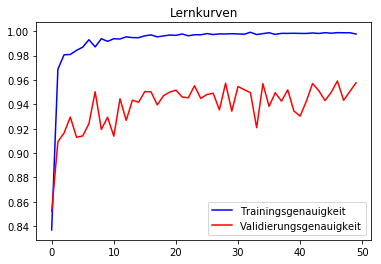

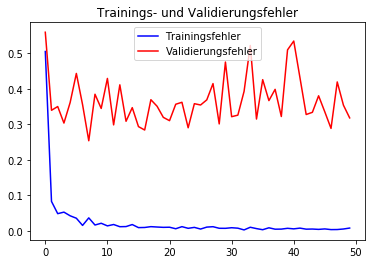

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        60
           1       0.99      0.99      0.99       720
           2       0.97      0.99      0.98       750
           3       0.99      0.92      0.95       450
           4       0.98      0.98      0.98       660
           5       0.93      0.92      0.92       630
           6       0.98      0.84      0.90       150
           7       0.94      0.98      0.96       450
           8       0.95      0.96      0.95       450
           9       0.98      1.00      0.99       480
          10       1.00      0.98      0.99       660
          11       0.93      0.88      0.90       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      0.99      1.00       270
          15       0.85      1.00      0.92       210
          16       0.97      0.99      0.98       

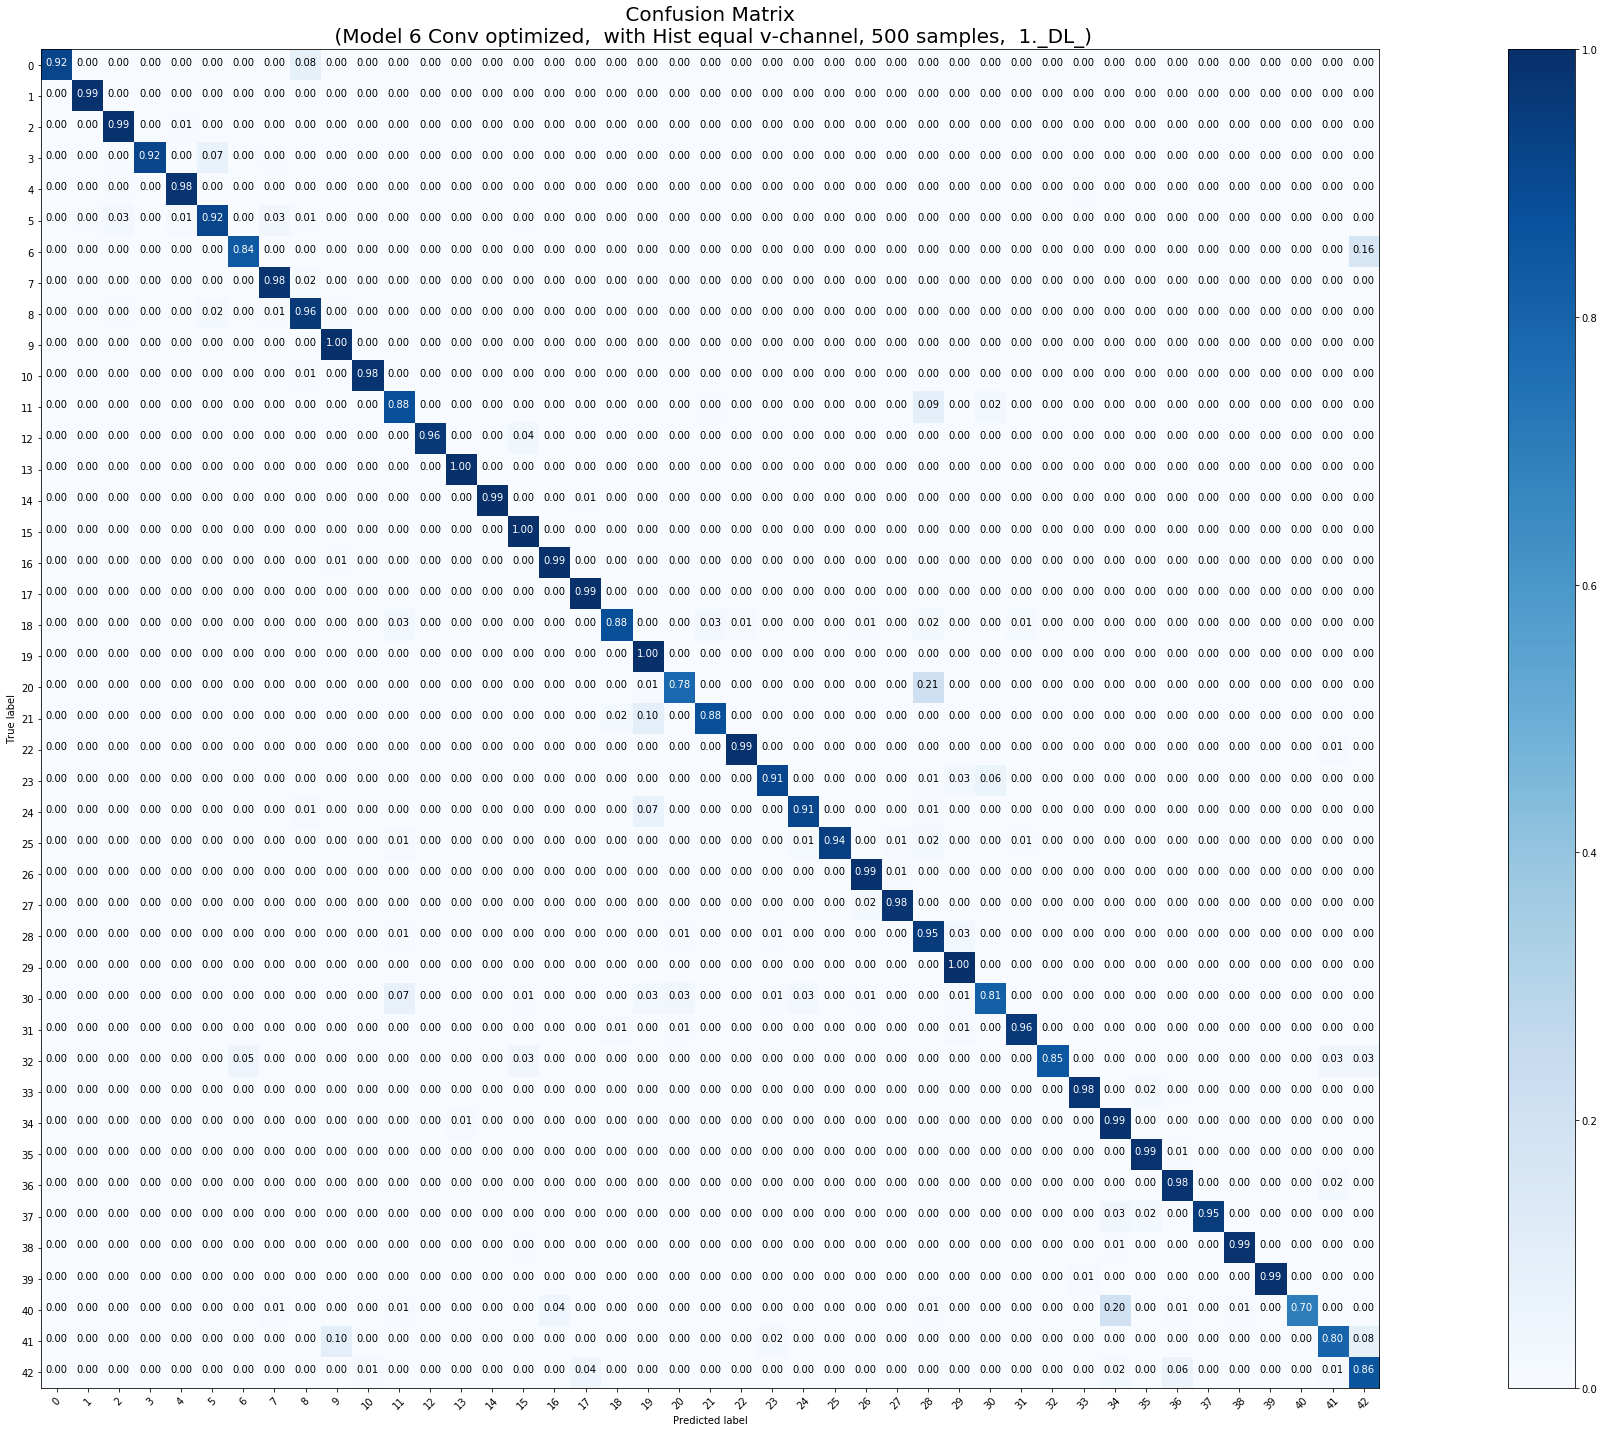

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 48s 39ms/step - loss: 0.5002 - acc: 0.8341 - val_loss: 0.4167 - val_acc: 0.8912
Epoch 2/50
1226/1226 [==============================] - 45s 37ms/step - loss: 0.0863 - acc: 0.9676 - val_loss: 0.4550 - val_acc: 0.8995
Epoch 3/50
1226/1226 [==============================] - 45s 37ms/step - loss: 0.0465 - acc: 0.9808 - val_loss: 0.4915 - val_acc: 0.8812
Epoch 4/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0428 - acc: 0.9836 - val_loss: 0.8342 - val_acc: 0.8462
Epoch 5/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0403 - acc: 0.9846 - val_loss: 0.4012 - val_acc: 0.9188
Epoch 6/50
1226/1226 [==============================] - 45s 37ms/step - loss: 0.0352 - acc: 0.9870 - val_loss: 0.4563 - val_acc: 0.9090
Epoch 7/50
1226/1226 [==============================] - 46s

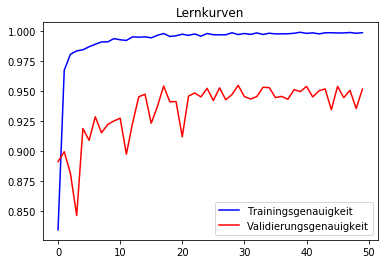

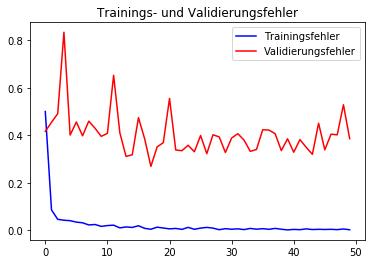

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        60
           1       1.00      0.98      0.99       720
           2       0.98      0.99      0.99       750
           3       0.99      0.92      0.95       450
           4       0.98      0.98      0.98       660
           5       0.94      0.95      0.95       630
           6       1.00      0.77      0.87       150
           7       0.96      0.98      0.97       450
           8       0.95      0.98      0.96       450
           9       0.98      1.00      0.99       480
          10       1.00      0.97      0.99       660
          11       0.96      0.98      0.97       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      0.98      0.99       270
          15       0.86      1.00      0.92       210
          16       0.85      0.99      0.92       

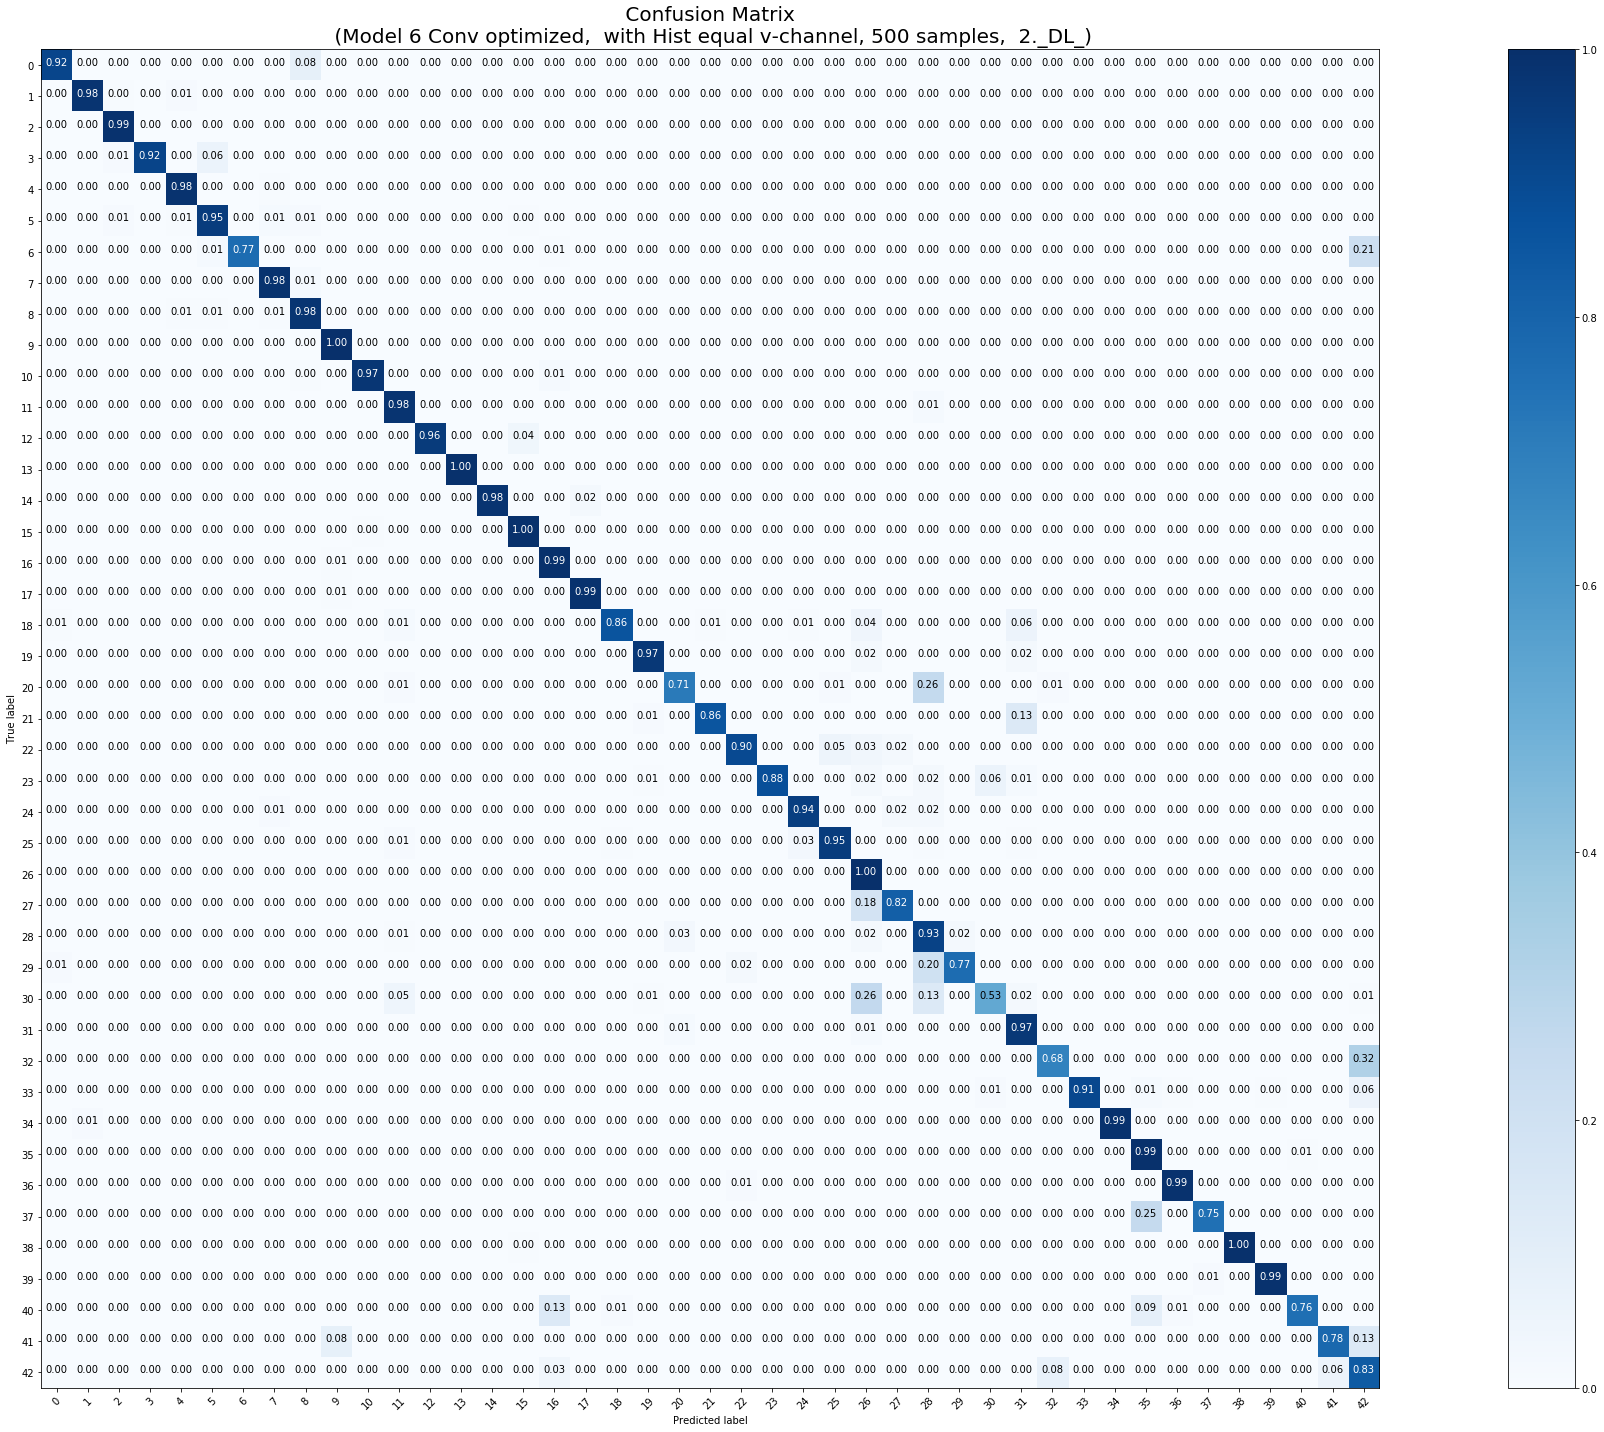

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 50s 41ms/step - loss: 0.5126 - acc: 0.8294 - val_loss: 0.3580 - val_acc: 0.8969
Epoch 2/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0781 - acc: 0.9708 - val_loss: 0.5041 - val_acc: 0.8778
Epoch 3/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0457 - acc: 0.9824 - val_loss: 0.3389 - val_acc: 0.9172
Epoch 4/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0590 - acc: 0.9788 - val_loss: 0.2805 - val_acc: 0.9345
Epoch 5/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0370 - acc: 0.9854 - val_loss: 0.4856 - val_acc: 0.8911
Epoch 6/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0358 - acc: 0.9874 - val_loss: 0.3363 - val_acc: 0.9328
Epoch 7/50
1226/1226 [==============================] - 46s

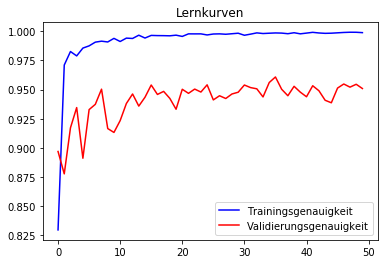

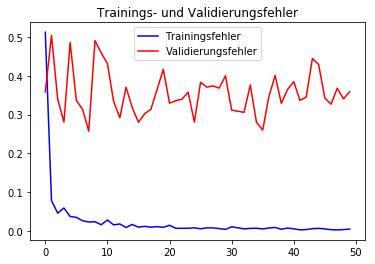

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.99      0.99      0.99       720
           2       0.99      0.97      0.98       750
           3       1.00      0.91      0.95       450
           4       0.97      0.98      0.98       660
           5       0.94      0.96      0.95       630
           6       0.96      0.76      0.85       150
           7       0.93      1.00      0.96       450
           8       0.99      0.90      0.94       450
           9       0.99      1.00      0.99       480
          10       0.99      0.98      0.99       660
          11       0.98      0.97      0.97       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.86      0.99      0.92       210
          16       0.94      0.99      0.96       

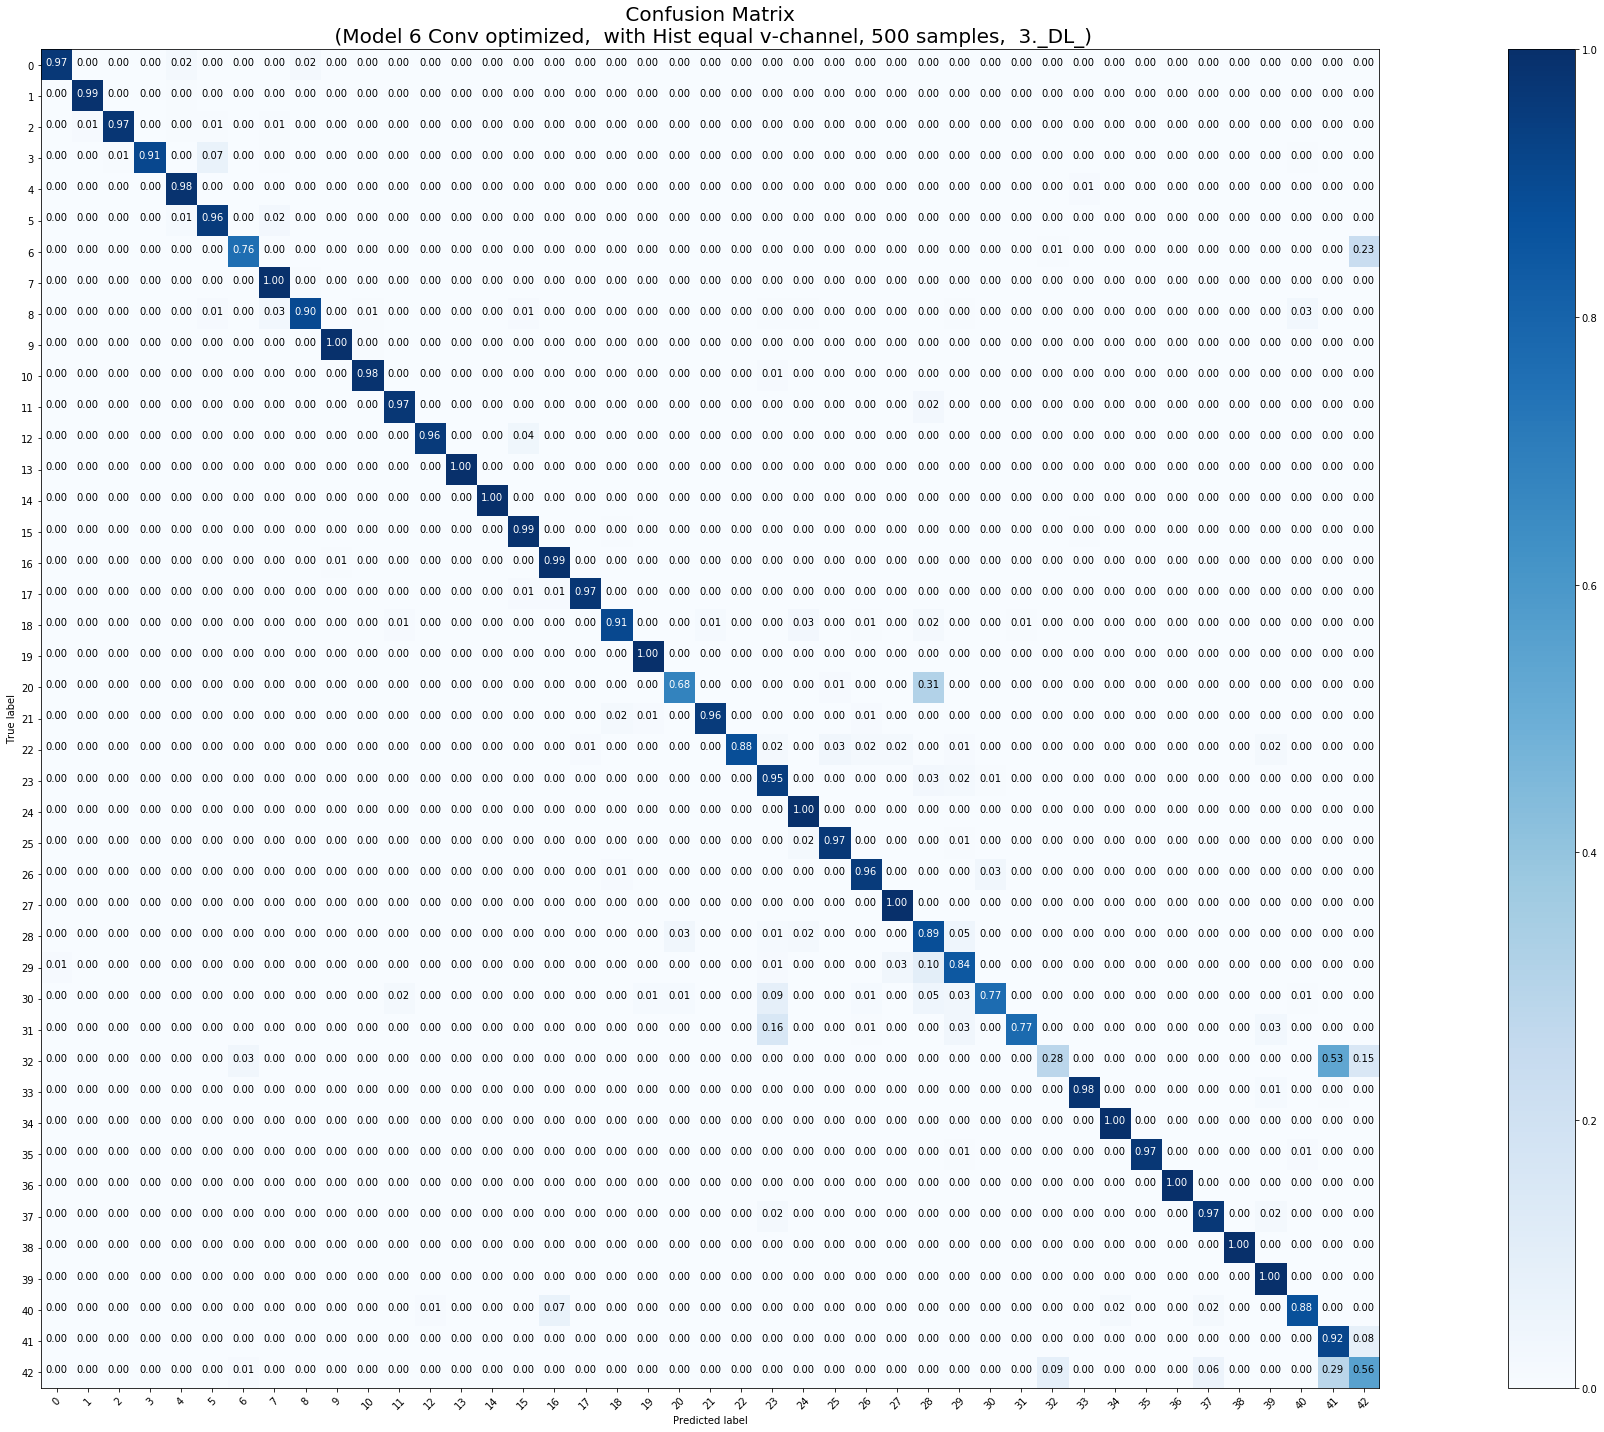

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 49s 40ms/step - loss: 0.5135 - acc: 0.8351 - val_loss: 0.3940 - val_acc: 0.8886
Epoch 2/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0764 - acc: 0.9718 - val_loss: 0.4145 - val_acc: 0.8980
Epoch 3/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0560 - acc: 0.9791 - val_loss: 0.7619 - val_acc: 0.8271
Epoch 4/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0501 - acc: 0.9802 - val_loss: 0.3719 - val_acc: 0.9119
Epoch 5/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0382 - acc: 0.9860 - val_loss: 0.2661 - val_acc: 0.9388
Epoch 6/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0322 - acc: 0.9881 - val_loss: 0.3938 - val_acc: 0.9127
Epoch 7/50
1226/1226 [==============================] - 45s

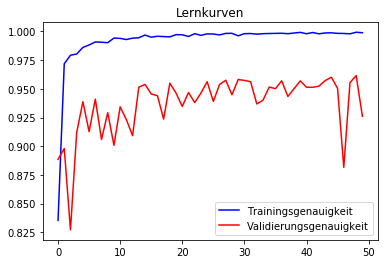

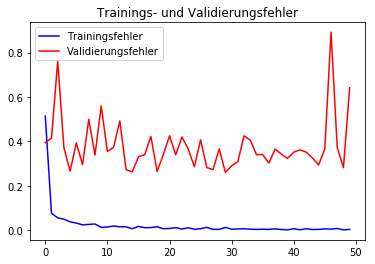

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.98      0.99       720
           2       0.96      0.98      0.97       750
           3       0.97      0.94      0.96       450
           4       0.99      0.98      0.99       660
           5       0.98      0.85      0.91       630
           6       0.95      0.81      0.87       150
           7       0.83      0.99      0.90       450
           8       0.97      0.92      0.94       450
           9       0.96      1.00      0.98       480
          10       1.00      0.91      0.95       660
          11       0.97      0.83      0.90       420
          12       1.00      0.94      0.97       690
          13       1.00      1.00      1.00       720
          14       1.00      0.99      1.00       270
          15       0.87      1.00      0.93       210
          16       0.82      0.99      0.90       

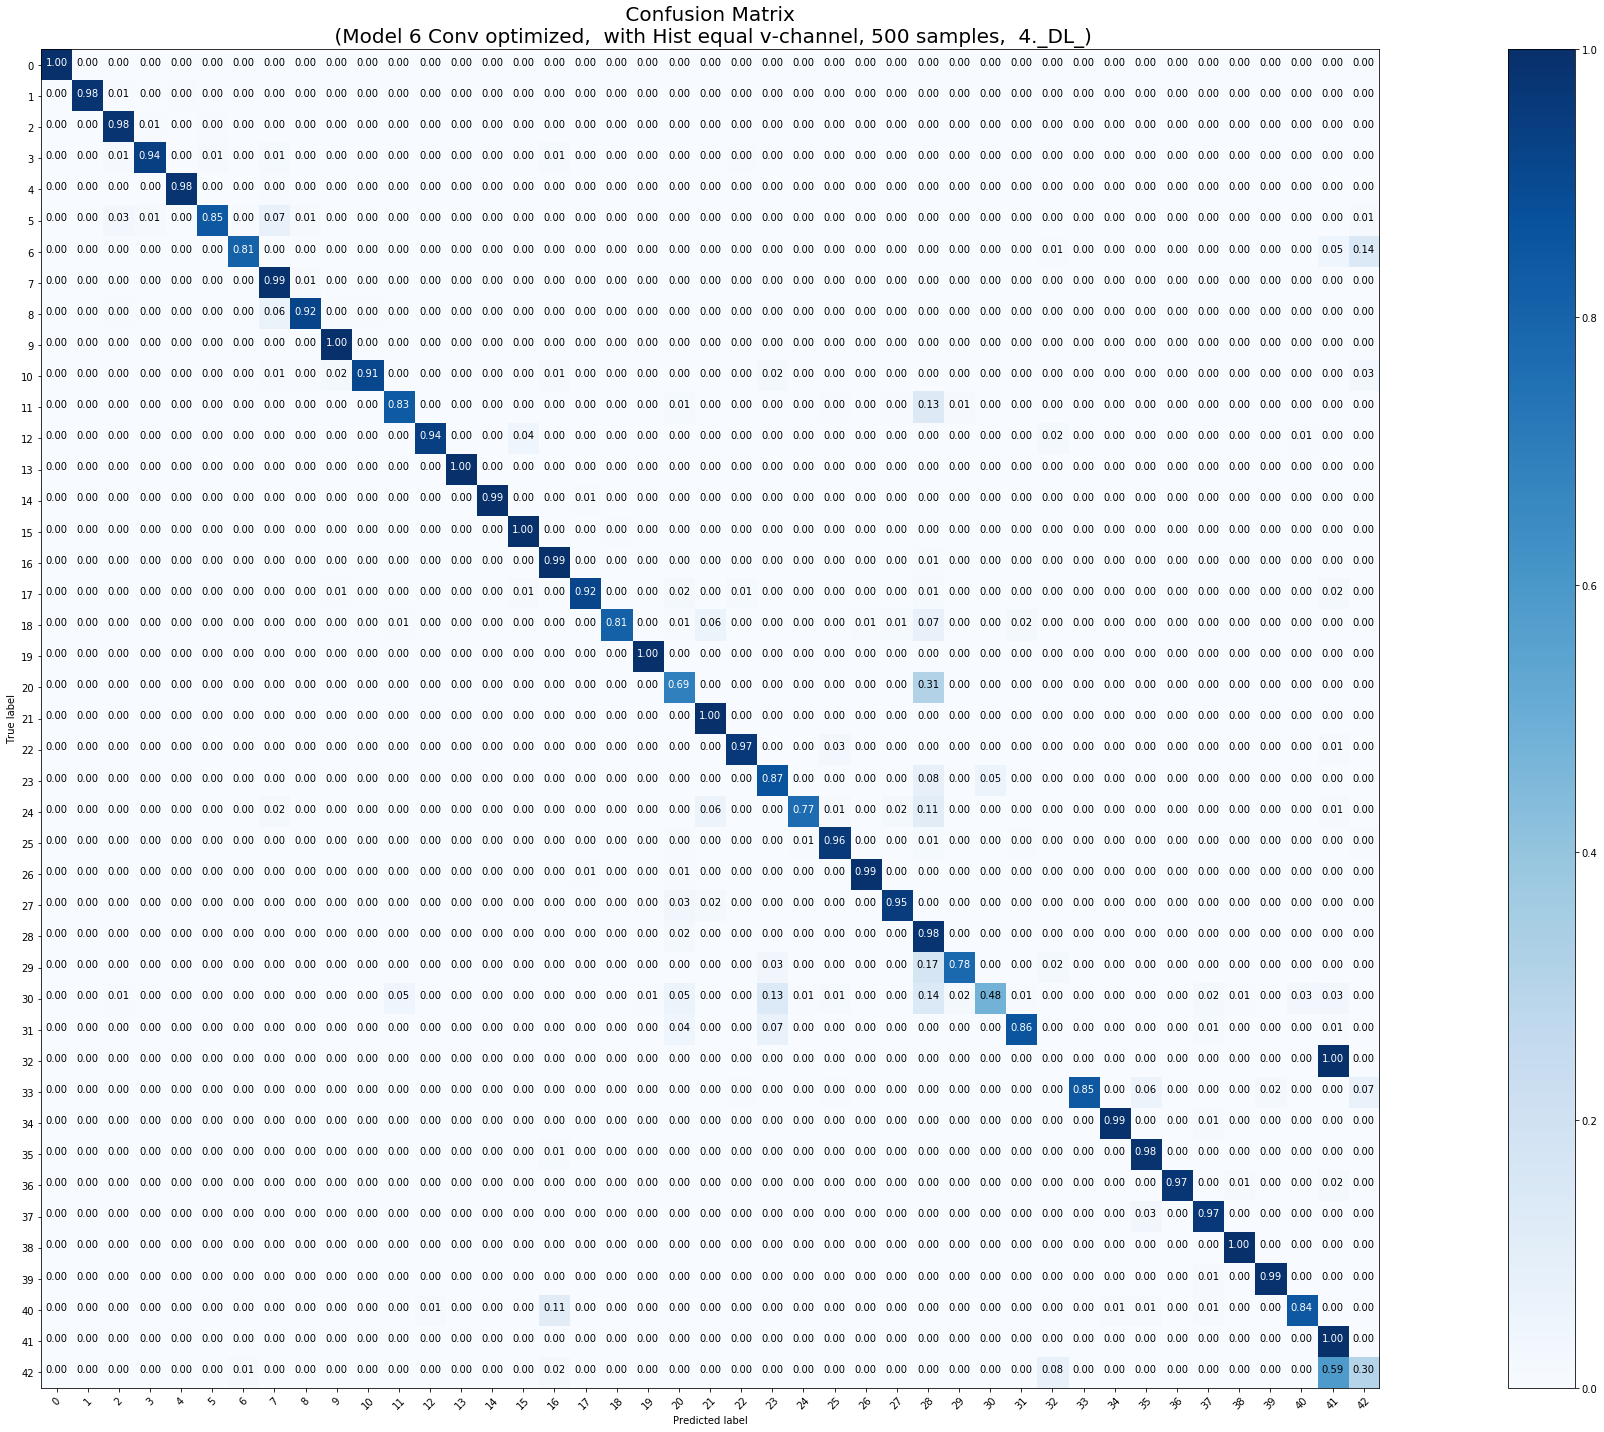

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 50s 41ms/step - loss: 0.5135 - acc: 0.8315 - val_loss: 0.5016 - val_acc: 0.8670
Epoch 2/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0757 - acc: 0.9683 - val_loss: 0.4605 - val_acc: 0.8801
Epoch 3/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0619 - acc: 0.9770 - val_loss: 0.3883 - val_acc: 0.9004
Epoch 4/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0437 - acc: 0.9833 - val_loss: 0.2811 - val_acc: 0.9265
Epoch 5/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0452 - acc: 0.9828 - val_loss: 0.5974 - val_acc: 0.8747
Epoch 6/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0281 - acc: 0.9887 - val_loss: 0.4289 - val_acc: 0.9058
Epoch 7/50
1226/1226 [==============================] - 47s

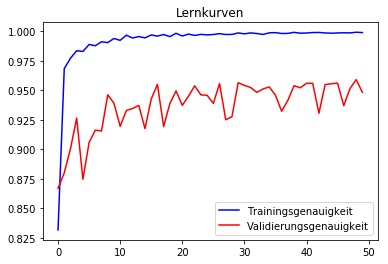

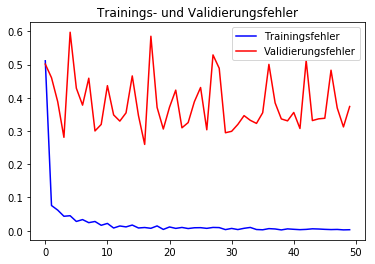

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.96      1.00      0.98       720
           2       0.98      0.95      0.97       750
           3       1.00      0.90      0.95       450
           4       0.98      0.97      0.97       660
           5       0.88      0.95      0.91       630
           6       0.99      0.77      0.86       150
           7       0.90      0.99      0.94       450
           8       0.99      0.87      0.93       450
           9       0.96      0.99      0.98       480
          10       0.98      0.99      0.99       660
          11       0.89      0.97      0.93       420
          12       1.00      0.95      0.98       690
          13       1.00      1.00      1.00       720
          14       0.97      0.99      0.98       270
          15       0.85      1.00      0.92       210
          16       0.95      0.99      0.97       

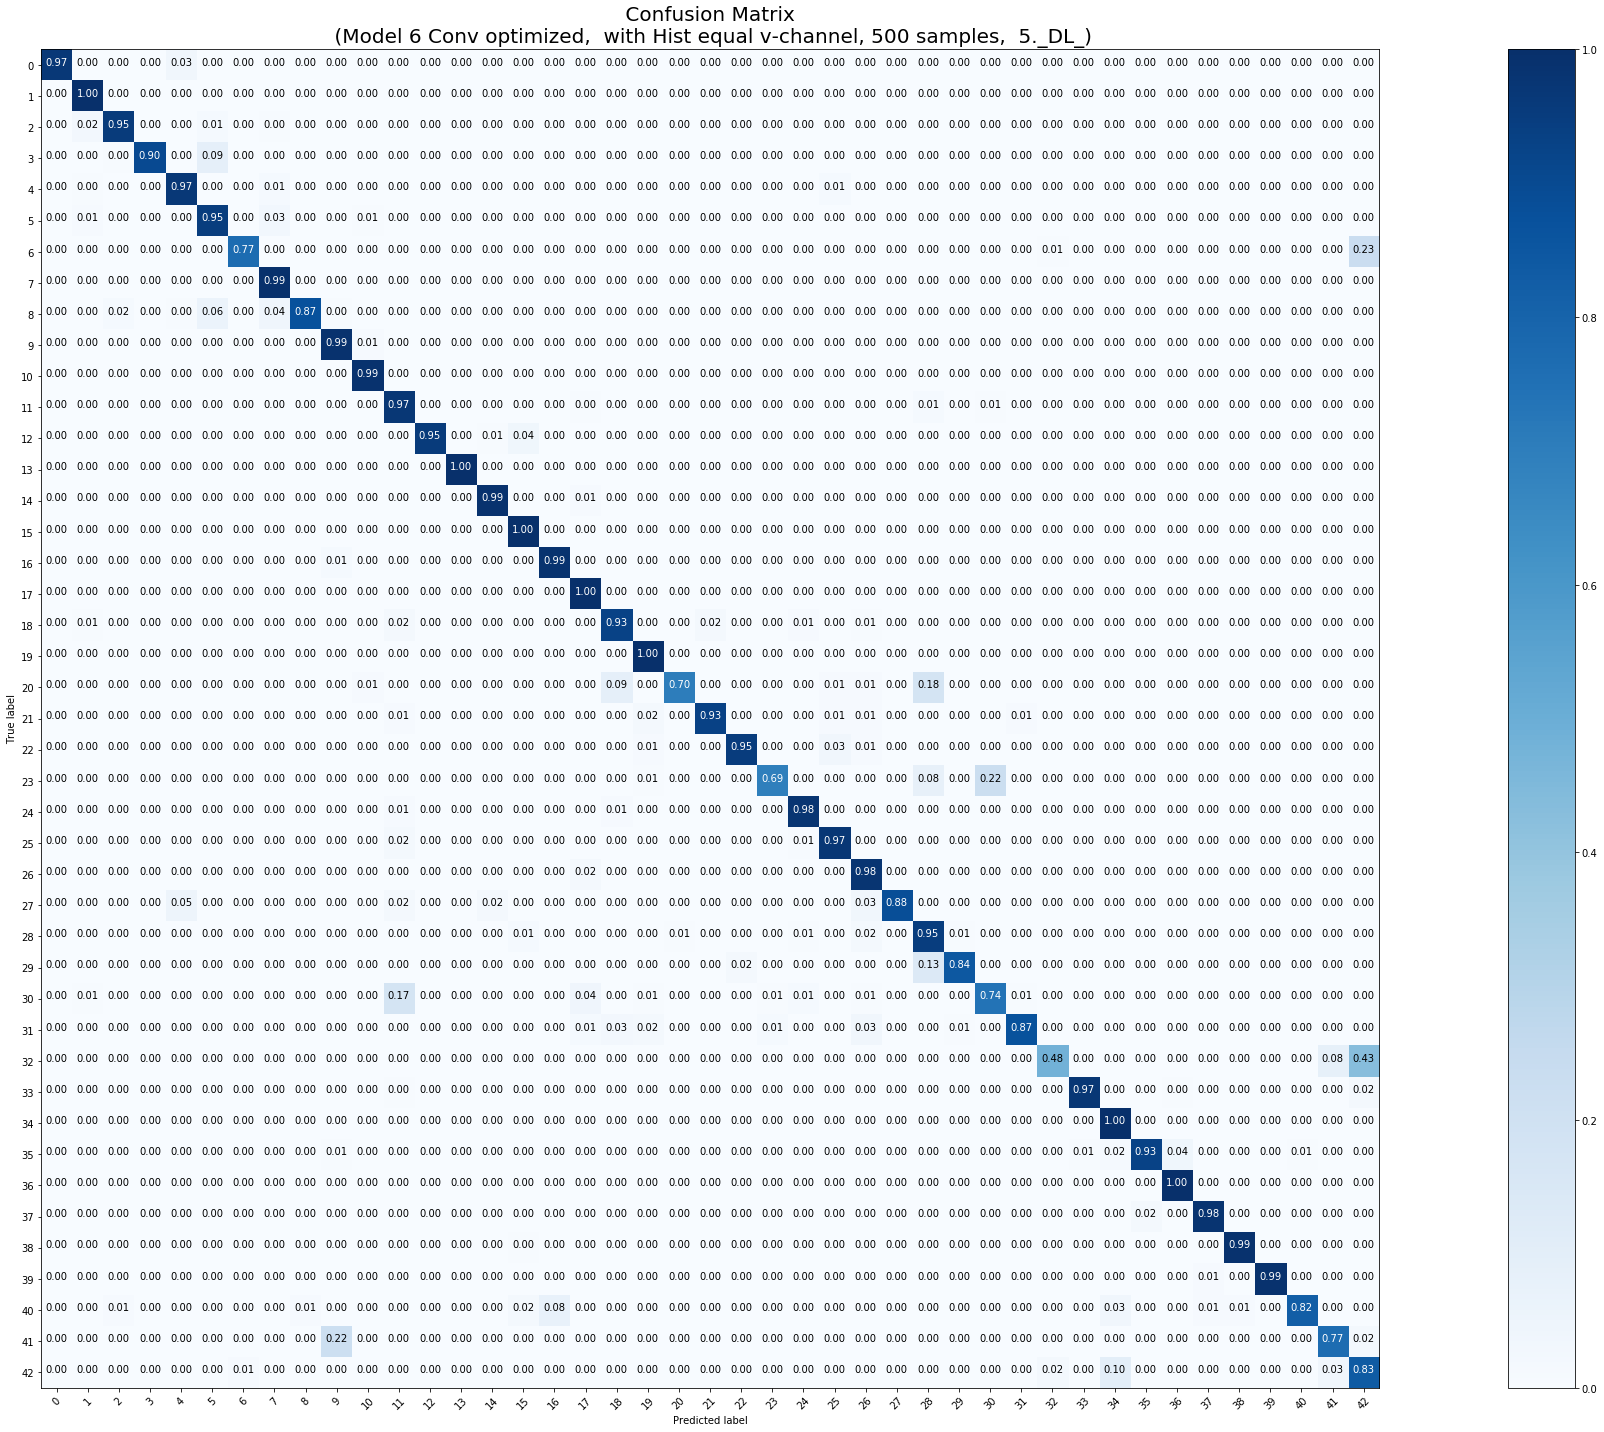

<Figure size 432x288 with 0 Axes>

In [0]:
# Trainingsmenge 500
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_500, y_tr_500, X_test, y_test, 0.2, 0.001, False, 500)

In [0]:
downloader(1,5,500)

***************************************************************************** 
1 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 49s 40ms/step - loss: 0.7009 - acc: 0.7846 - val_loss: 0.2081 - val_acc: 0.9382
Epoch 2/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.1447 - acc: 0.9476 - val_loss: 0.1599 - val_acc: 0.9564
Epoch 3/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.1076 - acc: 0.9608 - val_loss: 0.1327 - val_acc: 0.9612
Epoch 4/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0882 - acc: 0.9689 - val_loss: 0.1662 - val_acc: 0.9572
Epoch 5/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0661 - acc: 0.9760 - val_loss: 0.1665 - val_acc: 0.9635
Epoch 6/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0452 - acc: 0.9823 - val_loss: 0.1667 - val_acc: 0.9618
Epoch 7/50
1226/1226 [==============================] - 44s

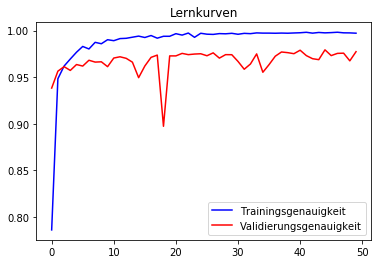

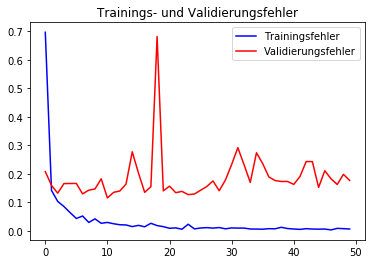

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       1.00      0.99      1.00       750
           3       0.98      0.93      0.95       450
           4       0.99      0.99      0.99       660
           5       0.94      0.99      0.96       630
           6       1.00      0.87      0.93       150
           7       0.93      0.99      0.96       450
           8       0.99      0.96      0.97       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       1.00      0.95      0.97       420
          12       0.99      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.86      1.00      0.92       210
          16       1.00      1.00      1.00       

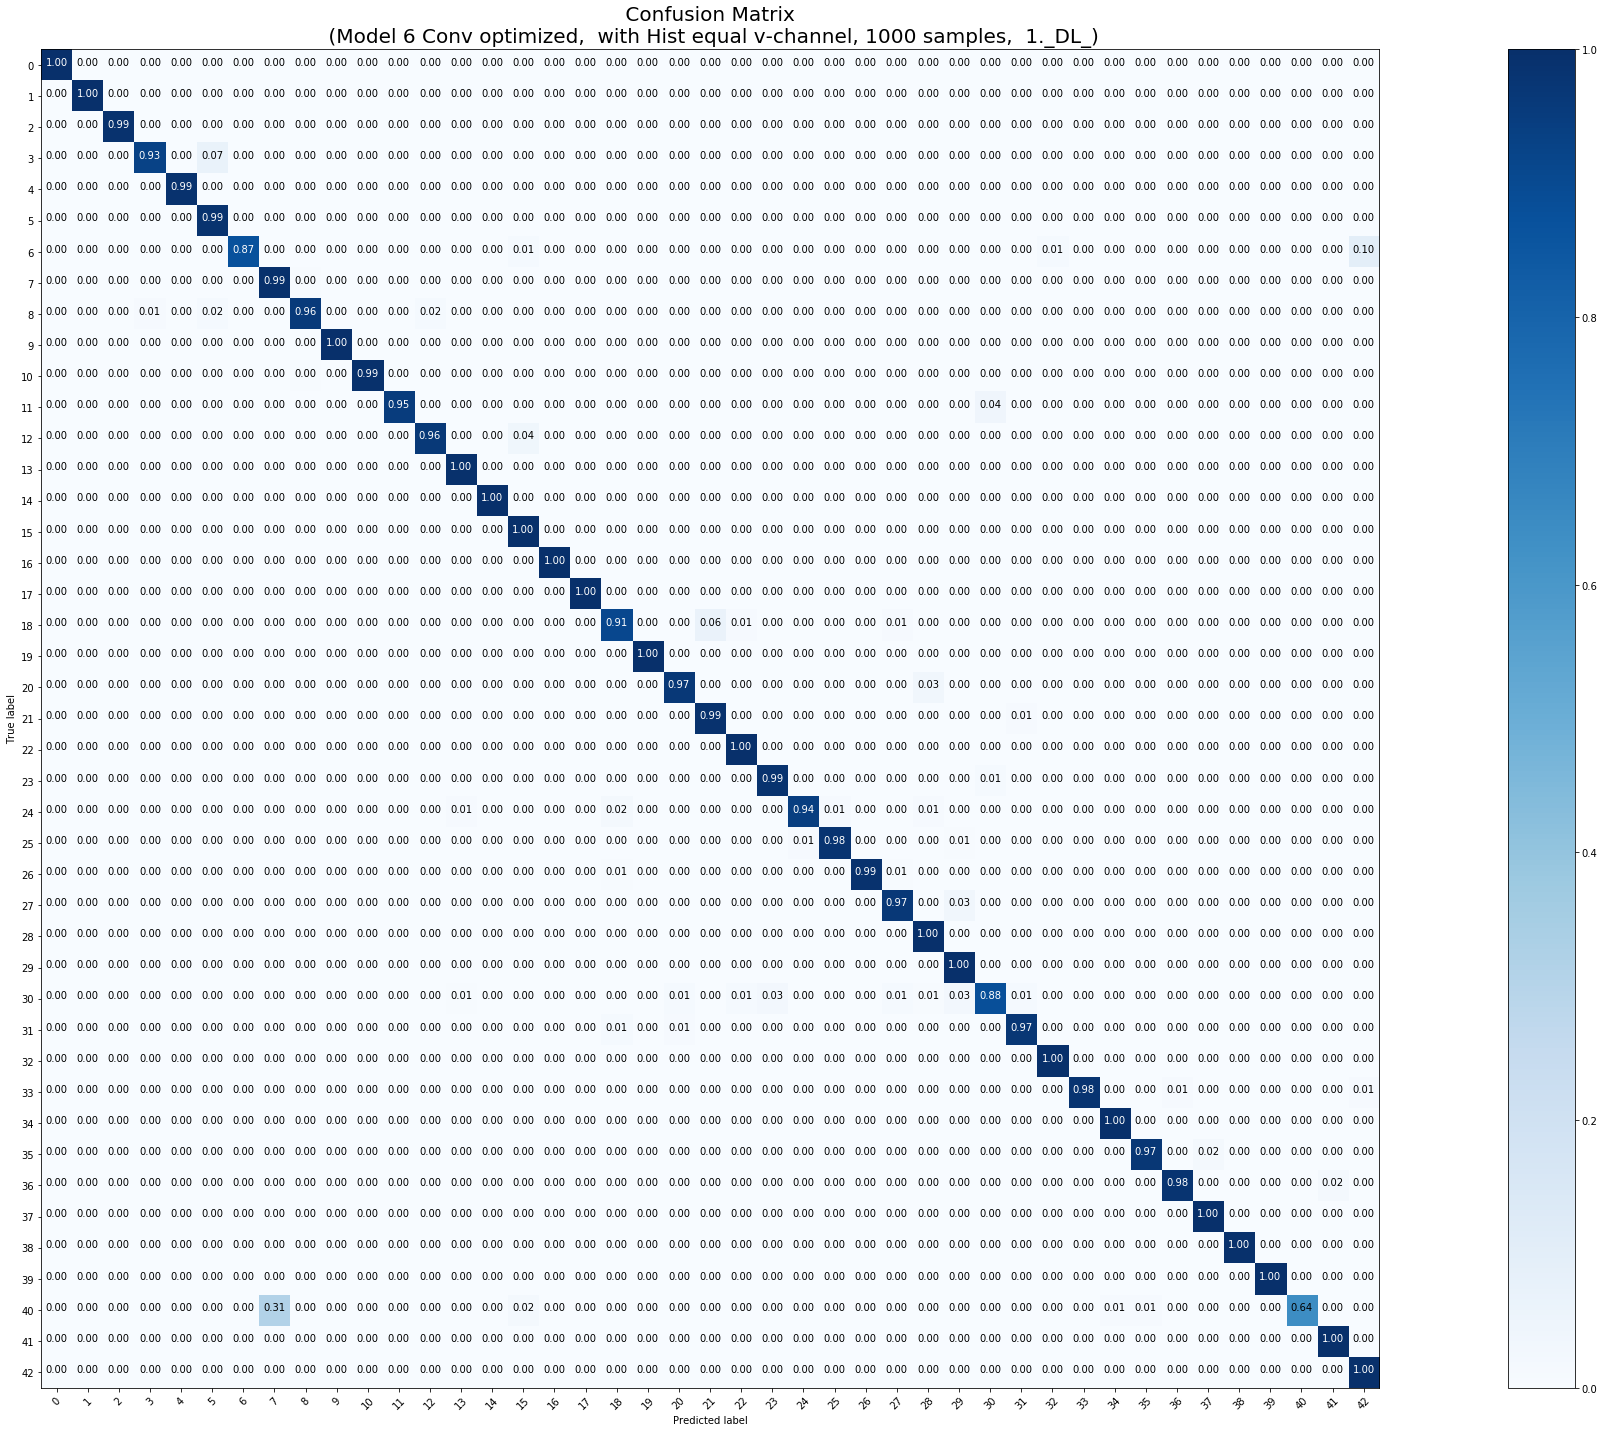

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 48s 39ms/step - loss: 0.7251 - acc: 0.7749 - val_loss: 0.2885 - val_acc: 0.9175
Epoch 2/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.1445 - acc: 0.9469 - val_loss: 0.2493 - val_acc: 0.9325
Epoch 3/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.0983 - acc: 0.9649 - val_loss: 0.1449 - val_acc: 0.9588
Epoch 4/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.0758 - acc: 0.9714 - val_loss: 0.4528 - val_acc: 0.8983
Epoch 5/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.0811 - acc: 0.9701 - val_loss: 0.0977 - val_acc: 0.9731
Epoch 6/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.0379 - acc: 0.9861 - val_loss: 0.1496 - val_acc: 0.9692
Epoch 7/50
1226/1226 [==============================] - 43s

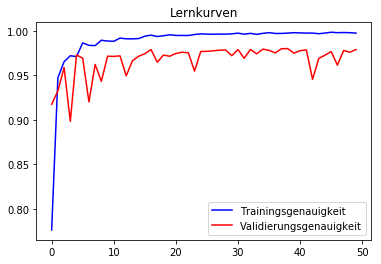

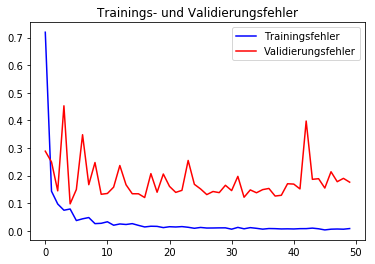

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      1.00      1.00       720
           2       1.00      0.99      1.00       750
           3       1.00      0.93      0.96       450
           4       1.00      0.98      0.99       660
           5       0.95      0.99      0.97       630
           6       1.00      0.82      0.90       150
           7       0.99      0.99      0.99       450
           8       0.97      0.97      0.97       450
           9       1.00      0.99      0.99       480
          10       1.00      0.98      0.99       660
          11       0.99      1.00      0.99       420
          12       0.99      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.85      1.00      0.92       210
          16       0.94      0.99      0.96       

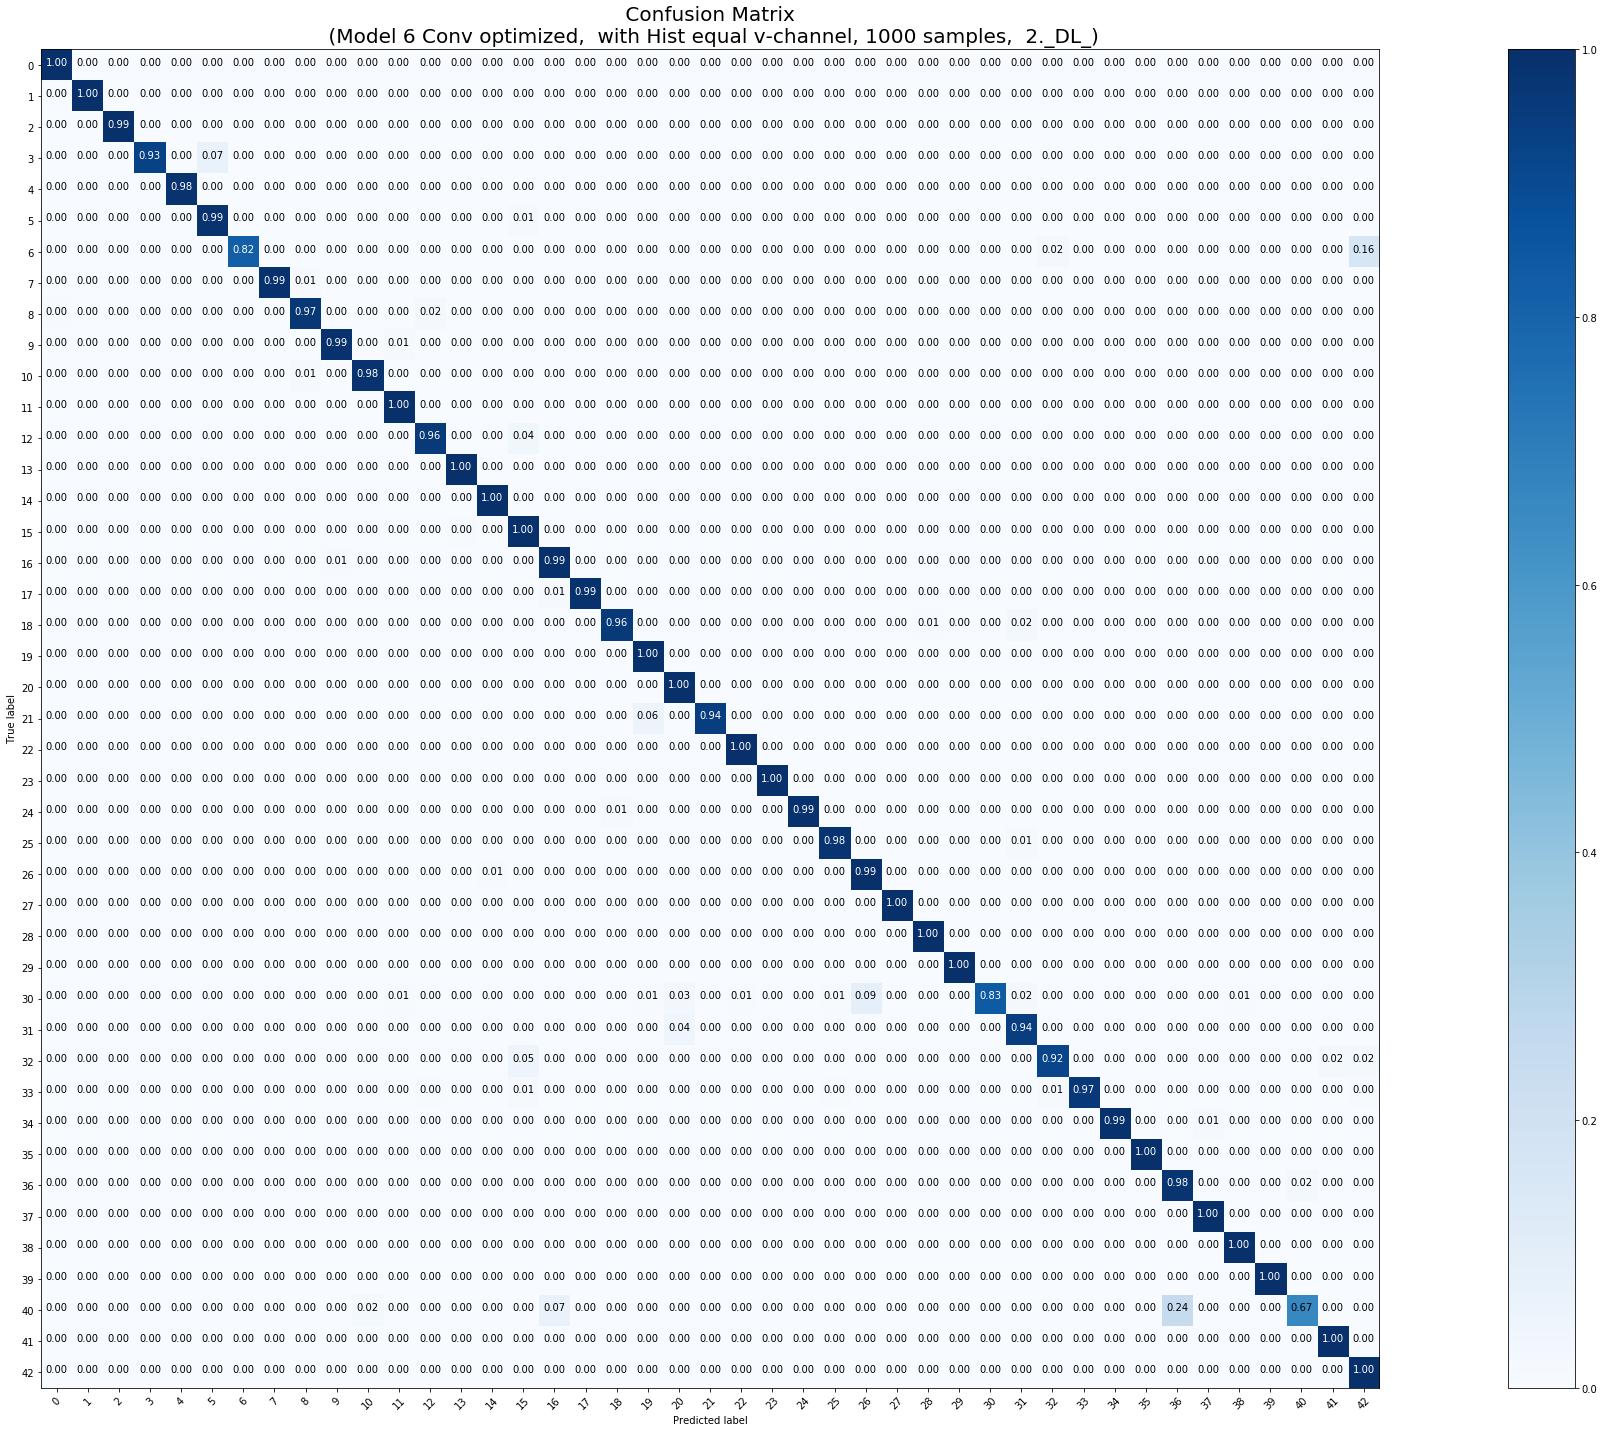

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 47s 39ms/step - loss: 0.7036 - acc: 0.7834 - val_loss: 0.2345 - val_acc: 0.9310
Epoch 2/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.1540 - acc: 0.9431 - val_loss: 0.3440 - val_acc: 0.8954
Epoch 3/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0840 - acc: 0.9700 - val_loss: 0.1987 - val_acc: 0.9451
Epoch 4/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0817 - acc: 0.9703 - val_loss: 0.1961 - val_acc: 0.9529
Epoch 5/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0606 - acc: 0.9773 - val_loss: 0.1137 - val_acc: 0.9711
Epoch 6/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0453 - acc: 0.9828 - val_loss: 0.1948 - val_acc: 0.9519
Epoch 7/50
1226/1226 [==============================] - 45s

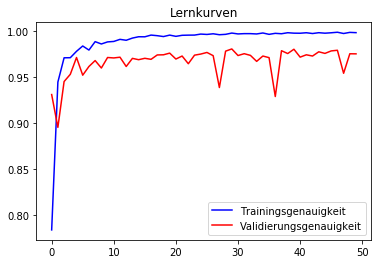

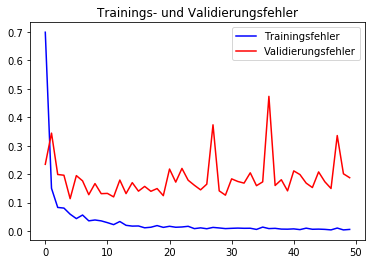

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00       720
           2       0.99      1.00      1.00       750
           3       0.99      0.93      0.96       450
           4       0.98      0.99      0.99       660
           5       0.93      0.97      0.95       630
           6       1.00      0.75      0.86       150
           7       0.98      0.98      0.98       450
           8       0.98      0.97      0.97       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.99      1.00      0.99       420
          12       0.99      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.85      1.00      0.91       210
          16       0.99      0.99      0.99       

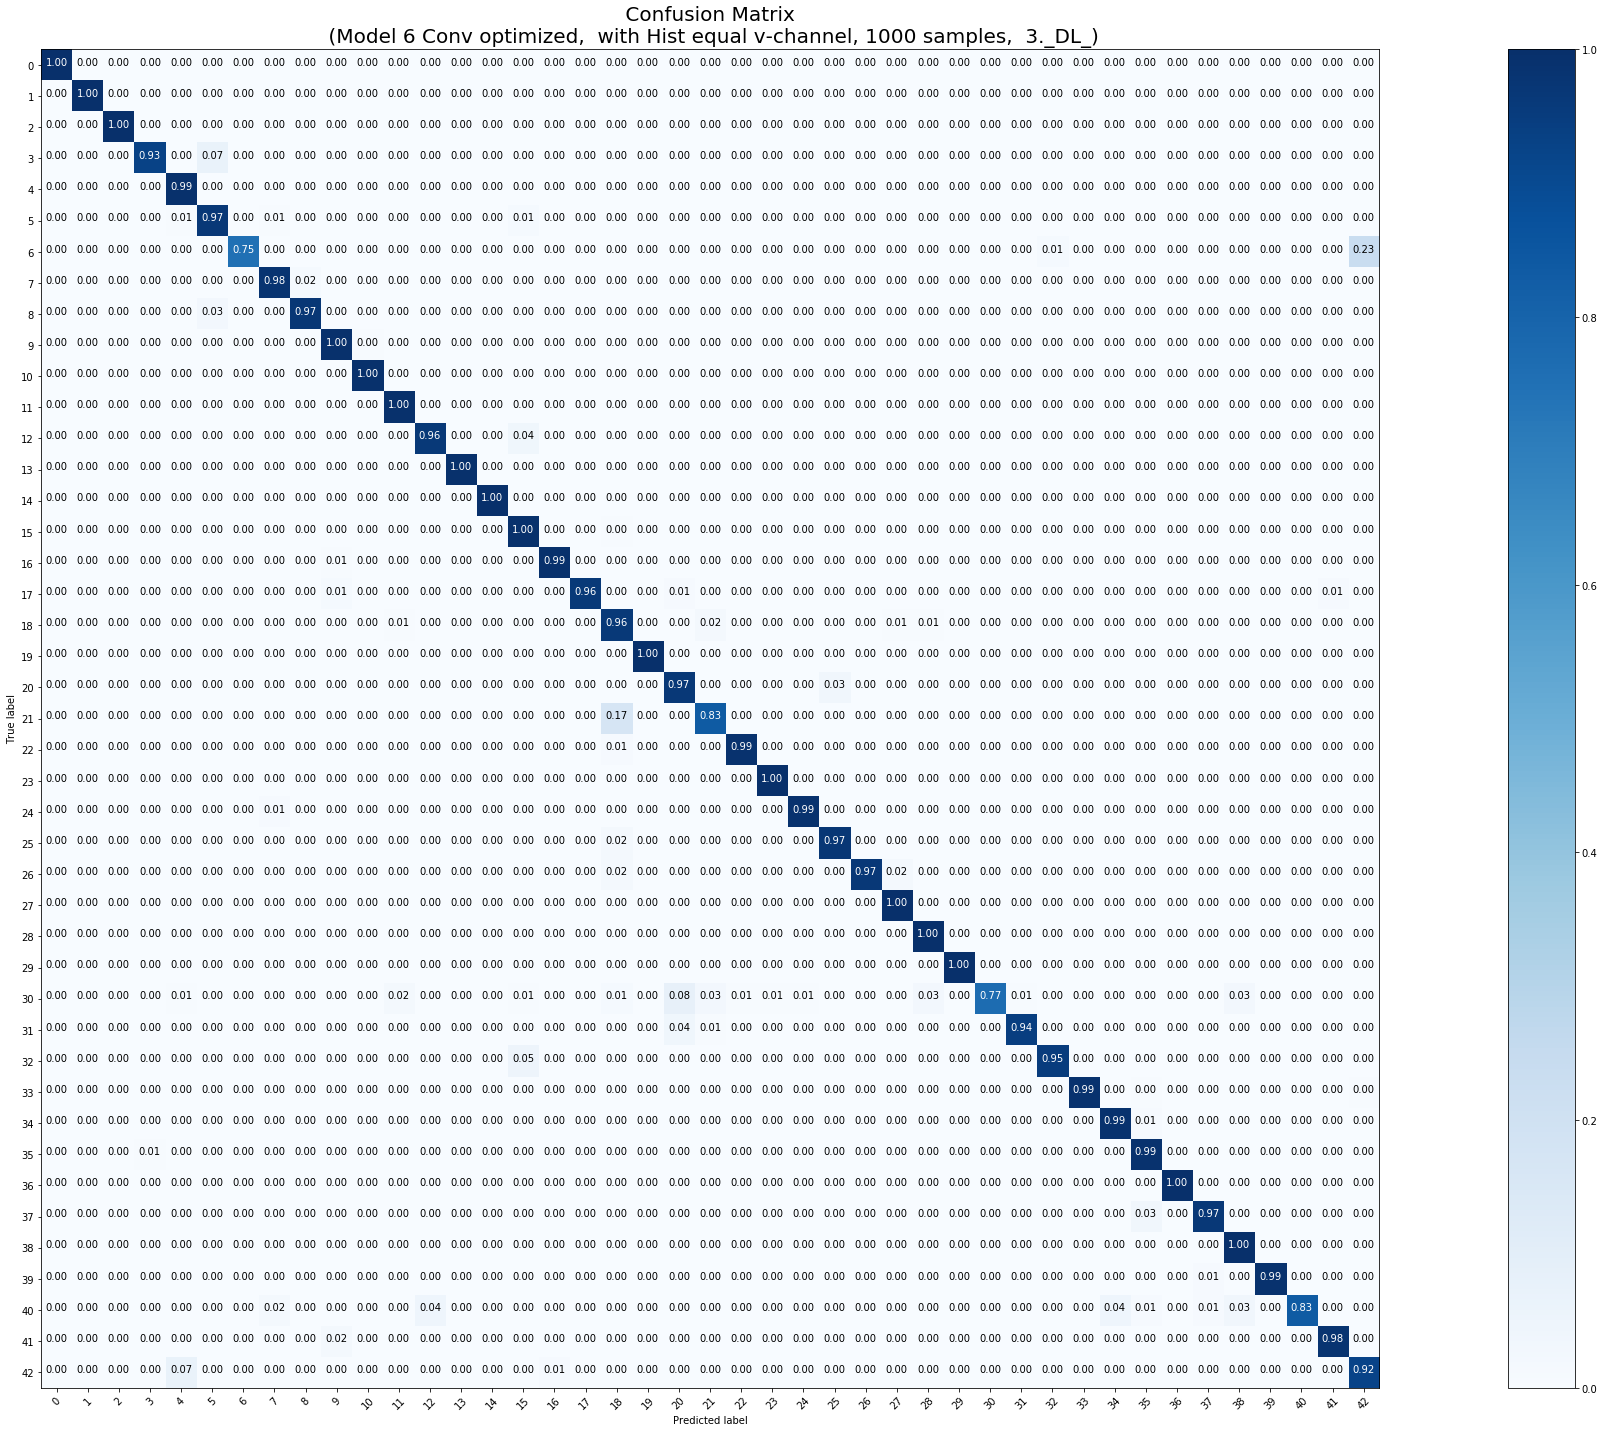

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 51s 42ms/step - loss: 0.7415 - acc: 0.7688 - val_loss: 0.1844 - val_acc: 0.9412
Epoch 2/50
1226/1226 [==============================] - 45s 37ms/step - loss: 0.1328 - acc: 0.9493 - val_loss: 0.1839 - val_acc: 0.9465
Epoch 3/50
1226/1226 [==============================] - 45s 36ms/step - loss: 0.0973 - acc: 0.9648 - val_loss: 0.1925 - val_acc: 0.9443
Epoch 4/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0706 - acc: 0.9733 - val_loss: 0.2234 - val_acc: 0.9424
Epoch 5/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0599 - acc: 0.9777 - val_loss: 0.2022 - val_acc: 0.9561
Epoch 6/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.0513 - acc: 0.9795 - val_loss: 0.1936 - val_acc: 0.9481
Epoch 7/50
1226/1226 [==============================] - 44s

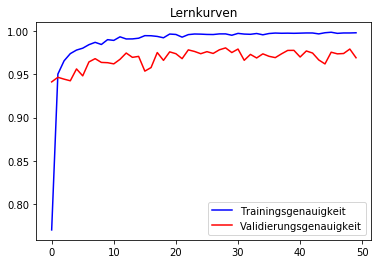

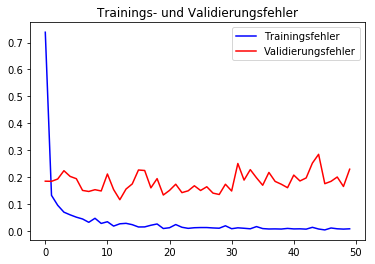

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.98      0.99       720
           2       0.98      0.99      0.98       750
           3       1.00      0.92      0.96       450
           4       1.00      0.98      0.99       660
           5       0.94      0.97      0.96       630
           6       1.00      0.71      0.83       150
           7       0.96      1.00      0.98       450
           8       0.97      0.98      0.97       450
           9       0.98      0.99      0.99       480
          10       0.98      0.99      0.99       660
          11       0.97      0.99      0.98       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.84      1.00      0.91       210
          16       0.95      0.99      0.97       

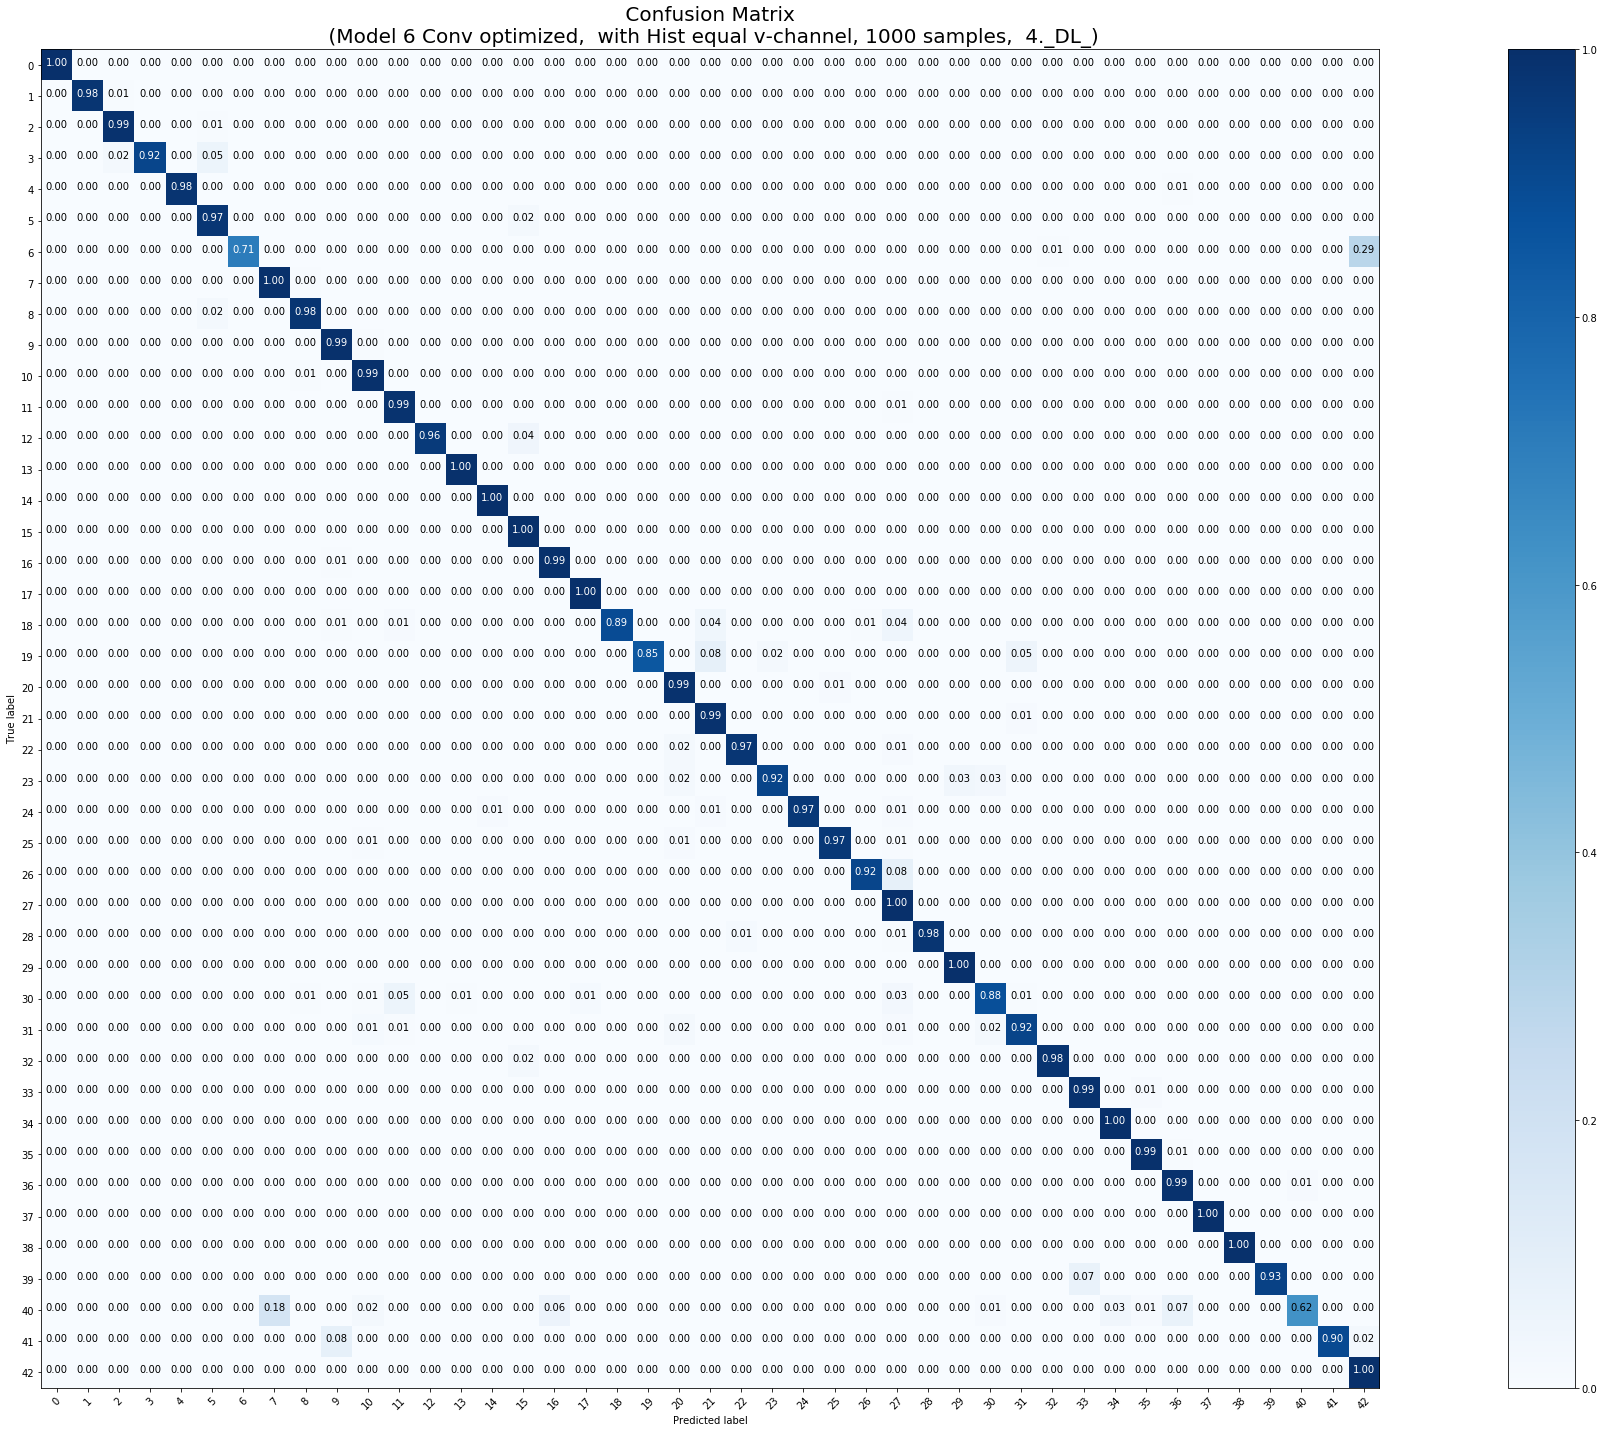

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 53s 43ms/step - loss: 0.7515 - acc: 0.7709 - val_loss: 0.2207 - val_acc: 0.9329
Epoch 2/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.1353 - acc: 0.9485 - val_loss: 0.2765 - val_acc: 0.9206
Epoch 3/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0921 - acc: 0.9651 - val_loss: 0.1742 - val_acc: 0.9459
Epoch 4/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0966 - acc: 0.9681 - val_loss: 0.2767 - val_acc: 0.9287
Epoch 5/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0575 - acc: 0.9784 - val_loss: 0.2023 - val_acc: 0.9488
Epoch 6/50
1226/1226 [==============================] - 45s 37ms/step - loss: 0.0598 - acc: 0.9789 - val_loss: 0.1690 - val_acc: 0.9580
Epoch 7/50
1226/1226 [==============================] - 46s

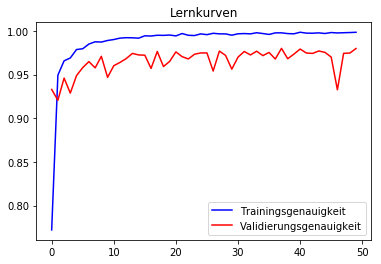

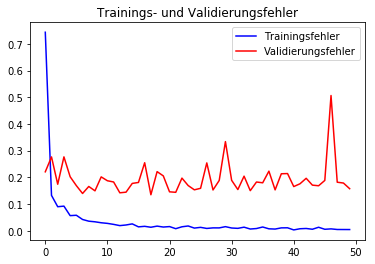

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       1.00      0.92      0.96       450
           4       0.99      0.99      0.99       660
           5       0.95      0.97      0.96       630
           6       1.00      0.83      0.91       150
           7       1.00      0.98      0.99       450
           8       0.97      0.96      0.97       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.99      0.99       420
          12       0.99      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.88      1.00      0.93       210
          16       0.97      0.99      0.98       

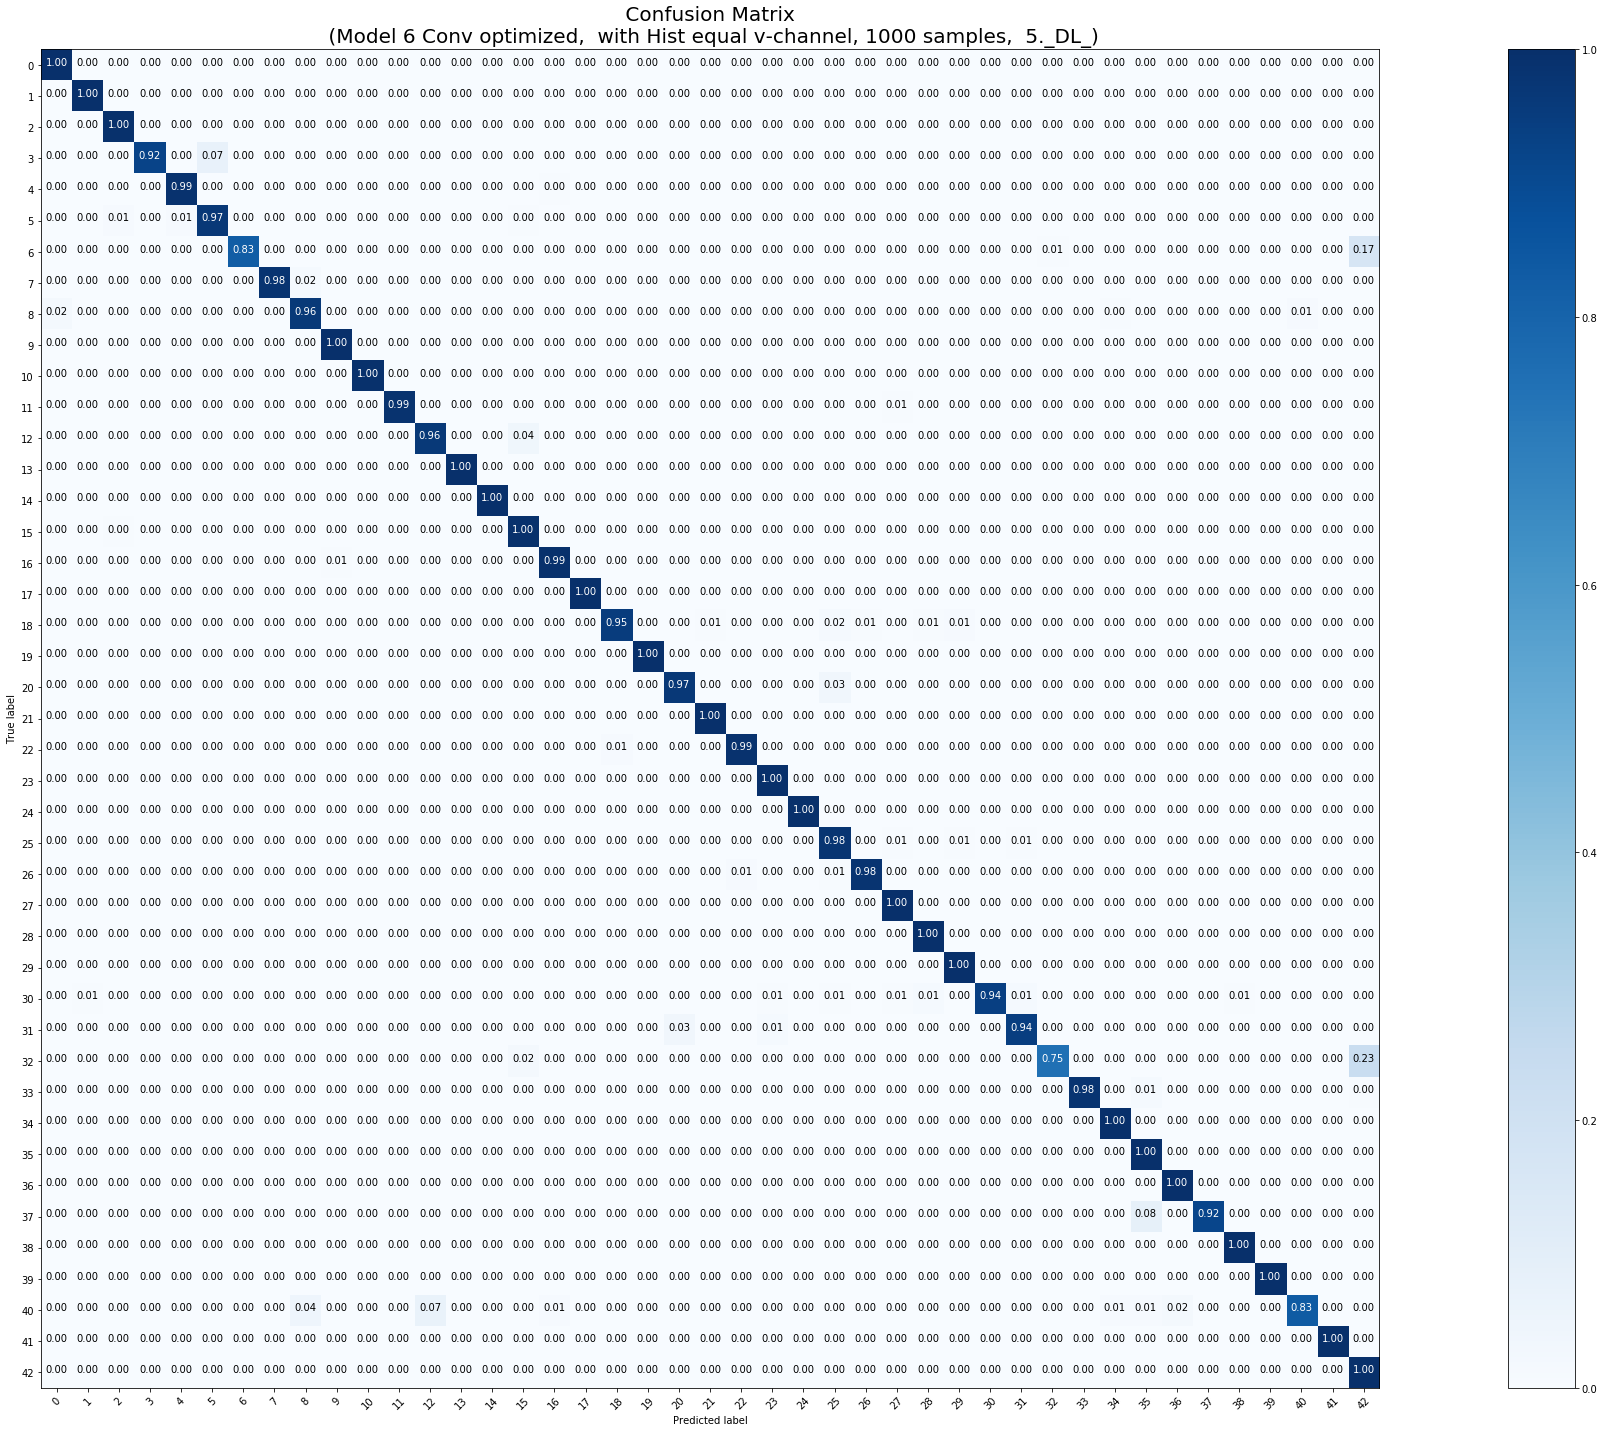

<Figure size 432x288 with 0 Axes>

In [0]:
# Trainingsmenge 1000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_1000, y_tr_1000, X_test, y_test, 0.2, 0.001, False, 1000)

In [0]:
downloader(1,5,1000)

***************************************************************************** 
1 ._Trainingsdurchlauf
 










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Modell wurde erzeugt
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
1226/1226 [==============================] - 74s 60ms/step - loss: 0.7990 - acc: 0.7600 - val_loss: 0.1659 - val_acc: 0.9501
Epoch 2/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.1654 - acc: 0.9371 - val_loss: 0.1345 - val_acc: 0.9586
Epoch 3/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.1162 - acc: 0.9562 - val_loss: 0.1170 - val_acc: 0.9690
Epoch 4/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.0863 - acc: 0.9668 - val_loss: 0.1086 - val_acc: 0.9648
Epoch 5/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.0684 - acc: 0.9750 - val_los

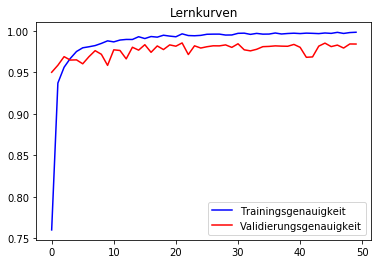

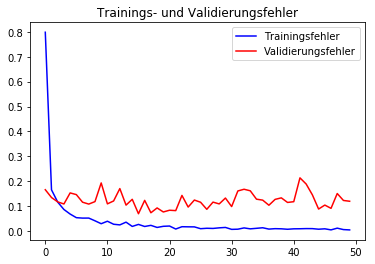

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      0.99      1.00       750
           3       1.00      0.93      0.96       450
           4       1.00      0.99      0.99       660
           5       0.96      0.98      0.97       630
           6       1.00      0.80      0.89       150
           7       0.97      0.99      0.98       450
           8       0.97      1.00      0.98       450
           9       0.99      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       0.99      0.99      0.99       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.88      1.00      0.94       210
          16       1.00      0.99      1.00       

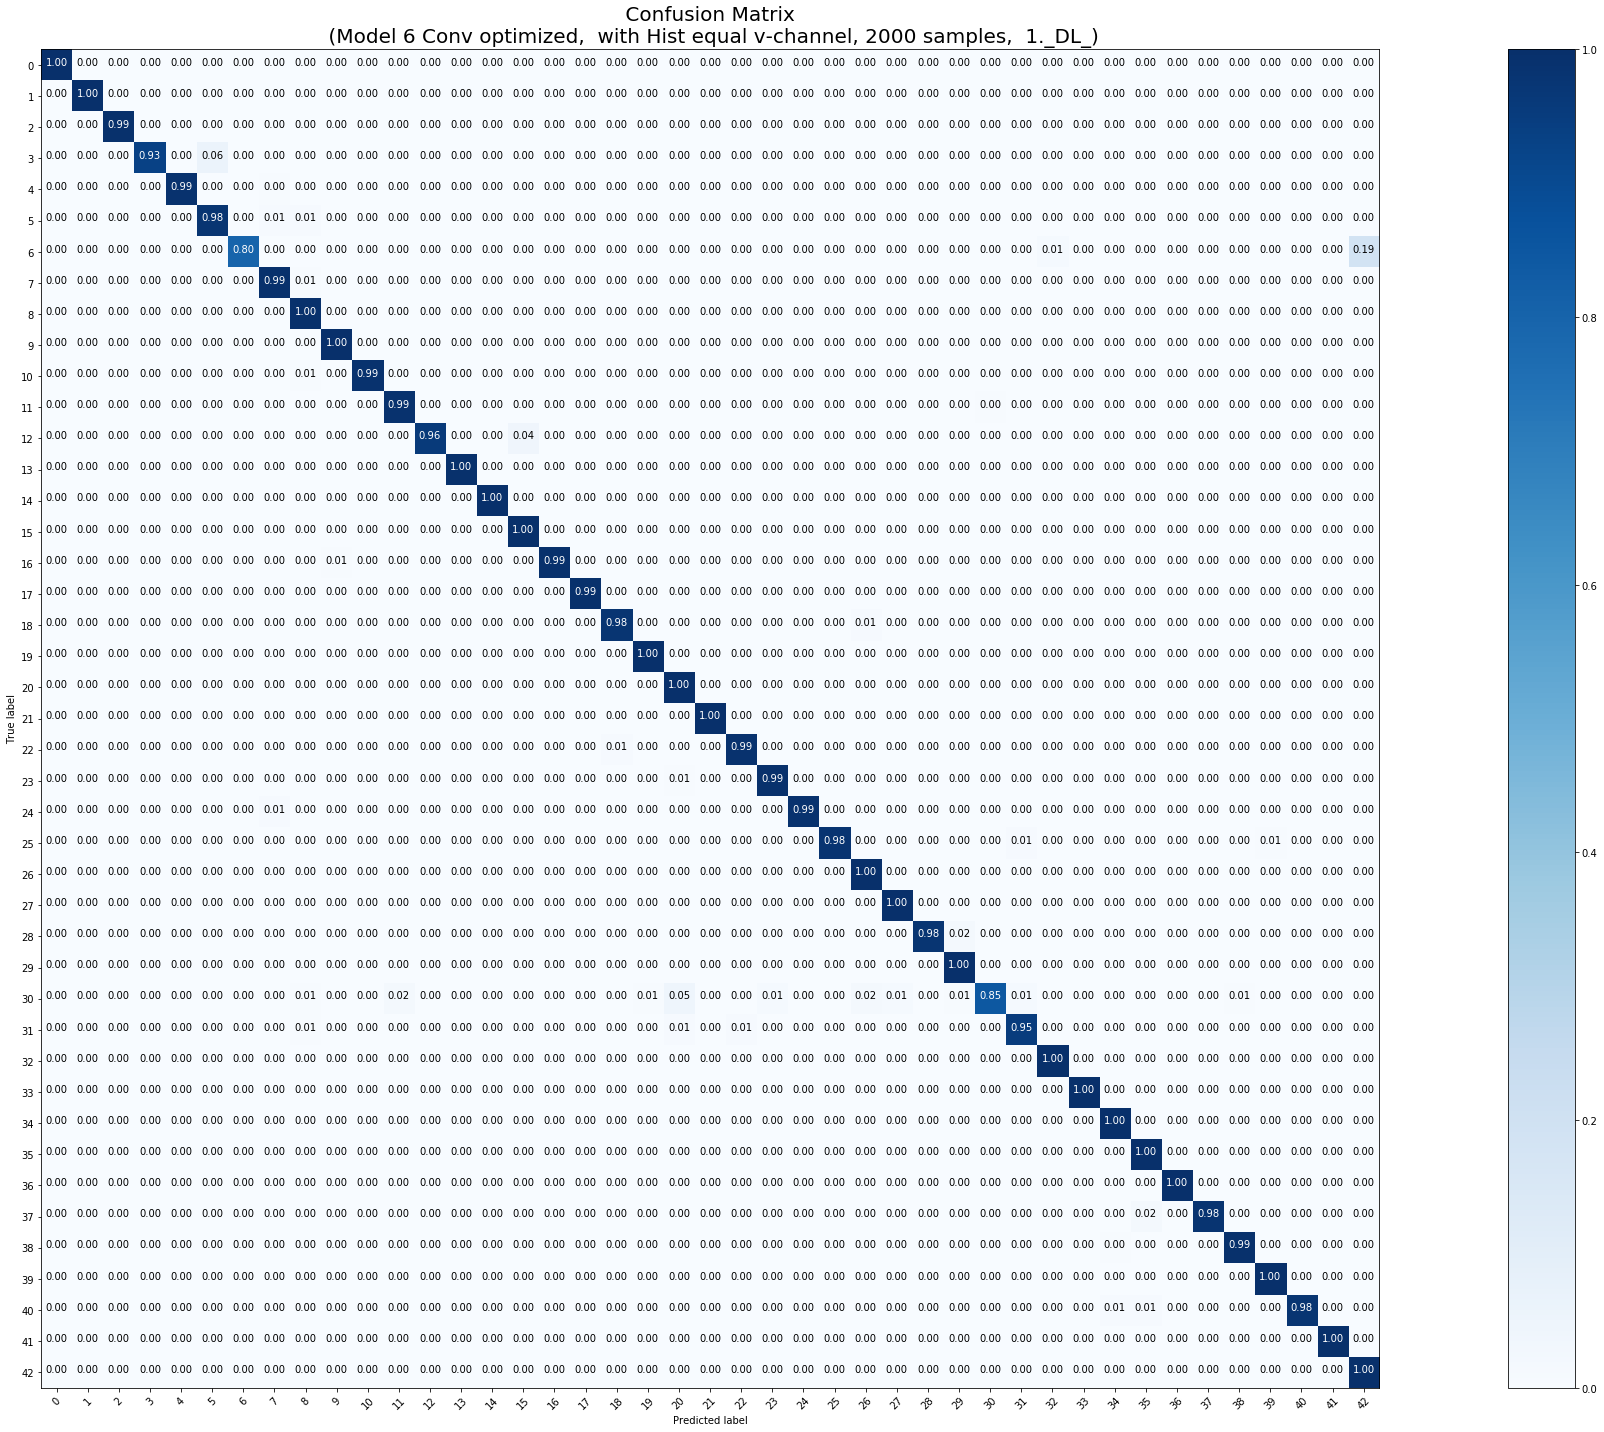

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 73s 59ms/step - loss: 0.7601 - acc: 0.7695 - val_loss: 0.1811 - val_acc: 0.9469
Epoch 2/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.1670 - acc: 0.9400 - val_loss: 0.1777 - val_acc: 0.9528
Epoch 3/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.1138 - acc: 0.9574 - val_loss: 0.1239 - val_acc: 0.9640
Epoch 4/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.0846 - acc: 0.9690 - val_loss: 0.1598 - val_acc: 0.9576
Epoch 5/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.0784 - acc: 0.9718 - val_loss: 0.1278 - val_acc: 0.9641
Epoch 6/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.0647 - acc: 0.9765 - val_loss: 0.1175 - val_acc: 0.9740
Epoch 7/50
1226/1226 [==============================] - 70s

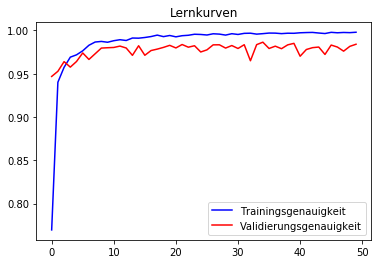

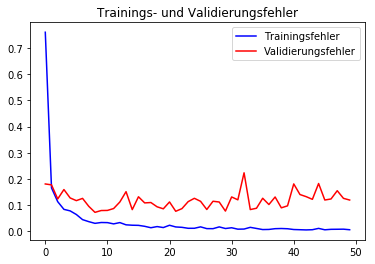

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.93      0.96       450
           4       1.00      0.99      1.00       660
           5       0.95      0.99      0.97       630
           6       1.00      0.81      0.89       150
           7       0.99      1.00      0.99       450
           8       0.97      0.99      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.98      0.99       660
          11       0.99      0.99      0.99       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.86      1.00      0.92       210
          16       1.00      0.99      1.00       

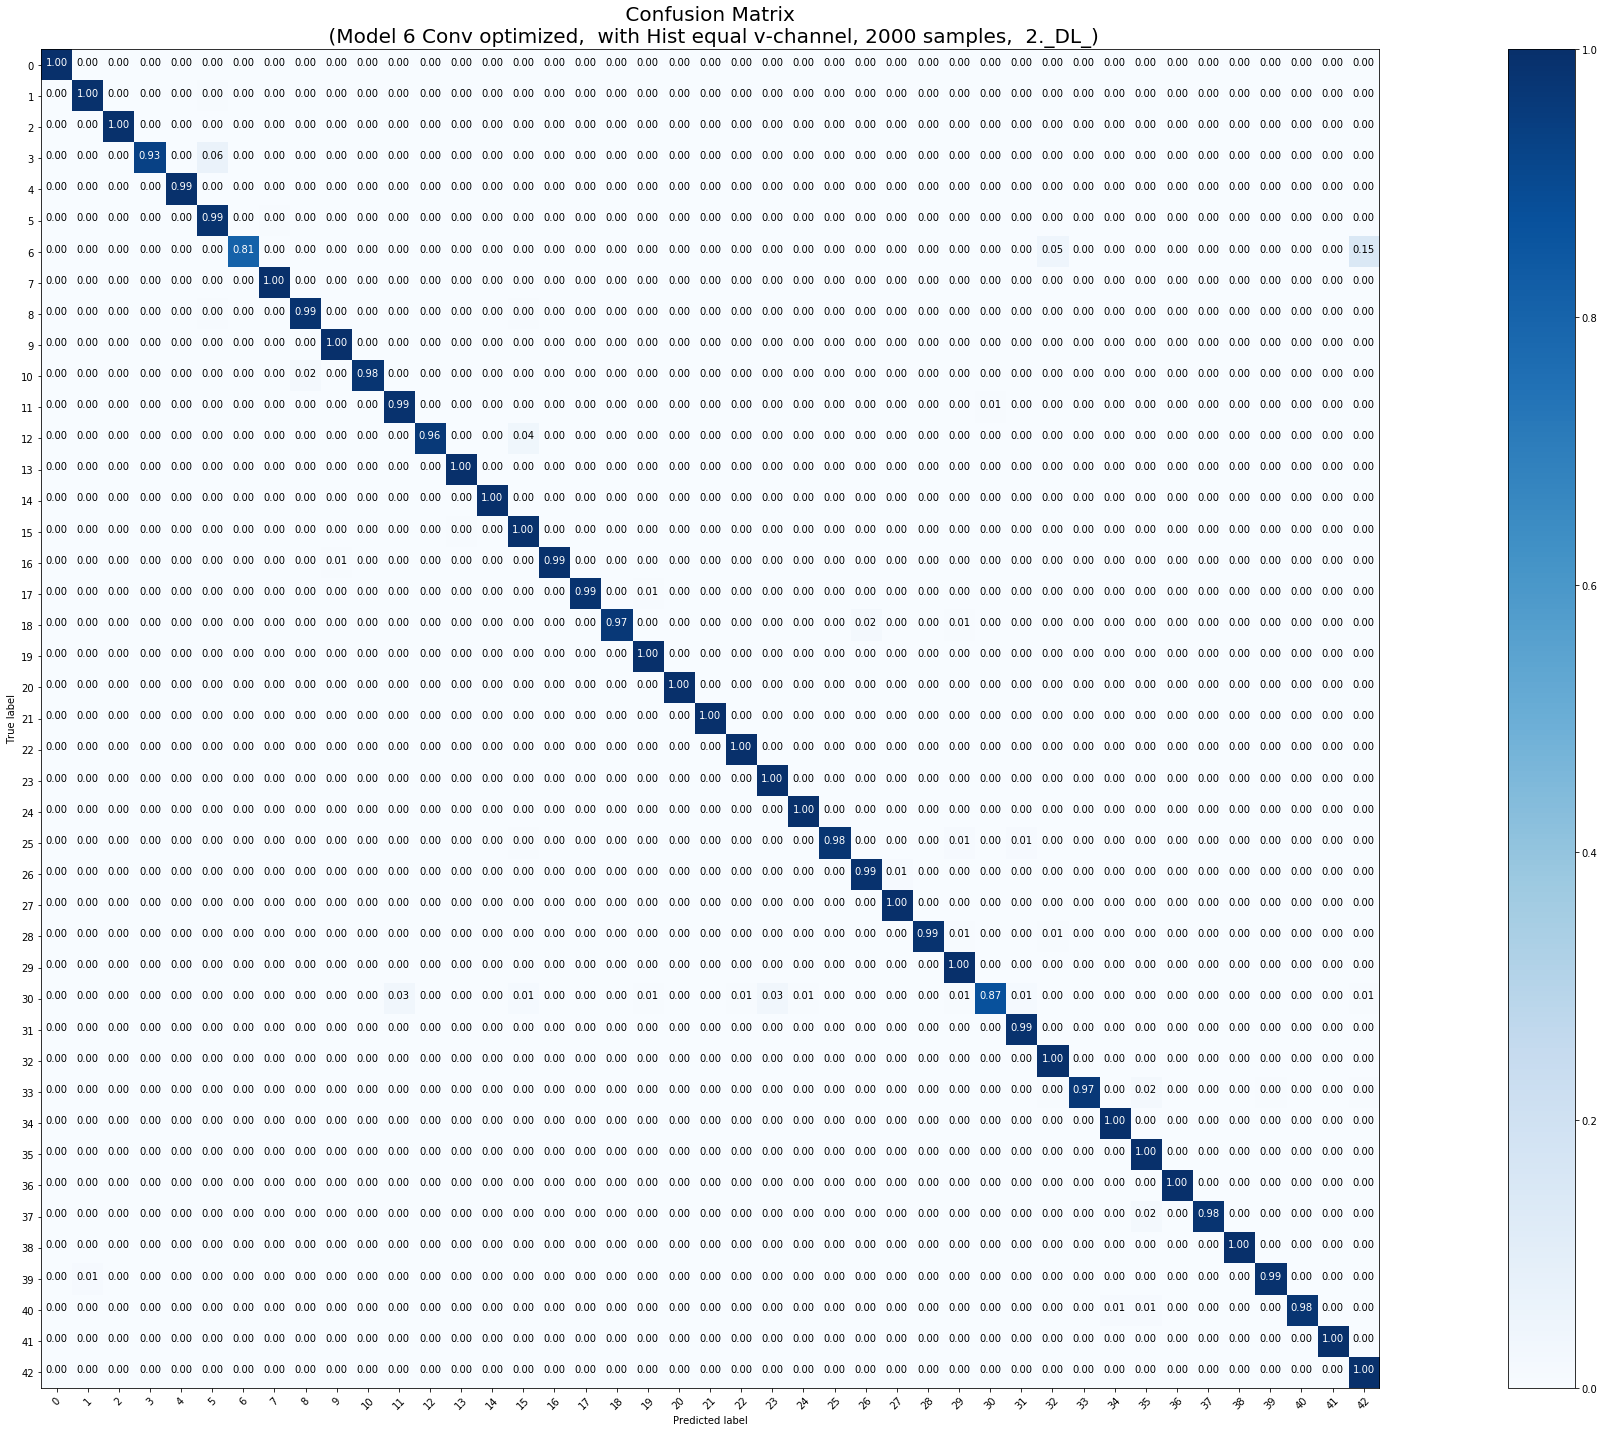

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 73s 60ms/step - loss: 0.7543 - acc: 0.7723 - val_loss: 0.1711 - val_acc: 0.9493
Epoch 2/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.1603 - acc: 0.9412 - val_loss: 0.1403 - val_acc: 0.9641
Epoch 3/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.1104 - acc: 0.9606 - val_loss: 0.1968 - val_acc: 0.9510
Epoch 4/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0866 - acc: 0.9672 - val_loss: 0.1713 - val_acc: 0.9525
Epoch 5/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0681 - acc: 0.9750 - val_loss: 0.0872 - val_acc: 0.9770
Epoch 6/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0635 - acc: 0.9768 - val_loss: 0.1036 - val_acc: 0.9713
Epoch 7/50
1226/1226 [==============================] - 71s

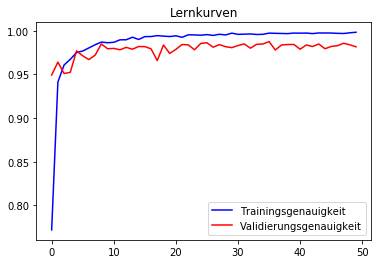

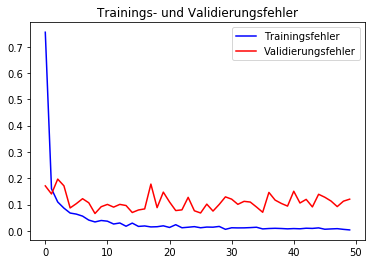

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.99      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.94      0.96       450
           4       1.00      0.99      0.99       660
           5       0.95      1.00      0.97       630
           6       0.98      0.87      0.92       150
           7       1.00      0.99      0.99       450
           8       0.97      0.99      0.98       450
           9       1.00      0.99      1.00       480
          10       1.00      0.99      0.99       660
          11       0.96      0.98      0.97       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.88      1.00      0.94       210
          16       1.00      1.00      1.00       

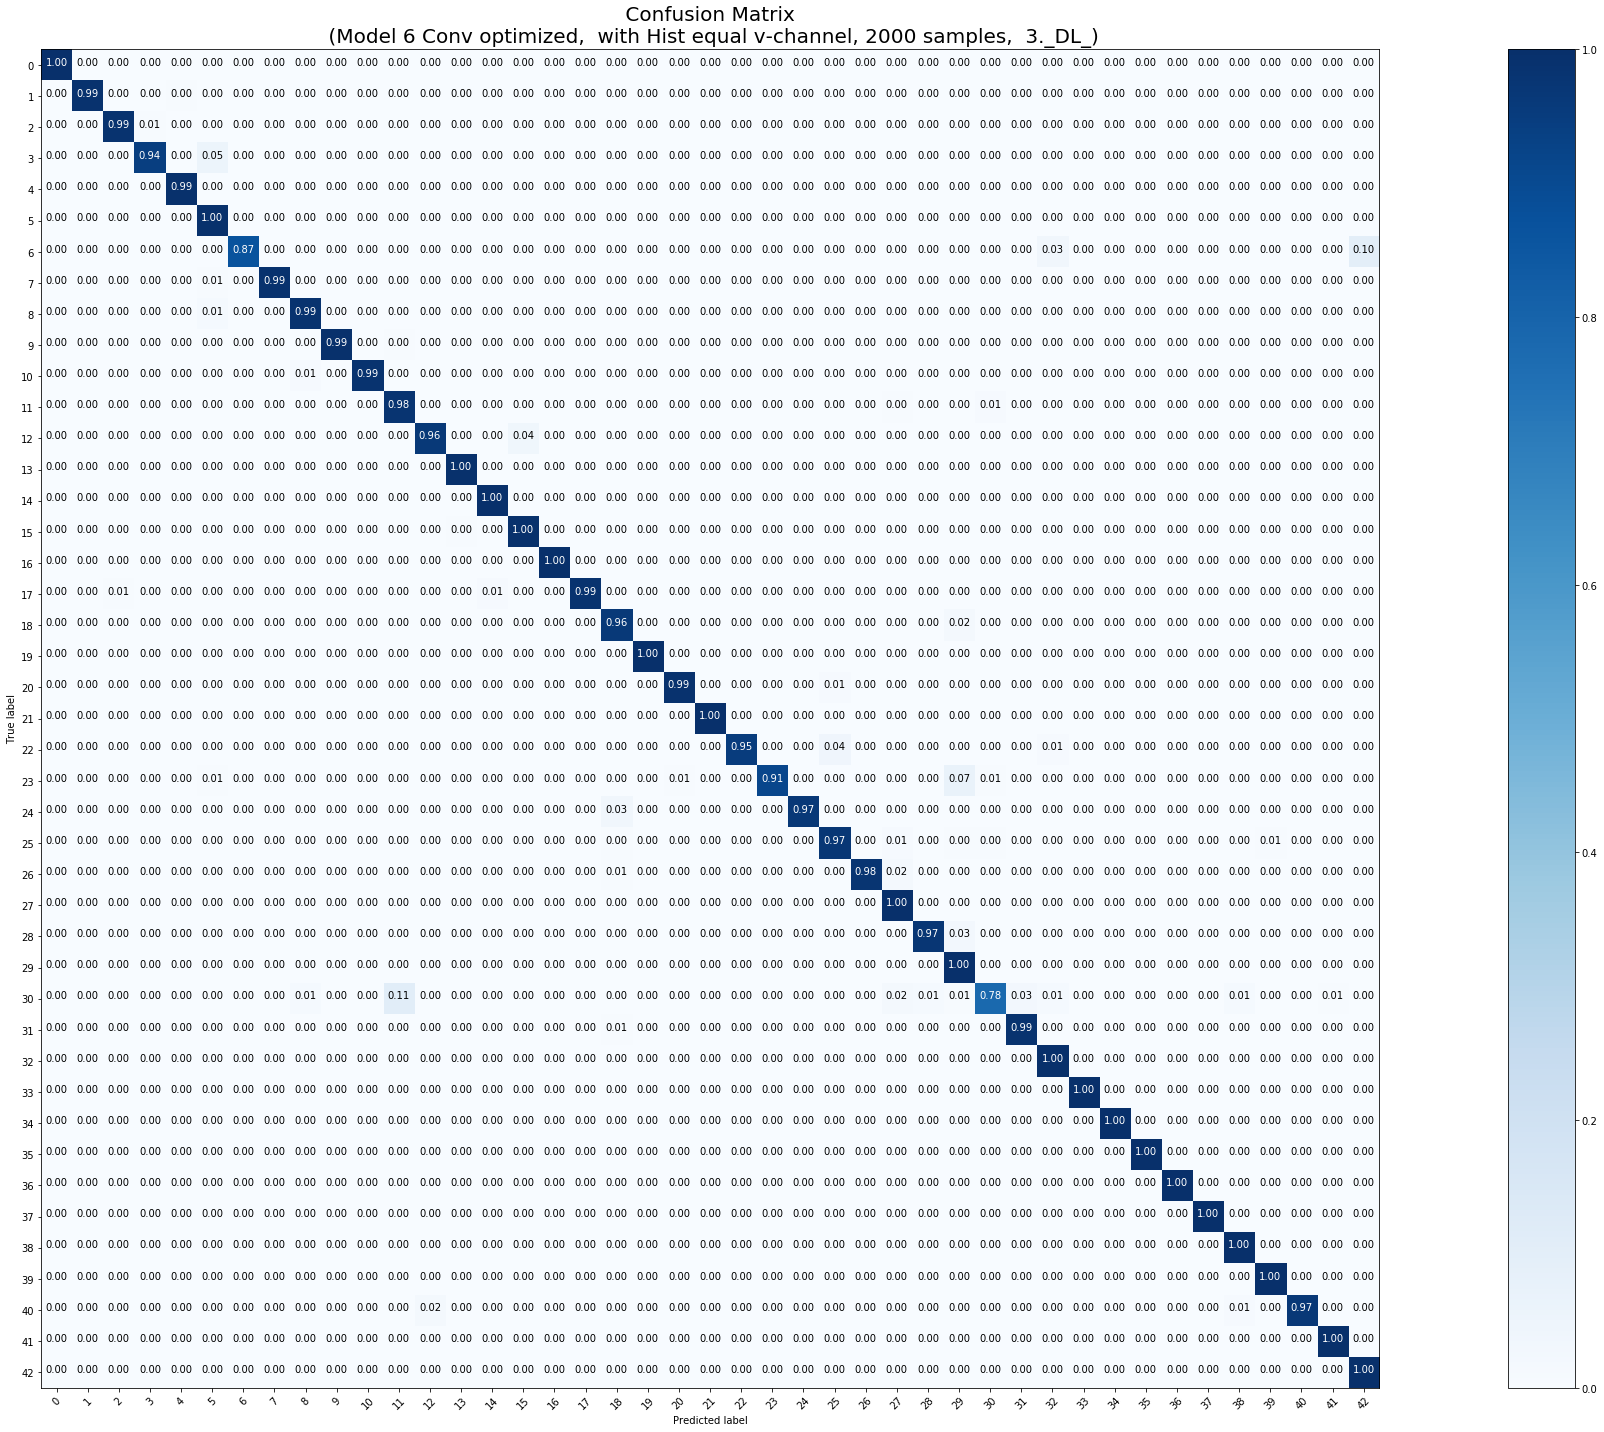

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 74s 61ms/step - loss: 0.7849 - acc: 0.7598 - val_loss: 0.1508 - val_acc: 0.9591
Epoch 2/50
1226/1226 [==============================] - 72s 58ms/step - loss: 0.1687 - acc: 0.9387 - val_loss: 0.1341 - val_acc: 0.9566
Epoch 3/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.1135 - acc: 0.9586 - val_loss: 0.1096 - val_acc: 0.9698
Epoch 4/50
1226/1226 [==============================] - 72s 58ms/step - loss: 0.0861 - acc: 0.9685 - val_loss: 0.0906 - val_acc: 0.9740
Epoch 5/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0685 - acc: 0.9741 - val_loss: 0.1033 - val_acc: 0.9689
Epoch 6/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0606 - acc: 0.9766 - val_loss: 0.0897 - val_acc: 0.9774
Epoch 7/50
1226/1226 [==============================] - 71s

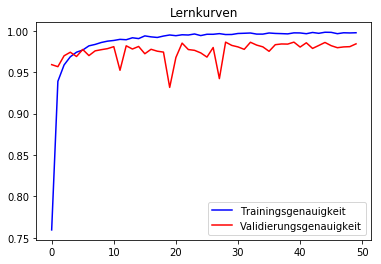

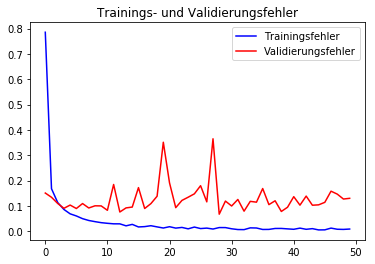

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.99      1.00       720
           2       0.98      1.00      0.99       750
           3       1.00      0.93      0.96       450
           4       1.00      0.99      0.99       660
           5       0.95      0.97      0.96       630
           6       1.00      0.83      0.91       150
           7       0.96      1.00      0.98       450
           8       0.99      0.99      0.99       450
           9       1.00      0.99      1.00       480
          10       1.00      0.99      1.00       660
          11       1.00      0.98      0.99       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.88      1.00      0.94       210
          16       1.00      1.00      1.00       

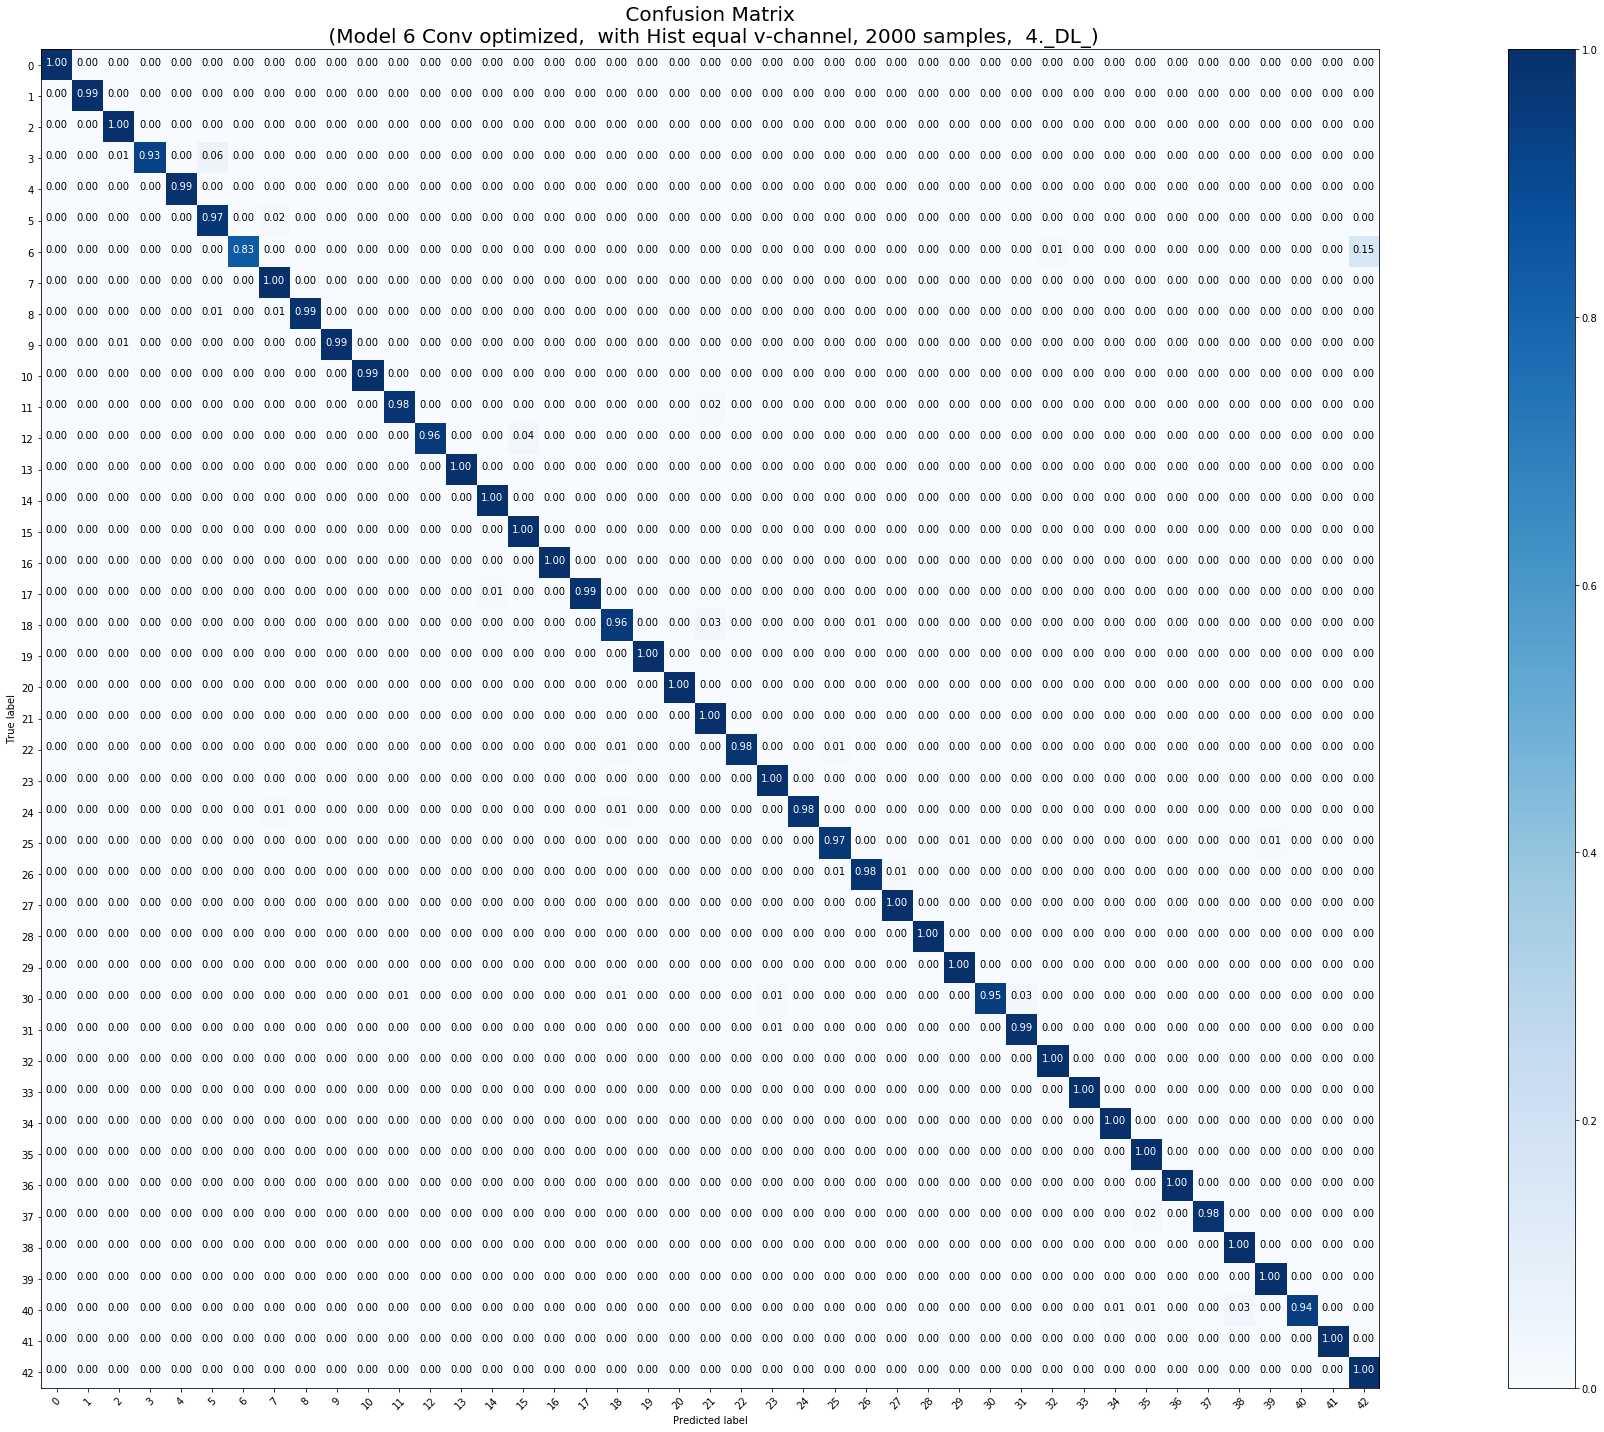

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 74s 61ms/step - loss: 0.7553 - acc: 0.7705 - val_loss: 0.1538 - val_acc: 0.9515
Epoch 2/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.1679 - acc: 0.9385 - val_loss: 0.1203 - val_acc: 0.9652
Epoch 3/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.1060 - acc: 0.9594 - val_loss: 0.1795 - val_acc: 0.9428
Epoch 4/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0938 - acc: 0.9653 - val_loss: 0.1012 - val_acc: 0.9707
Epoch 5/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0662 - acc: 0.9740 - val_loss: 0.1137 - val_acc: 0.9672
Epoch 6/50
1226/1226 [==============================] - 71s 58ms/step - loss: 0.0588 - acc: 0.9765 - val_loss: 0.1668 - val_acc: 0.9615
Epoch 7/50
1226/1226 [==============================] - 73s

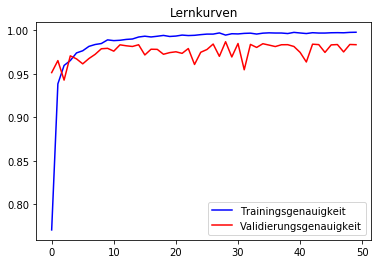

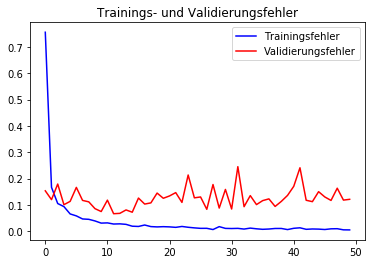

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.99      0.99       720
           2       0.98      0.99      0.99       750
           3       0.99      0.93      0.96       450
           4       1.00      0.99      1.00       660
           5       0.94      0.99      0.97       630
           6       1.00      0.83      0.91       150
           7       1.00      1.00      1.00       450
           8       0.98      0.98      0.98       450
           9       0.98      0.99      0.98       480
          10       1.00      0.99      0.99       660
          11       0.99      0.99      0.99       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.95      1.00      0.98       270
          15       0.86      1.00      0.92       210
          16       1.00      0.99      1.00       

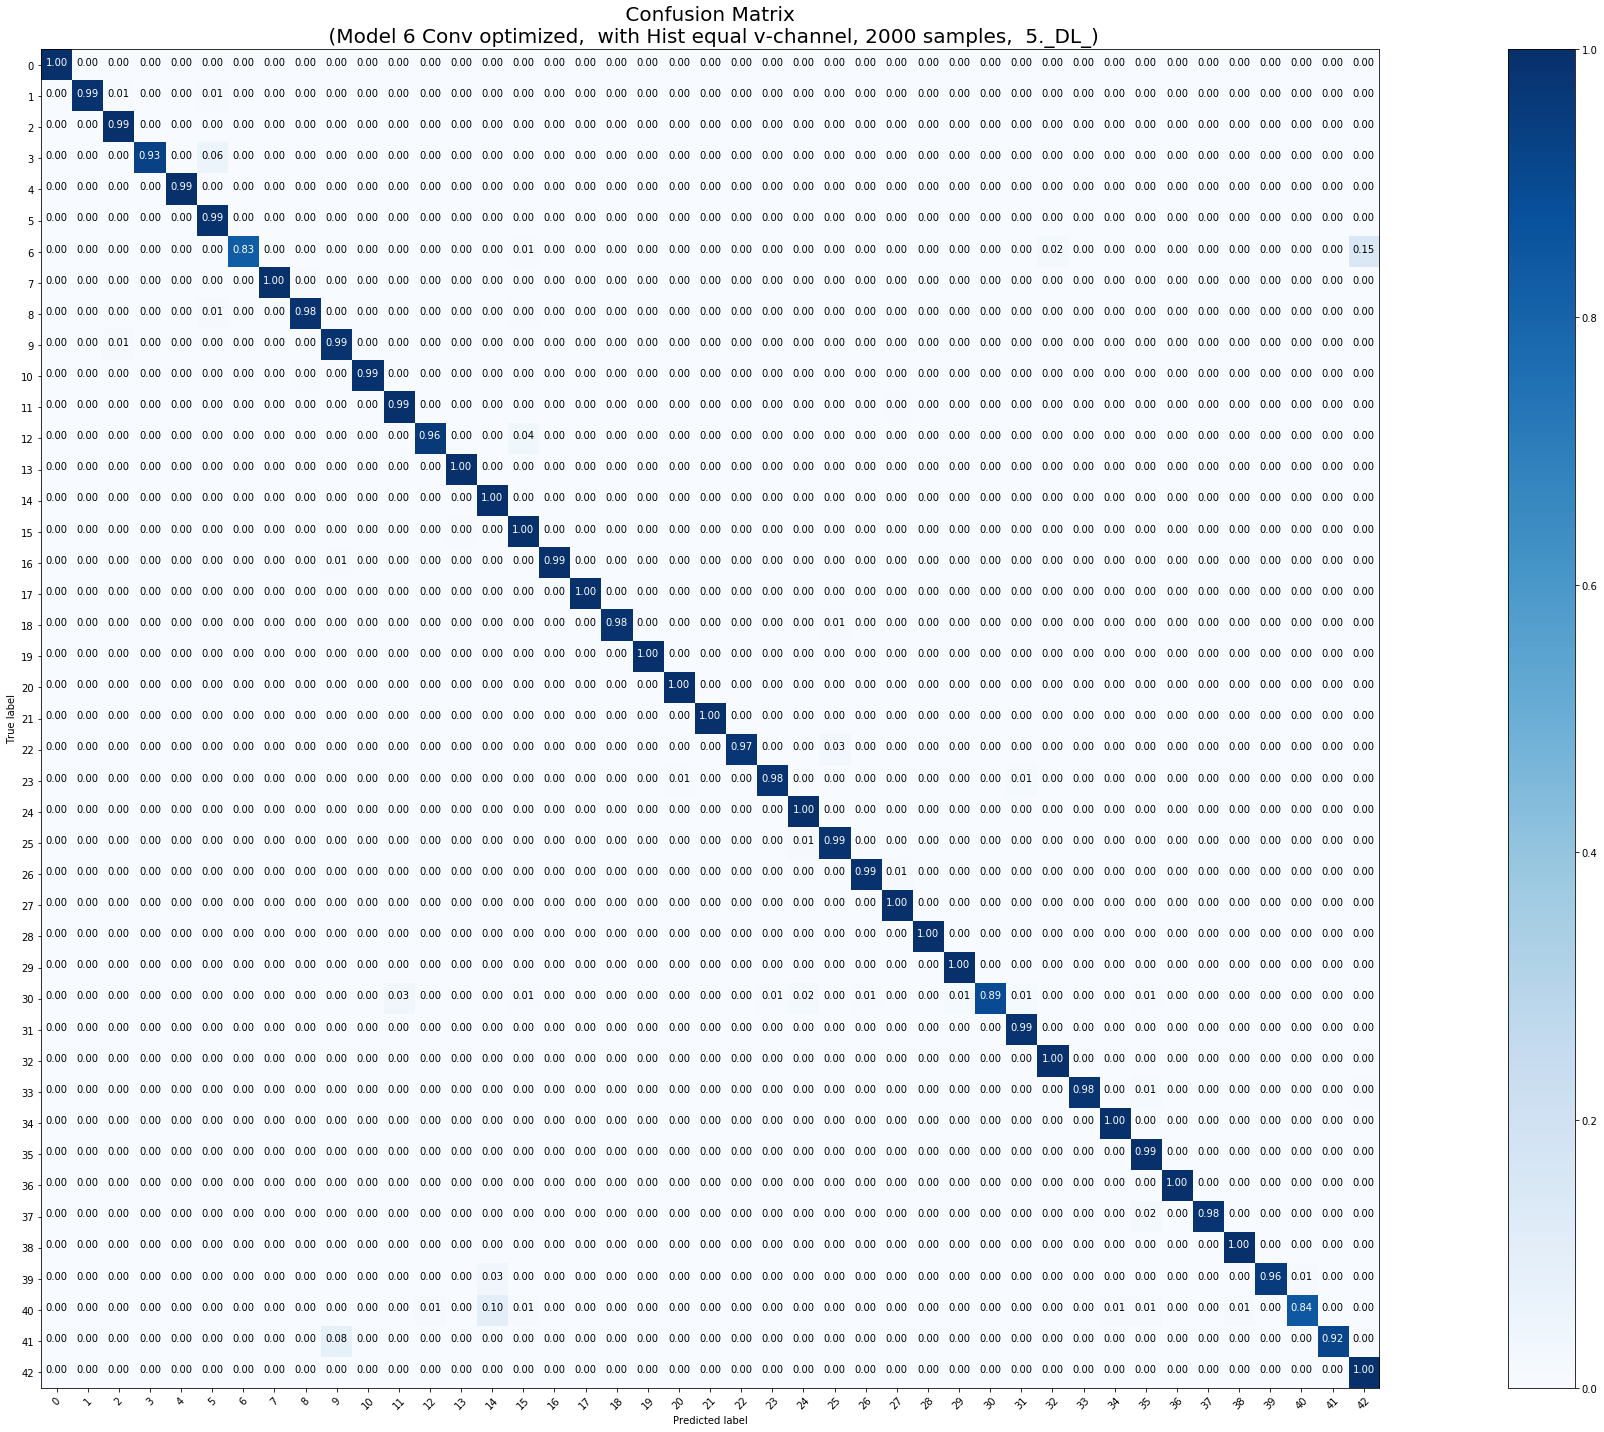

<Figure size 432x288 with 0 Axes>

In [0]:
# Trainingsmenge 2000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_2000, y_tr_2000, X_test, y_test, 0.2, 0.001, False, 2000)

In [0]:
downloader(1,5, 2000)

***************************************************************************** 
1 ._Trainingsdurchlauf
 










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Modell wurde erzeugt
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
1226/1226 [==============================] - 49s 40ms/step - loss: 0.8651 - acc: 0.7446 - val_loss: 0.1646 - val_acc: 0.9474
Epoch 2/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.2230 - acc: 0.9238 - val_loss: 0.1298 - val_acc: 0.9581
Epoch 3/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.1592 - acc: 0.9454 - val_loss: 0.0985 - val_acc: 0.9724
Epoch 4/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.1073 - acc: 0.9613 - val_loss: 0.1274 - val_acc: 0.9647
Epoch 5/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.1029 - acc: 0.9632 - val_los

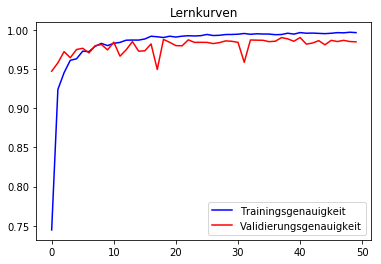

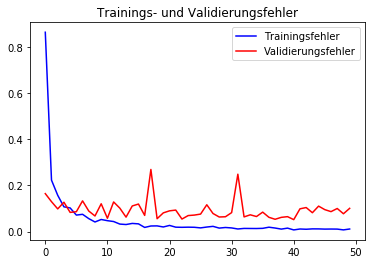

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.99      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      0.98      0.99       630
           6       0.99      0.81      0.89       150
           7       0.99      1.00      0.99       450
           8       0.99      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       0.99      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.88      1.00      0.94       210
          16       1.00      1.00      1.00       

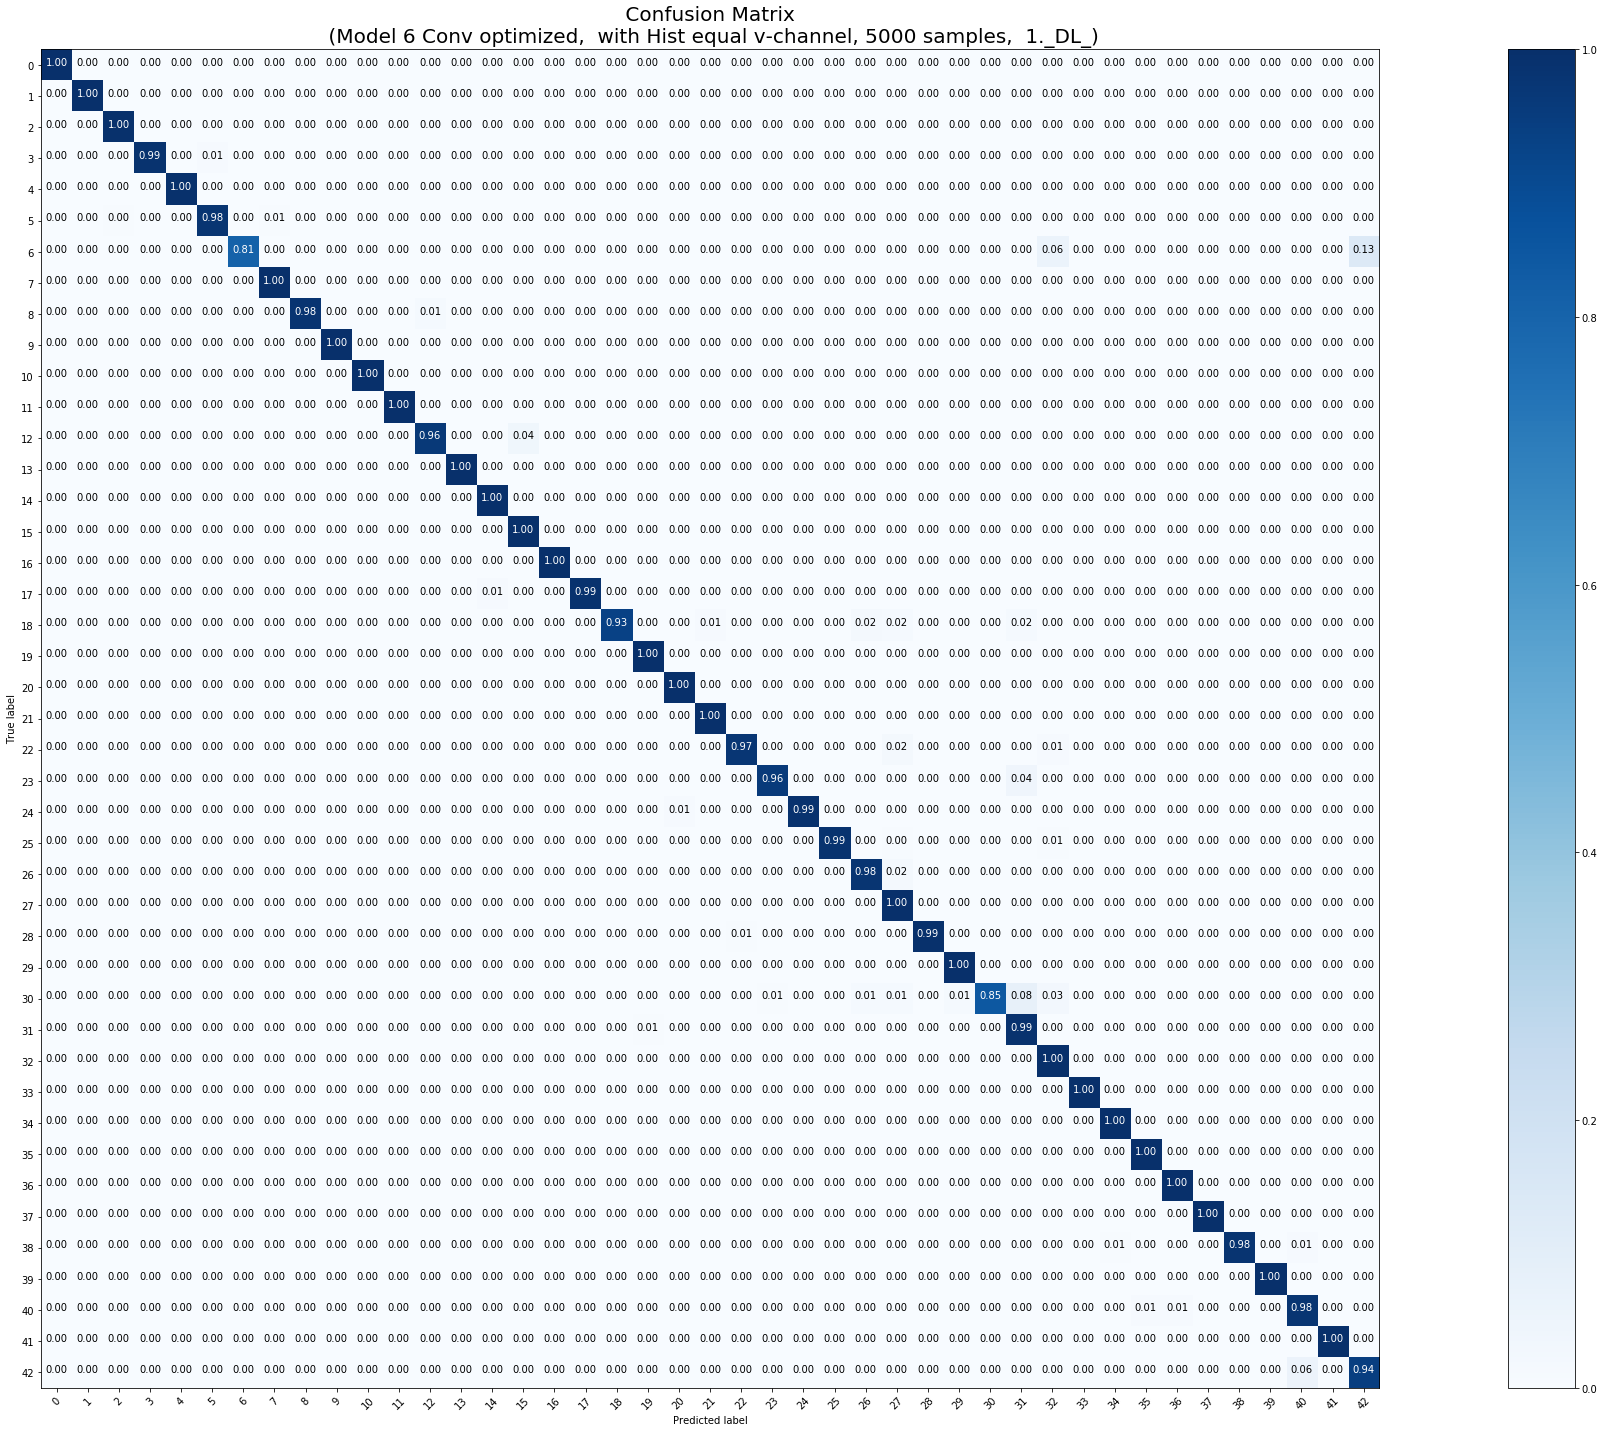

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 42s 35ms/step - loss: 0.8483 - acc: 0.7475 - val_loss: 0.1168 - val_acc: 0.9655
Epoch 2/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.2292 - acc: 0.9222 - val_loss: 0.1132 - val_acc: 0.9667
Epoch 3/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.1395 - acc: 0.9508 - val_loss: 0.1099 - val_acc: 0.9684
Epoch 4/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.1115 - acc: 0.9584 - val_loss: 0.0959 - val_acc: 0.9728
Epoch 5/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.0852 - acc: 0.9670 - val_loss: 0.1045 - val_acc: 0.9705
Epoch 6/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.0931 - acc: 0.9690 - val_loss: 0.0822 - val_acc: 0.9749
Epoch 7/50
1226/1226 [==============================] - 40s

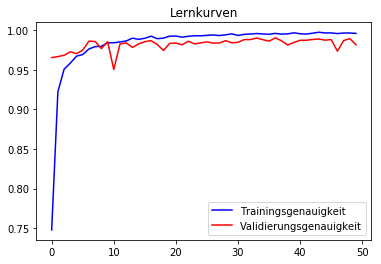

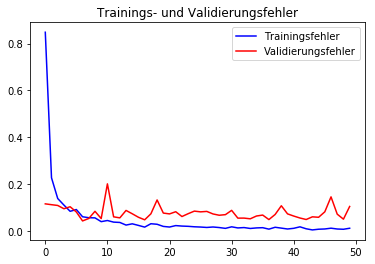

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       1.00      0.96      0.98       450
           4       0.99      0.99      0.99       660
           5       0.98      0.97      0.98       630
           6       1.00      0.80      0.89       150
           7       0.99      1.00      0.99       450
           8       0.93      0.99      0.95       450
           9       0.99      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       1.00      0.97      0.98       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       0.89      1.00      0.94       210
          16       1.00      0.99      1.00       

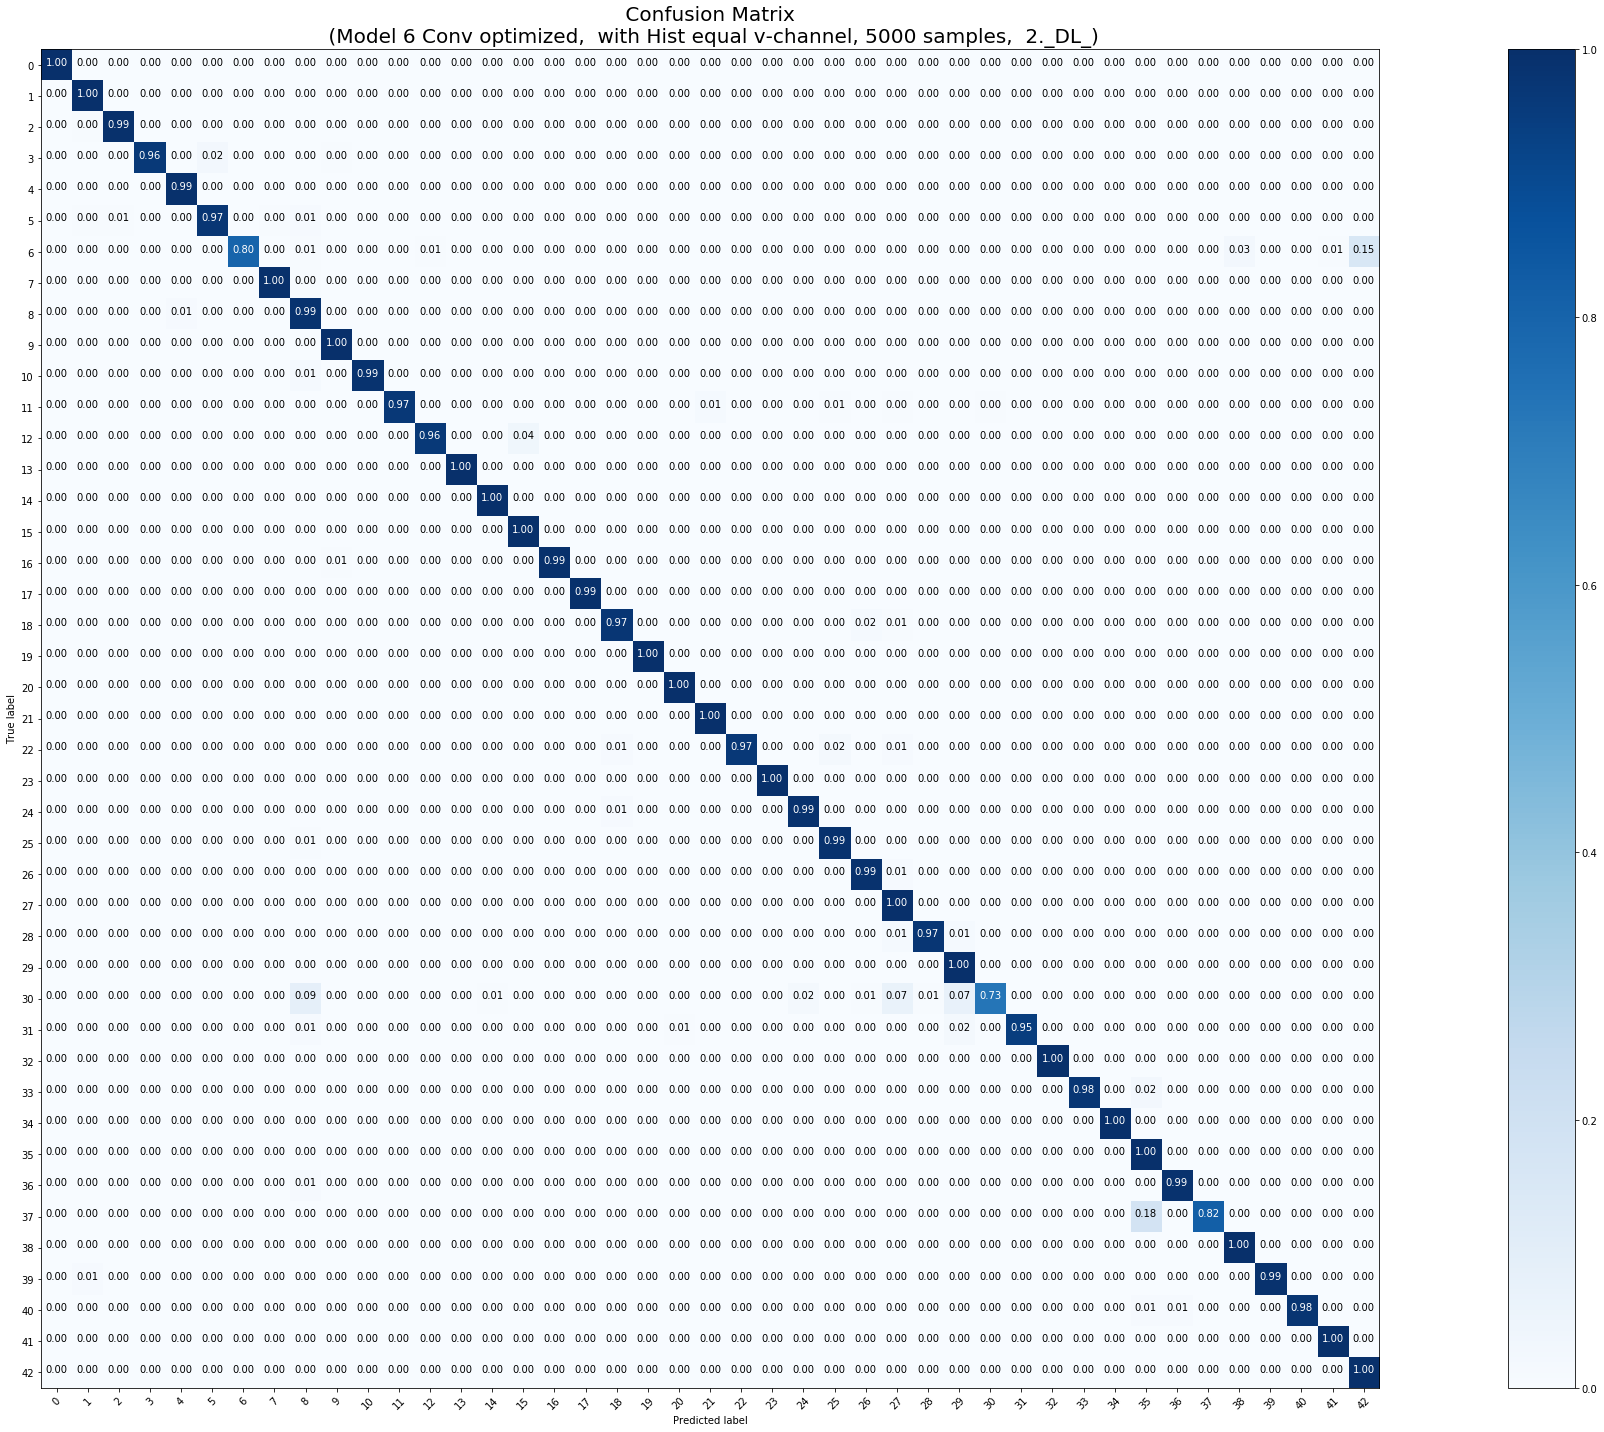

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.8502 - acc: 0.7500 - val_loss: 0.1624 - val_acc: 0.9461
Epoch 2/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.2270 - acc: 0.9198 - val_loss: 0.1481 - val_acc: 0.9517
Epoch 3/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.1563 - acc: 0.9442 - val_loss: 0.1691 - val_acc: 0.9470
Epoch 4/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.1112 - acc: 0.9602 - val_loss: 0.0629 - val_acc: 0.9814
Epoch 5/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.0895 - acc: 0.9660 - val_loss: 0.1215 - val_acc: 0.9629
Epoch 6/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.0944 - acc: 0.9656 - val_loss: 0.0657 - val_acc: 0.9802
Epoch 7/50
1226/1226 [==============================] - 41s

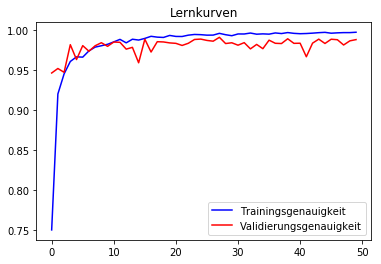

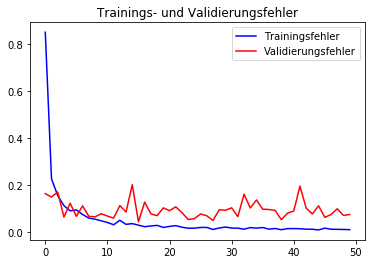

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.99      0.98      0.98       450
           4       1.00      0.99      1.00       660
           5       0.98      0.99      0.99       630
           6       1.00      0.88      0.94       150
           7       1.00      1.00      1.00       450
           8       0.98      1.00      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       0.98      1.00      0.99       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       0.89      1.00      0.94       210
          16       0.99      0.99      0.99       

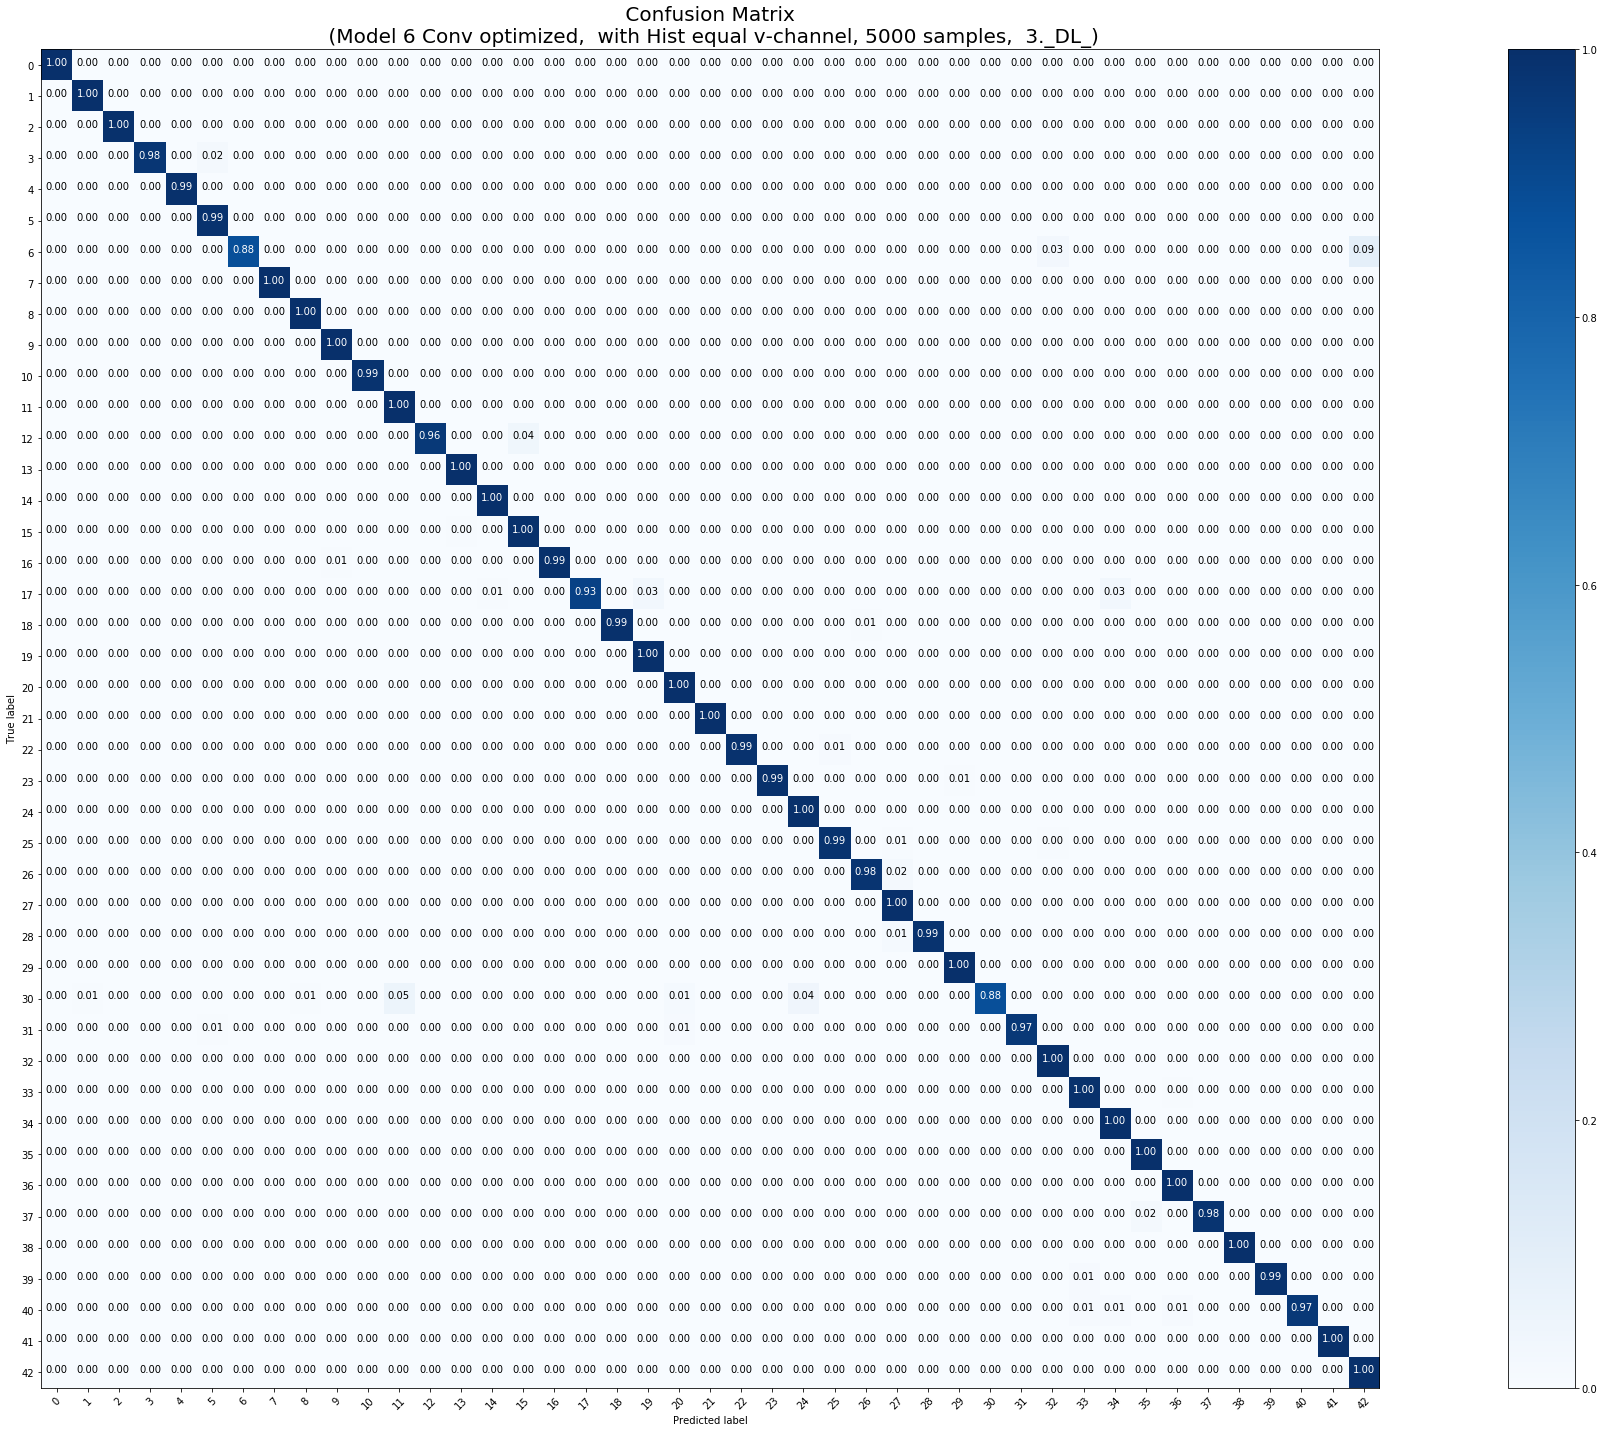

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.8673 - acc: 0.7417 - val_loss: 0.1571 - val_acc: 0.9473
Epoch 2/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.2091 - acc: 0.9284 - val_loss: 0.1089 - val_acc: 0.9668
Epoch 3/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.1448 - acc: 0.9487 - val_loss: 0.0945 - val_acc: 0.9698
Epoch 4/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.1181 - acc: 0.9602 - val_loss: 0.1499 - val_acc: 0.9511
Epoch 5/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.0901 - acc: 0.9678 - val_loss: 0.0972 - val_acc: 0.9708
Epoch 6/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.0796 - acc: 0.9709 - val_loss: 0.0546 - val_acc: 0.9838
Epoch 7/50
1226/1226 [==============================] - 40s

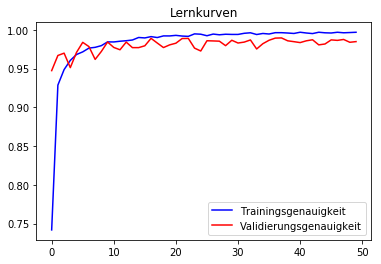

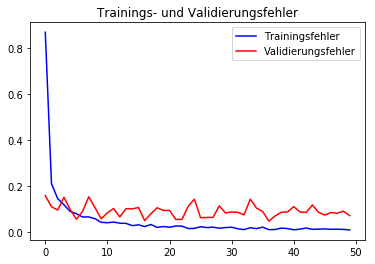

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.99      0.99       660
           5       0.99      0.98      0.98       630
           6       0.99      0.84      0.91       150
           7       0.99      1.00      0.99       450
           8       0.97      0.99      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.97      0.98       660
          11       0.96      1.00      0.98       420
          12       1.00      0.97      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.89      1.00      0.94       210
          16       0.98      1.00      0.99       

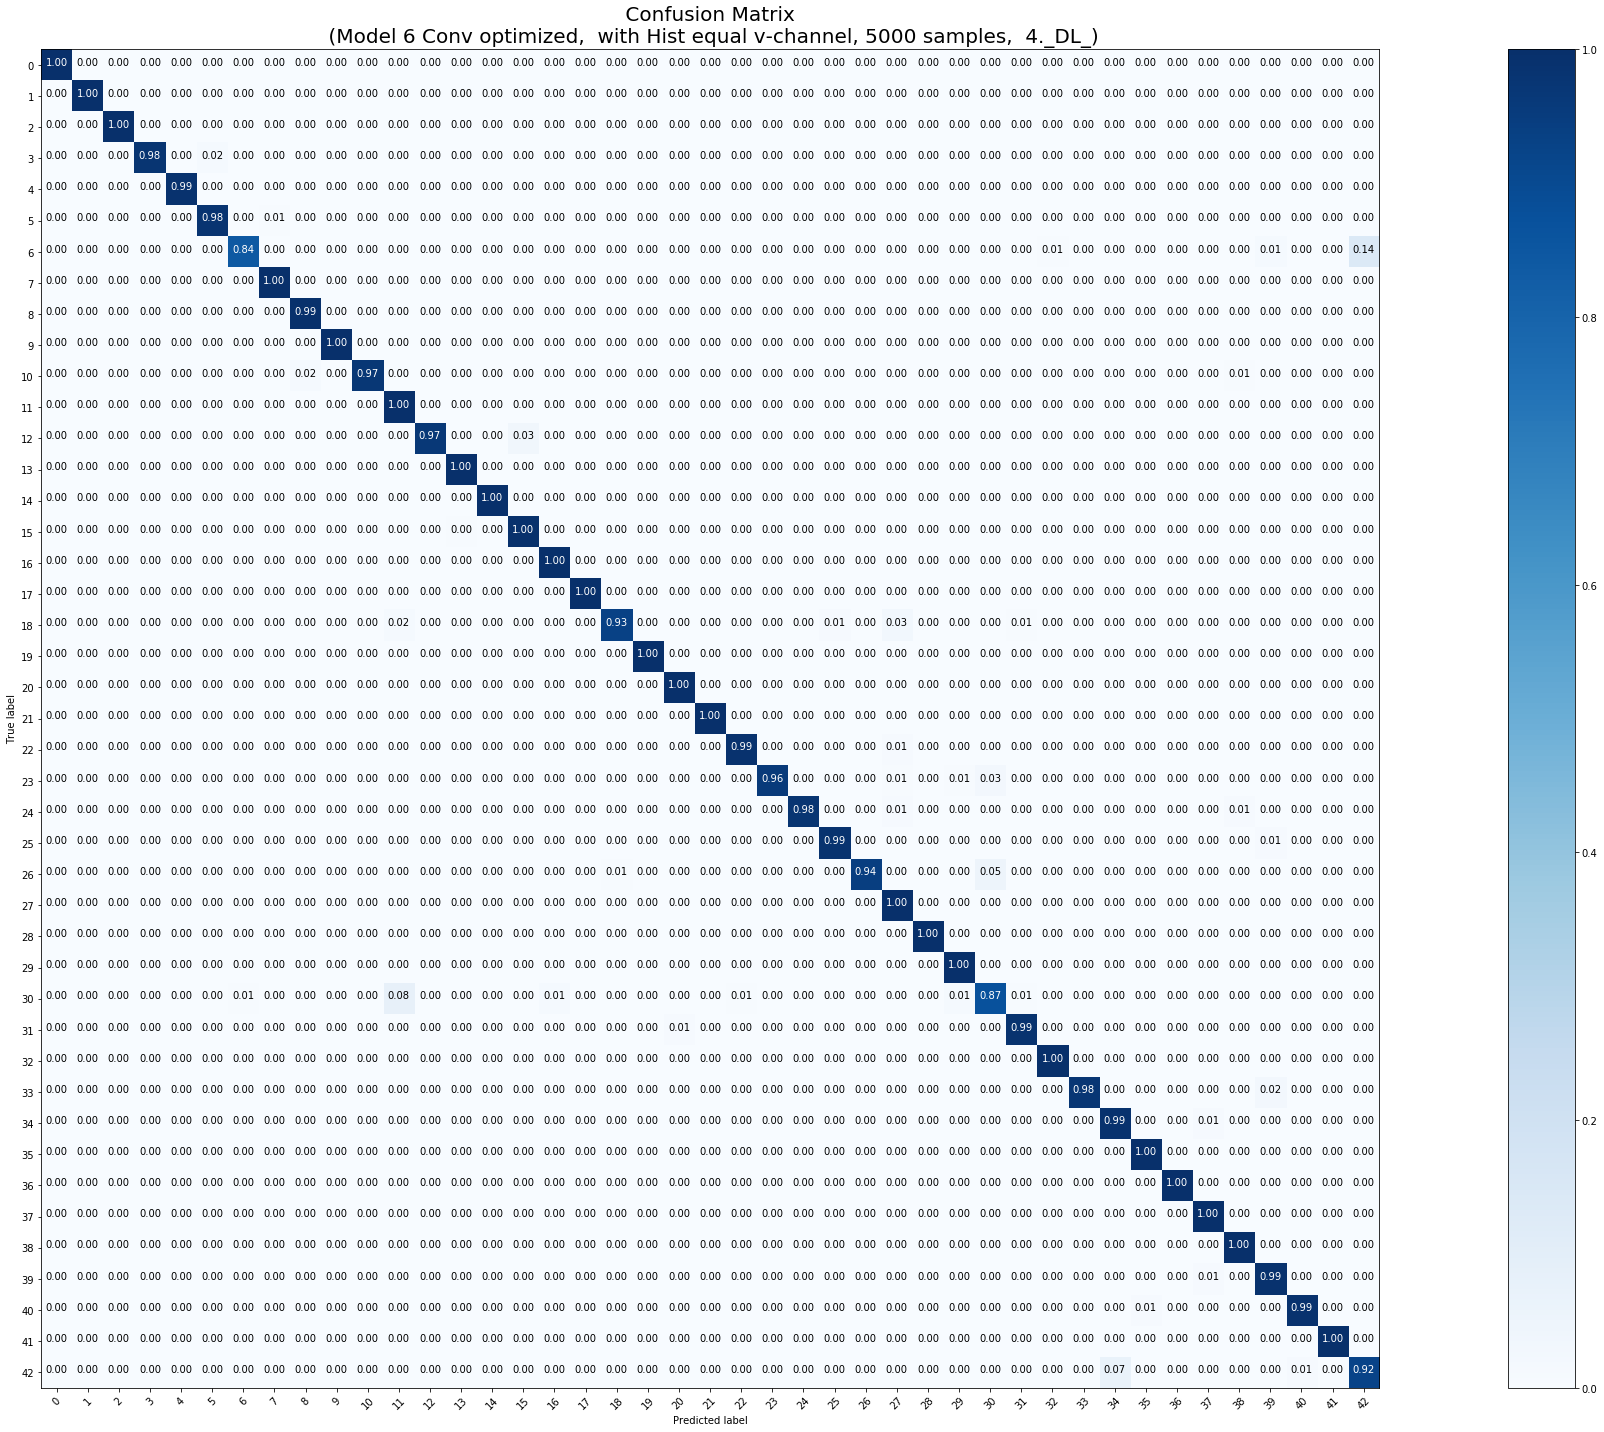

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.8756 - acc: 0.7435 - val_loss: 0.1438 - val_acc: 0.9549
Epoch 2/50
1226/1226 [==============================] - 40s 33ms/step - loss: 0.2164 - acc: 0.9236 - val_loss: 0.1565 - val_acc: 0.9500
Epoch 3/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.1366 - acc: 0.9525 - val_loss: 0.1427 - val_acc: 0.9538
Epoch 4/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.1034 - acc: 0.9629 - val_loss: 0.1050 - val_acc: 0.9680
Epoch 5/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.0899 - acc: 0.9660 - val_loss: 0.2319 - val_acc: 0.9488
Epoch 6/50
1226/1226 [==============================] - 39s 32ms/step - loss: 0.0737 - acc: 0.9730 - val_loss: 0.0984 - val_acc: 0.9727
Epoch 7/50
1226/1226 [==============================] - 39s

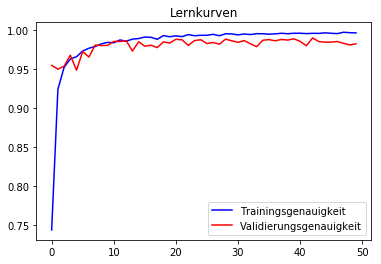

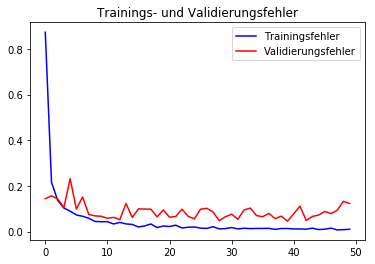

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.98      0.98      0.98       450
           4       1.00      0.99      0.99       660
           5       0.99      0.96      0.98       630
           6       1.00      0.80      0.89       150
           7       0.99      1.00      0.99       450
           8       0.96      0.98      0.97       450
           9       0.99      1.00      0.99       480
          10       1.00      0.96      0.98       660
          11       1.00      0.96      0.98       420
          12       1.00      0.97      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.88      1.00      0.93       210
          16       0.98      0.99      0.99       

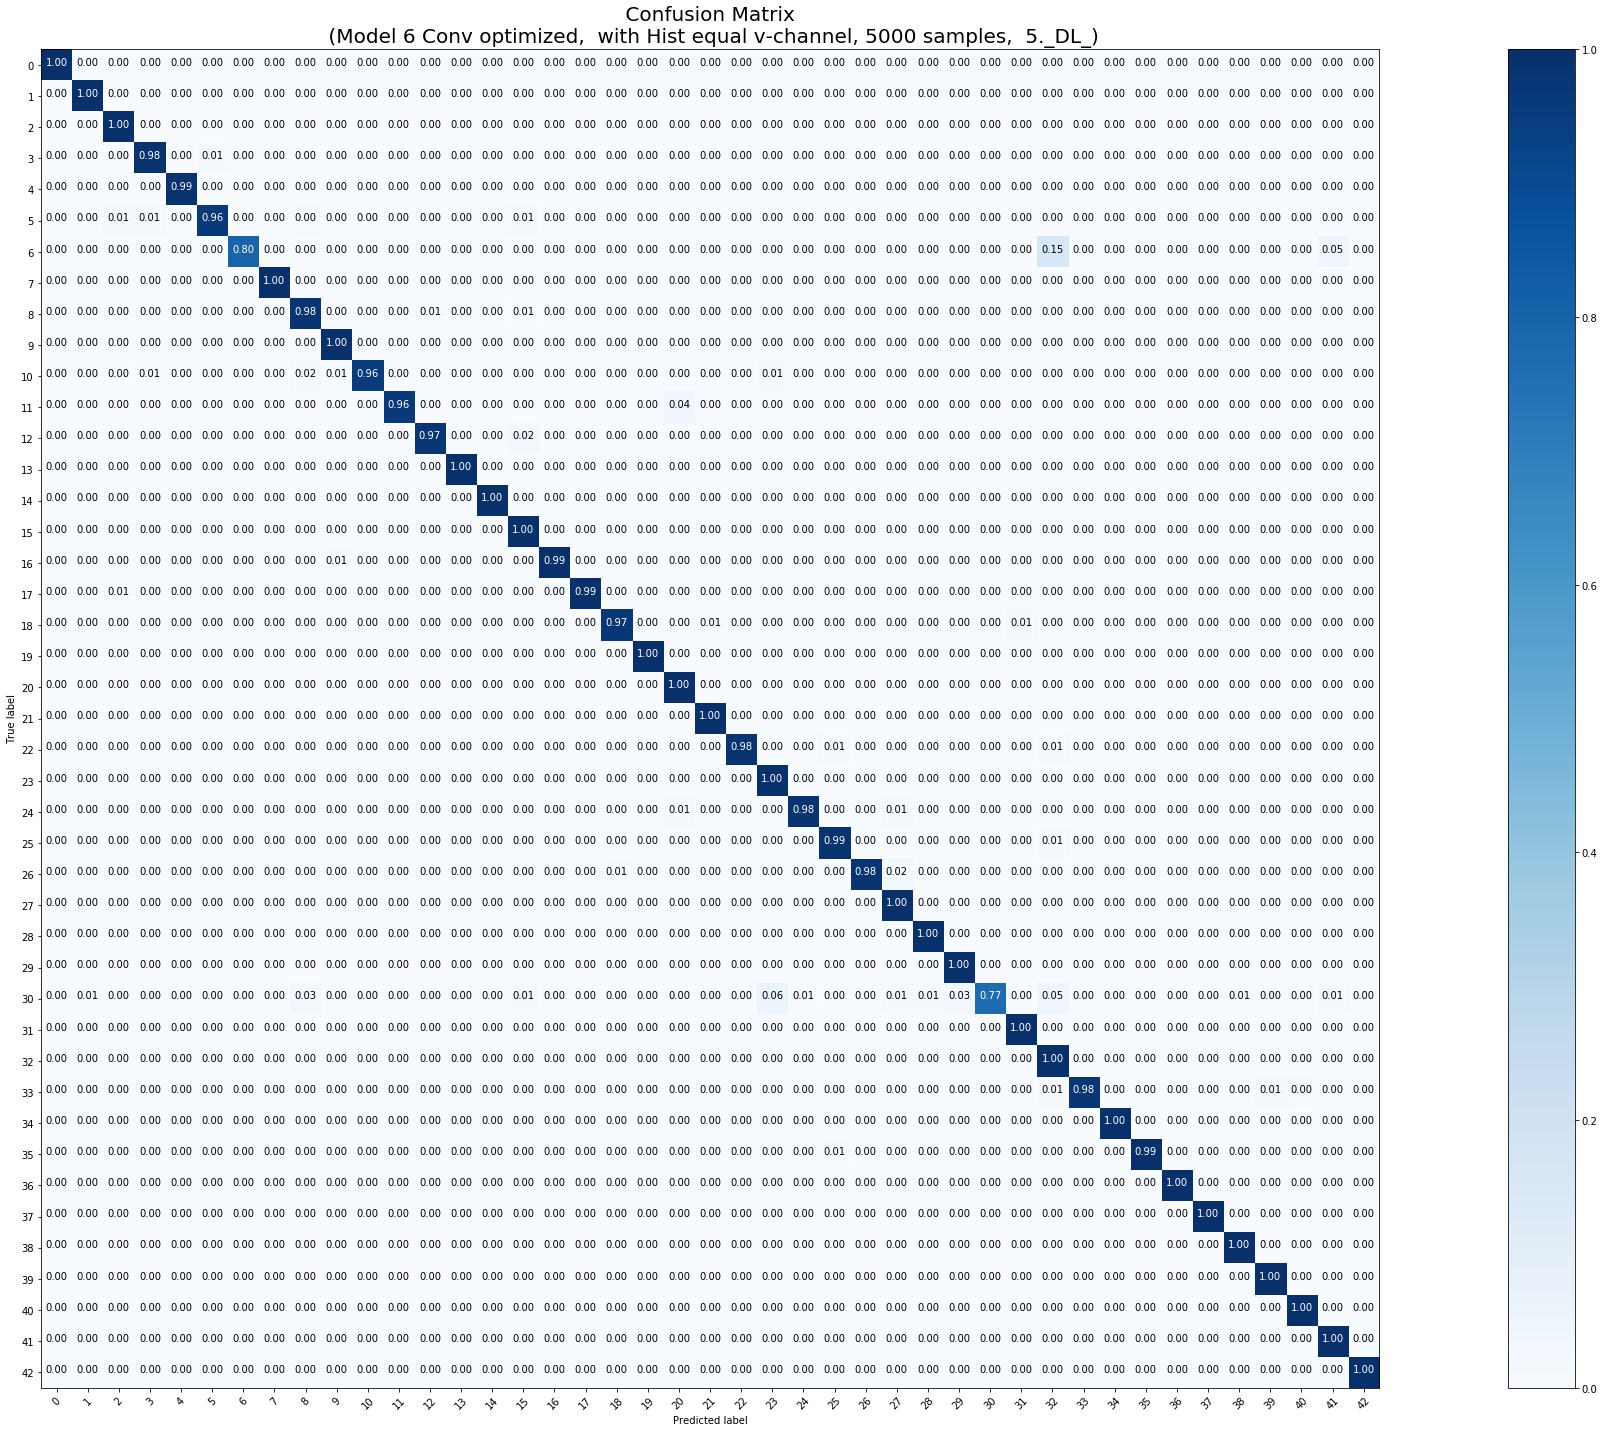

<Figure size 432x288 with 0 Axes>

In [0]:
# Trainingsmenge 5000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_5000, y_tr_5000, X_test, y_test, 0.2, 0.001, False, 5000)

In [0]:
downloader(1,5,5000)

***************************************************************************** 
1 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.8646 - acc: 0.7467 - val_loss: 0.2455 - val_acc: 0.9192
Epoch 2/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.2274 - acc: 0.9225 - val_loss: 0.1073 - val_acc: 0.9653
Epoch 3/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.1532 - acc: 0.9458 - val_loss: 0.1152 - val_acc: 0.9652
Epoch 4/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.1291 - acc: 0.9573 - val_loss: 0.1569 - val_acc: 0.9579
Epoch 5/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.1041 - acc: 0.9630 - val_loss: 0.0910 - val_acc: 0.9744
Epoch 6/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.0805 - acc: 0.9704 - val_loss: 0.0614 - val_acc: 0.9829
Epoch 7/50
1226/1226 [==============================] - 42s

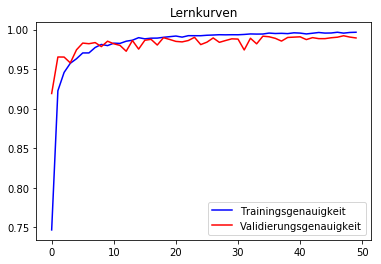

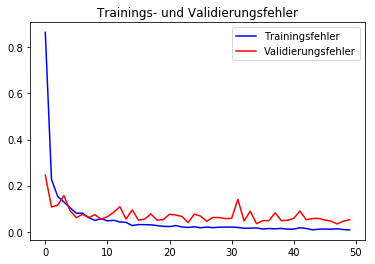

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       0.98      1.00      0.99       750
           3       1.00      0.96      0.98       450
           4       1.00      1.00      1.00       660
           5       0.98      0.98      0.98       630
           6       1.00      0.88      0.94       150
           7       1.00      1.00      1.00       450
           8       0.99      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       1.00      0.98      0.99       420
          12       0.99      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16       1.00      0.99      1.00       

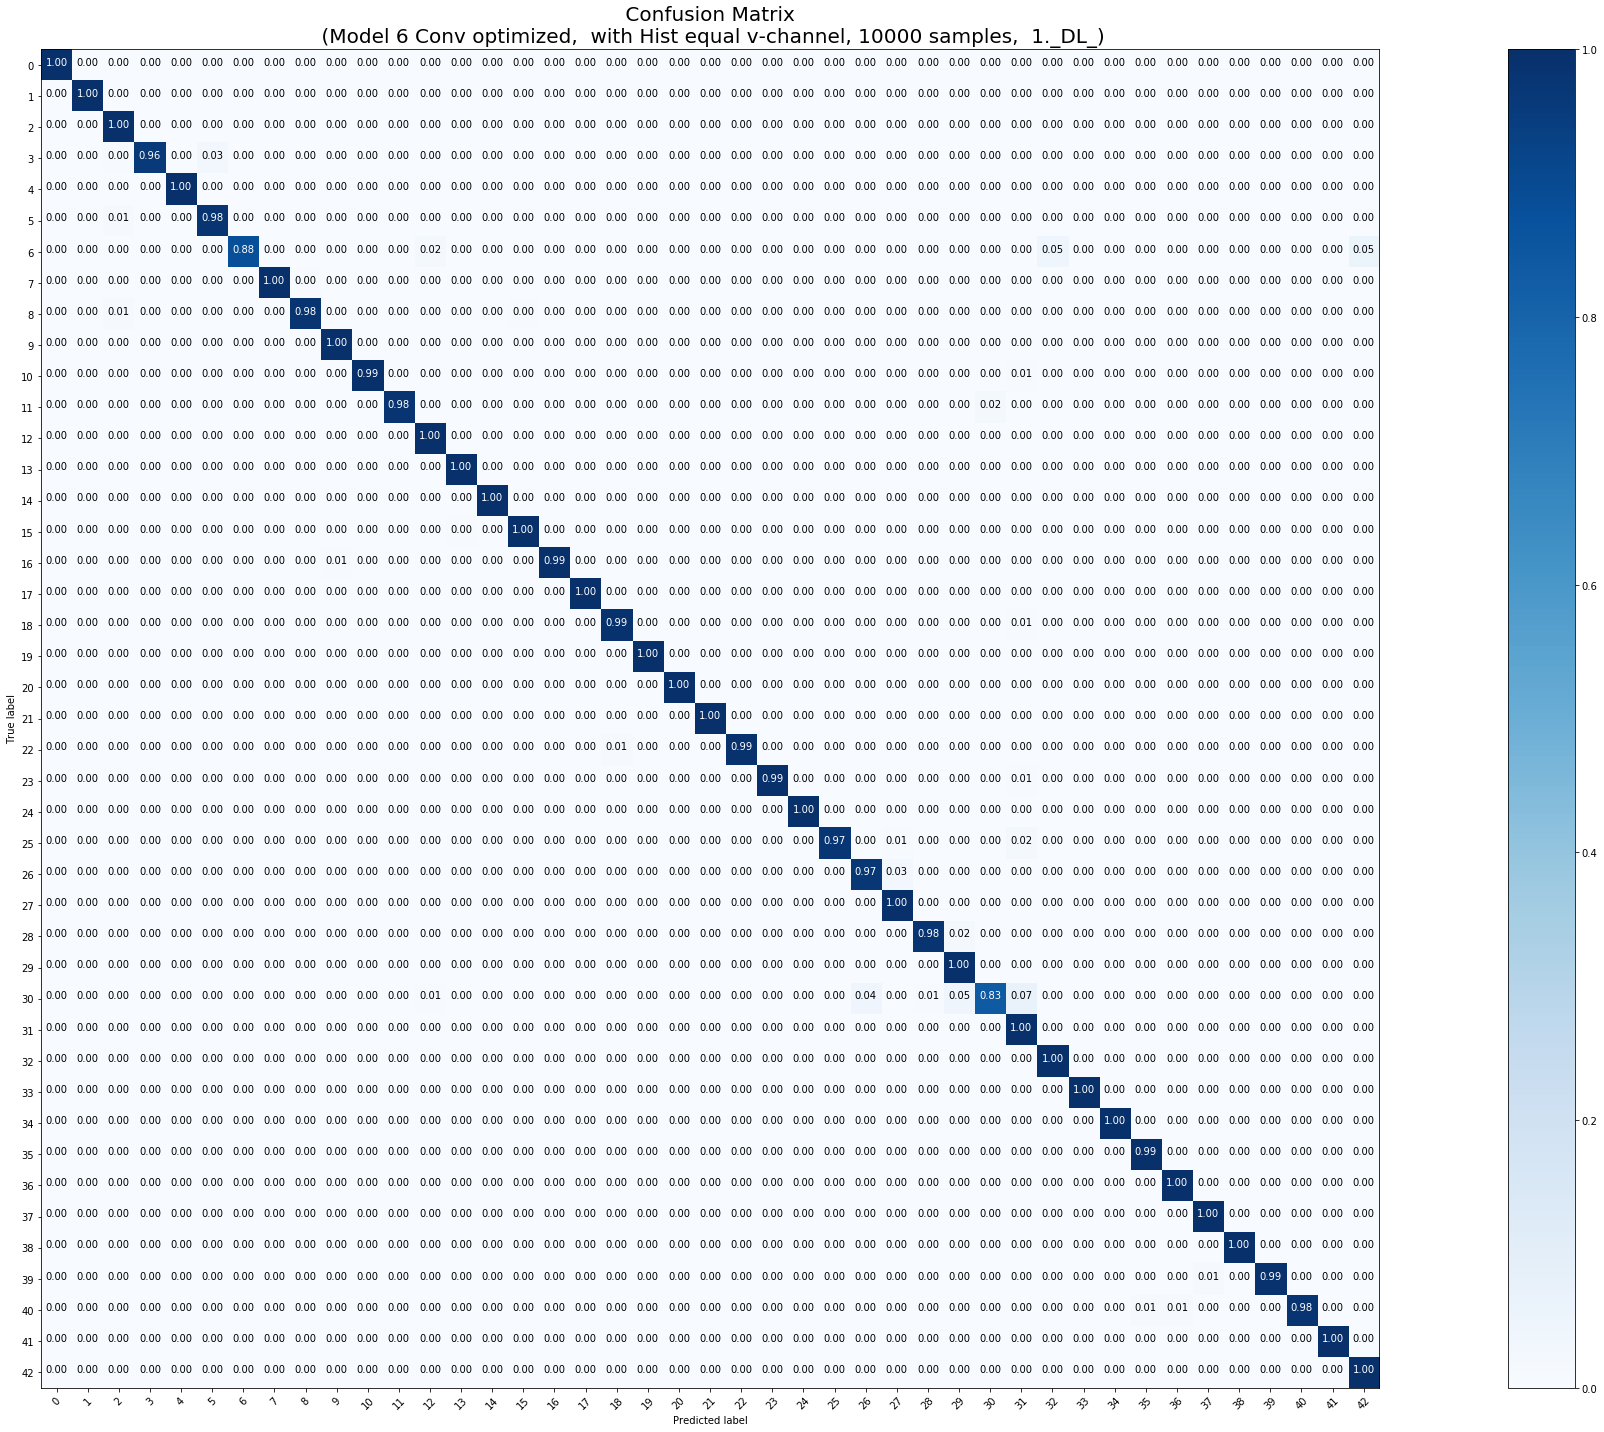

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 45s 37ms/step - loss: 0.8657 - acc: 0.7435 - val_loss: 0.1618 - val_acc: 0.9523
Epoch 2/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.2406 - acc: 0.9209 - val_loss: 0.1026 - val_acc: 0.9687
Epoch 3/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.1679 - acc: 0.9448 - val_loss: 0.1527 - val_acc: 0.9548
Epoch 4/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.1245 - acc: 0.9561 - val_loss: 0.1432 - val_acc: 0.9658
Epoch 5/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.0998 - acc: 0.9638 - val_loss: 0.0555 - val_acc: 0.9833
Epoch 6/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.0858 - acc: 0.9683 - val_loss: 0.0586 - val_acc: 0.9831
Epoch 7/50
1226/1226 [==============================] - 40s

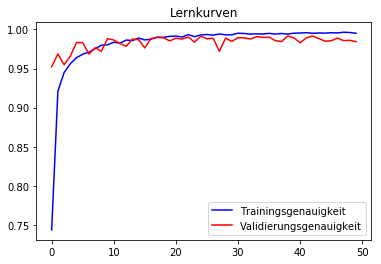

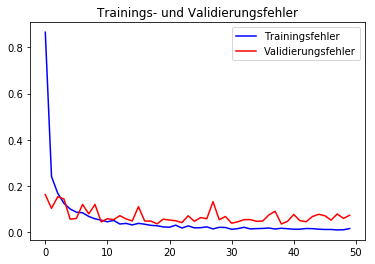

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00       720
           2       1.00      0.99      0.99       750
           3       0.99      0.98      0.99       450
           4       1.00      0.99      0.99       660
           5       0.99      0.98      0.99       630
           6       1.00      0.81      0.89       150
           7       0.99      0.99      0.99       450
           8       0.97      0.96      0.96       450
           9       0.99      1.00      0.99       480
          10       1.00      0.97      0.98       660
          11       1.00      0.99      0.99       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      1.00      0.99       270
          15       0.97      1.00      0.98       210
          16       0.99      0.99      0.99       

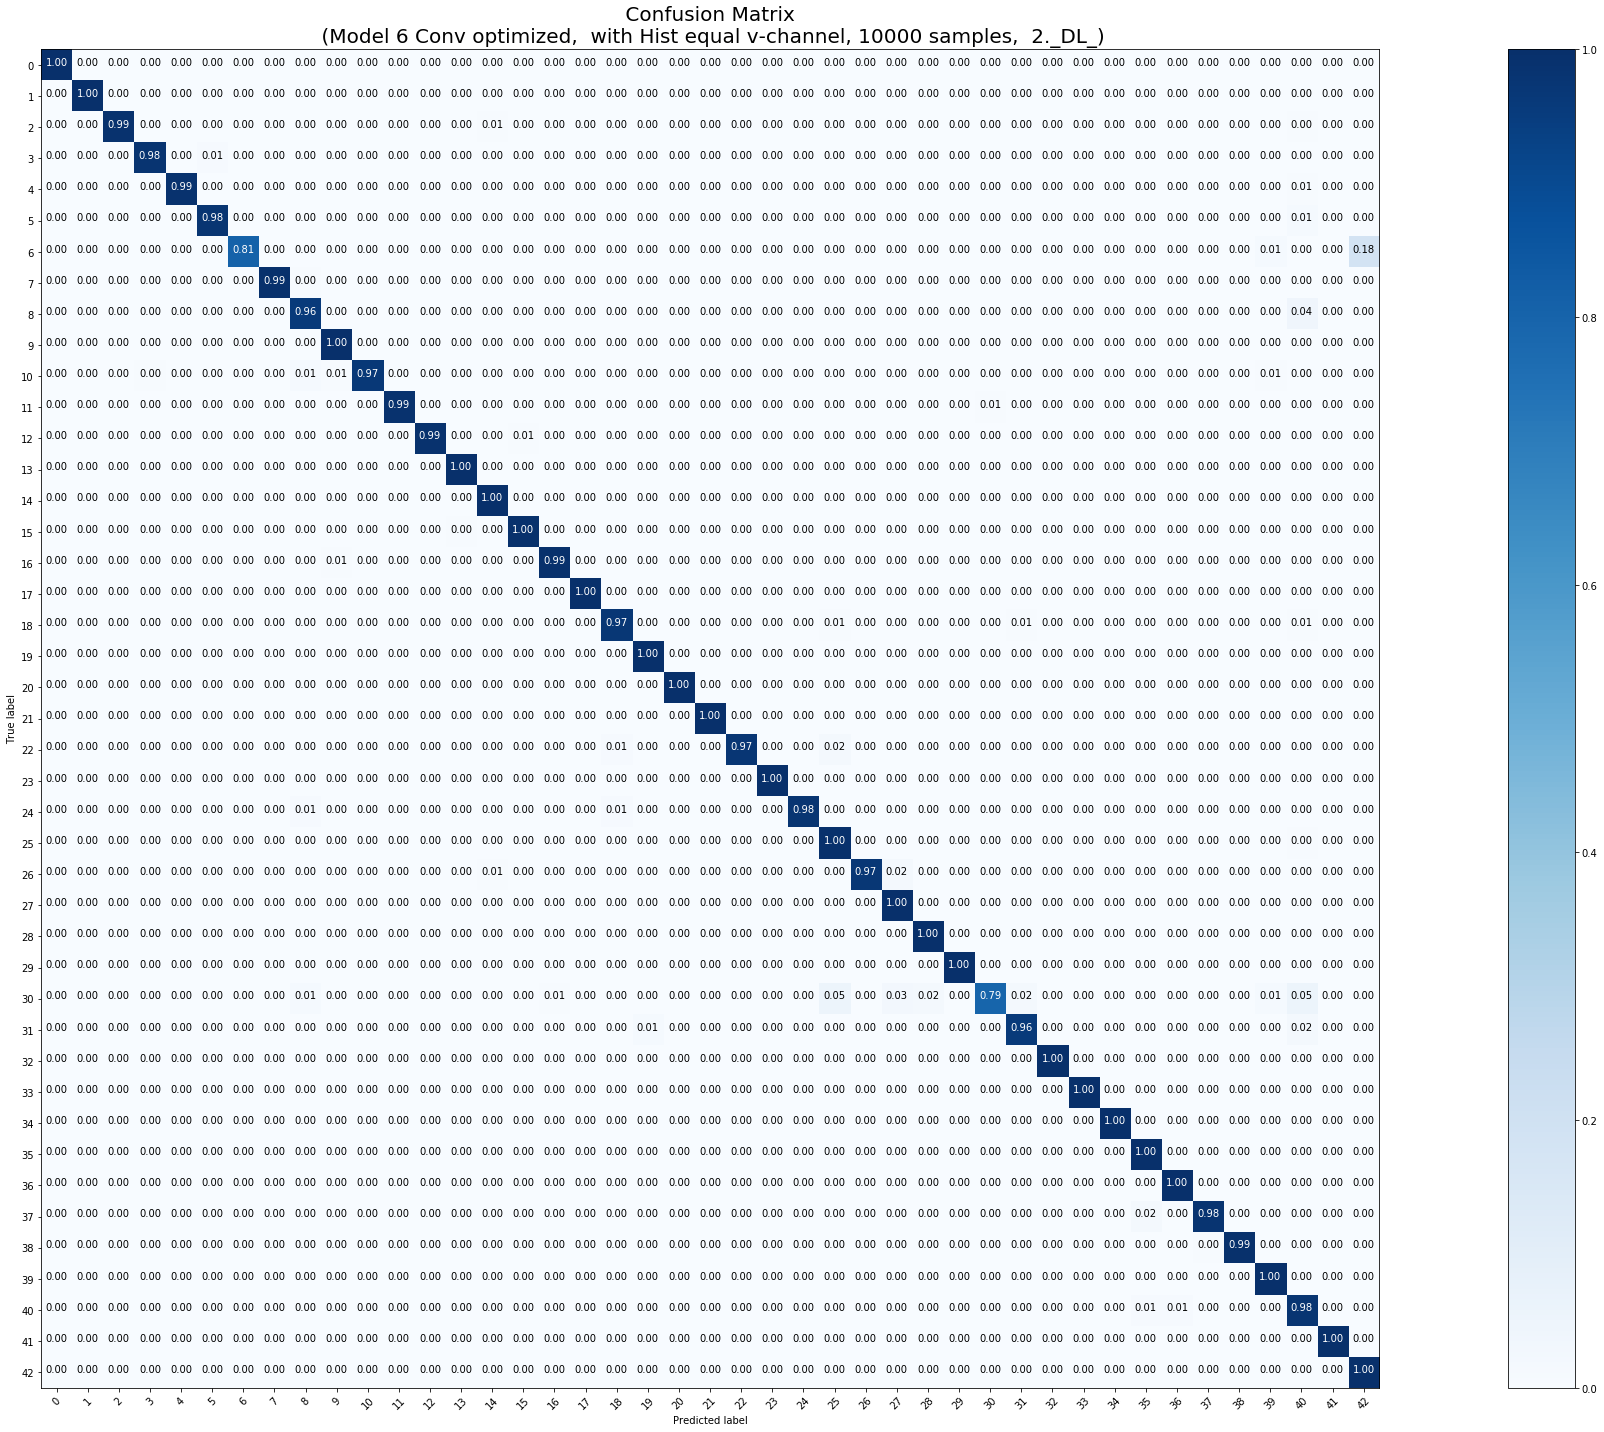

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.8455 - acc: 0.7508 - val_loss: 0.1620 - val_acc: 0.9454
Epoch 2/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.2200 - acc: 0.9247 - val_loss: 0.1206 - val_acc: 0.9603
Epoch 3/50
1226/1226 [==============================] - 39s 32ms/step - loss: 0.1542 - acc: 0.9454 - val_loss: 0.0643 - val_acc: 0.9808
Epoch 4/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.1256 - acc: 0.9572 - val_loss: 0.0931 - val_acc: 0.9710
Epoch 5/50
1226/1226 [==============================] - 39s 32ms/step - loss: 0.0935 - acc: 0.9653 - val_loss: 0.1268 - val_acc: 0.9648
Epoch 6/50
1226/1226 [==============================] - 39s 32ms/step - loss: 0.0881 - acc: 0.9676 - val_loss: 0.0879 - val_acc: 0.9743
Epoch 7/50
1226/1226 [==============================] - 39s

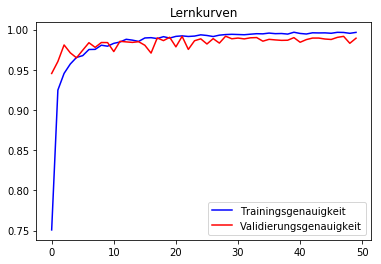

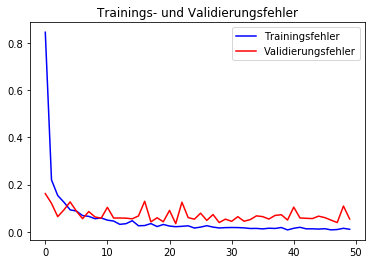

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.99      0.99       450
           4       1.00      0.99      1.00       660
           5       0.98      0.99      0.99       630
           6       0.99      0.93      0.96       150
           7       1.00      1.00      1.00       450
           8       1.00      0.97      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       1.00      1.00      1.00       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.91      1.00      0.95       210
          16       1.00      0.99      1.00       

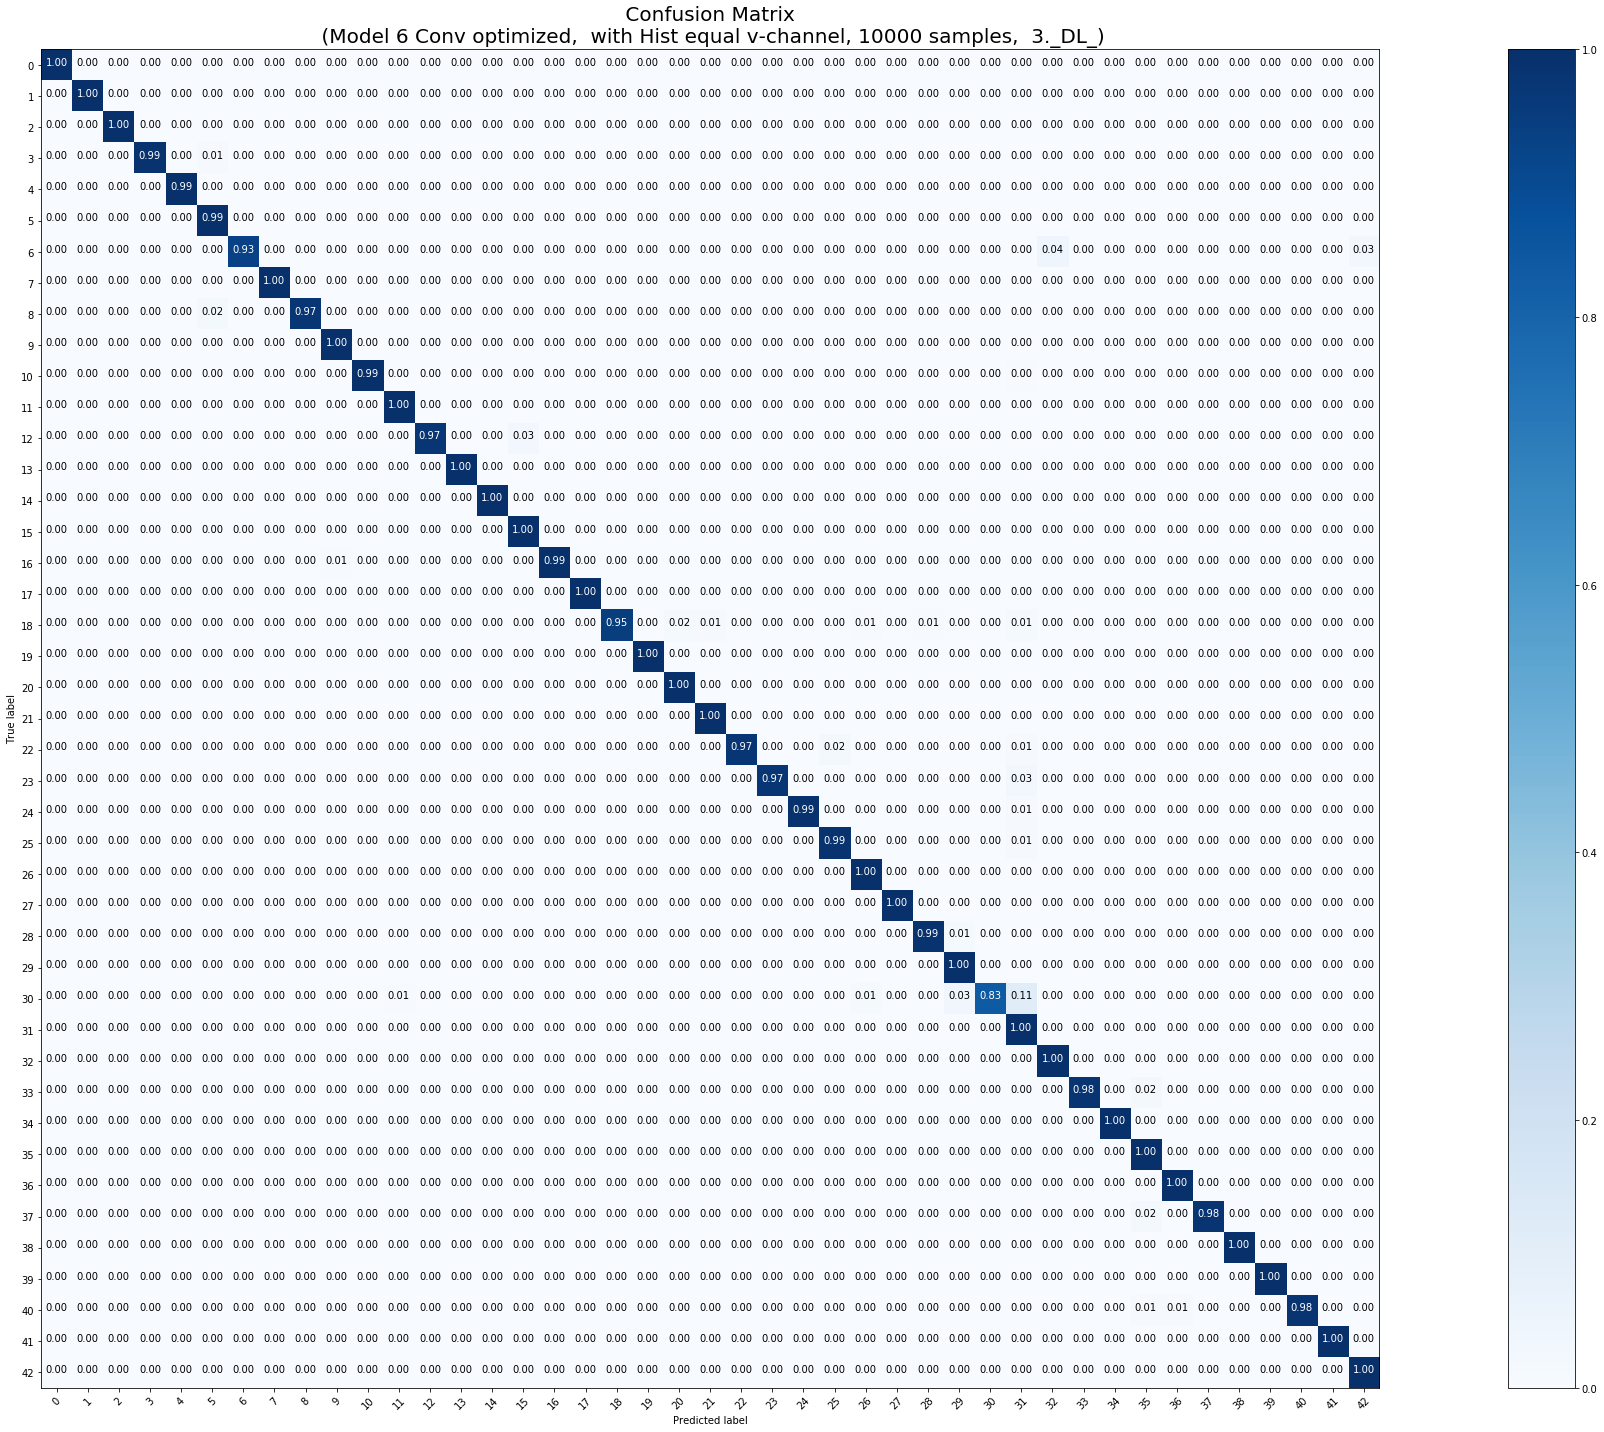

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.8695 - acc: 0.7441 - val_loss: 0.1975 - val_acc: 0.9389
Epoch 2/50
1226/1226 [==============================] - 38s 31ms/step - loss: 0.2271 - acc: 0.9247 - val_loss: 0.1197 - val_acc: 0.9642
Epoch 3/50
1226/1226 [==============================] - 39s 31ms/step - loss: 0.1476 - acc: 0.9488 - val_loss: 0.1003 - val_acc: 0.9721
Epoch 4/50
1226/1226 [==============================] - 38s 31ms/step - loss: 0.1277 - acc: 0.9550 - val_loss: 0.0961 - val_acc: 0.9715
Epoch 5/50
1226/1226 [==============================] - 39s 31ms/step - loss: 0.1010 - acc: 0.9652 - val_loss: 0.0582 - val_acc: 0.9817
Epoch 6/50
1226/1226 [==============================] - 40s 32ms/step - loss: 0.0922 - acc: 0.9684 - val_loss: 0.1268 - val_acc: 0.9610
Epoch 7/50
1226/1226 [==============================] - 39s

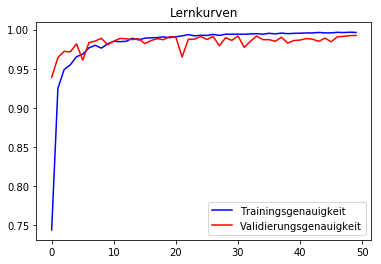

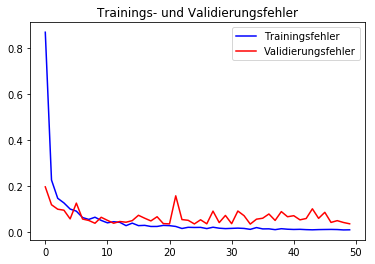

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.99      1.00       660
           5       0.99      0.99      0.99       630
           6       1.00      0.83      0.91       150
           7       0.99      1.00      0.99       450
           8       0.98      1.00      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       0.99      1.00      0.99       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16       1.00      0.99      1.00       

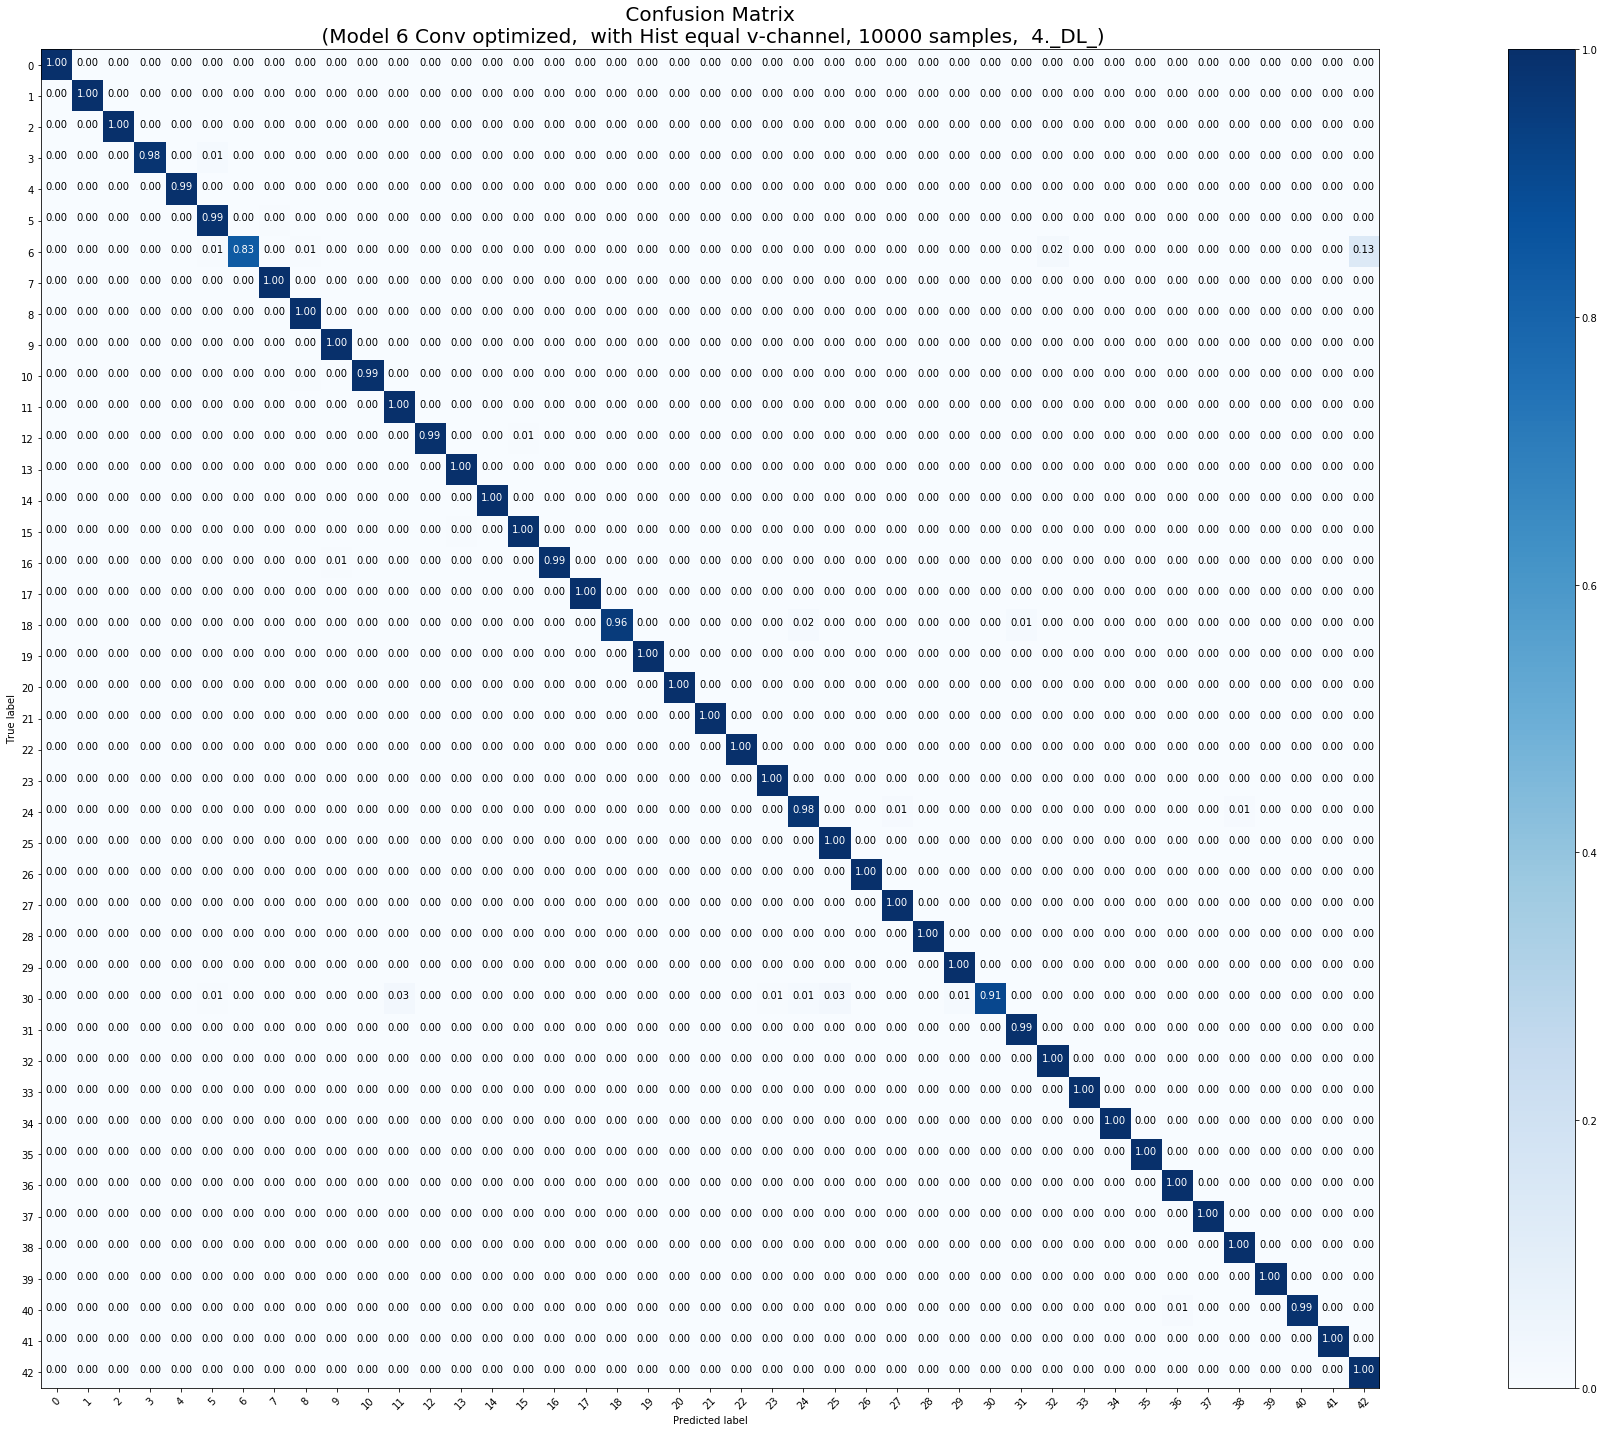

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.8593 - acc: 0.7476 - val_loss: 0.1481 - val_acc: 0.9515
Epoch 2/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.2206 - acc: 0.9266 - val_loss: 0.0954 - val_acc: 0.9689
Epoch 3/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1578 - acc: 0.9476 - val_loss: 0.0839 - val_acc: 0.9742
Epoch 4/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1218 - acc: 0.9578 - val_loss: 0.0649 - val_acc: 0.9804
Epoch 5/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1062 - acc: 0.9643 - val_loss: 0.0972 - val_acc: 0.9692
Epoch 6/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.0852 - acc: 0.9706 - val_loss: 0.0936 - val_acc: 0.9722
Epoch 7/50
1226/1226 [==============================] - 41s

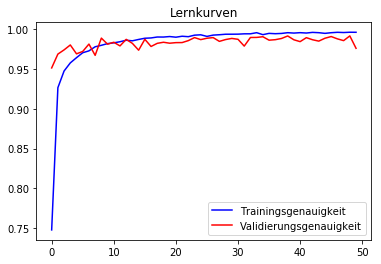

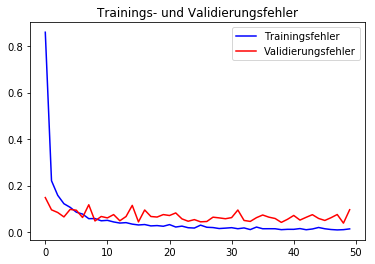

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.99      1.00       720
           2       0.99      1.00      1.00       750
           3       0.99      0.97      0.98       450
           4       1.00      0.98      0.99       660
           5       0.95      0.98      0.97       630
           6       1.00      0.85      0.92       150
           7       0.99      0.99      0.99       450
           8       0.95      0.95      0.95       450
           9       0.99      1.00      0.99       480
          10       1.00      0.94      0.97       660
          11       1.00      0.97      0.99       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.95      1.00      0.98       270
          15       0.85      1.00      0.92       210
          16       1.00      0.99      1.00       

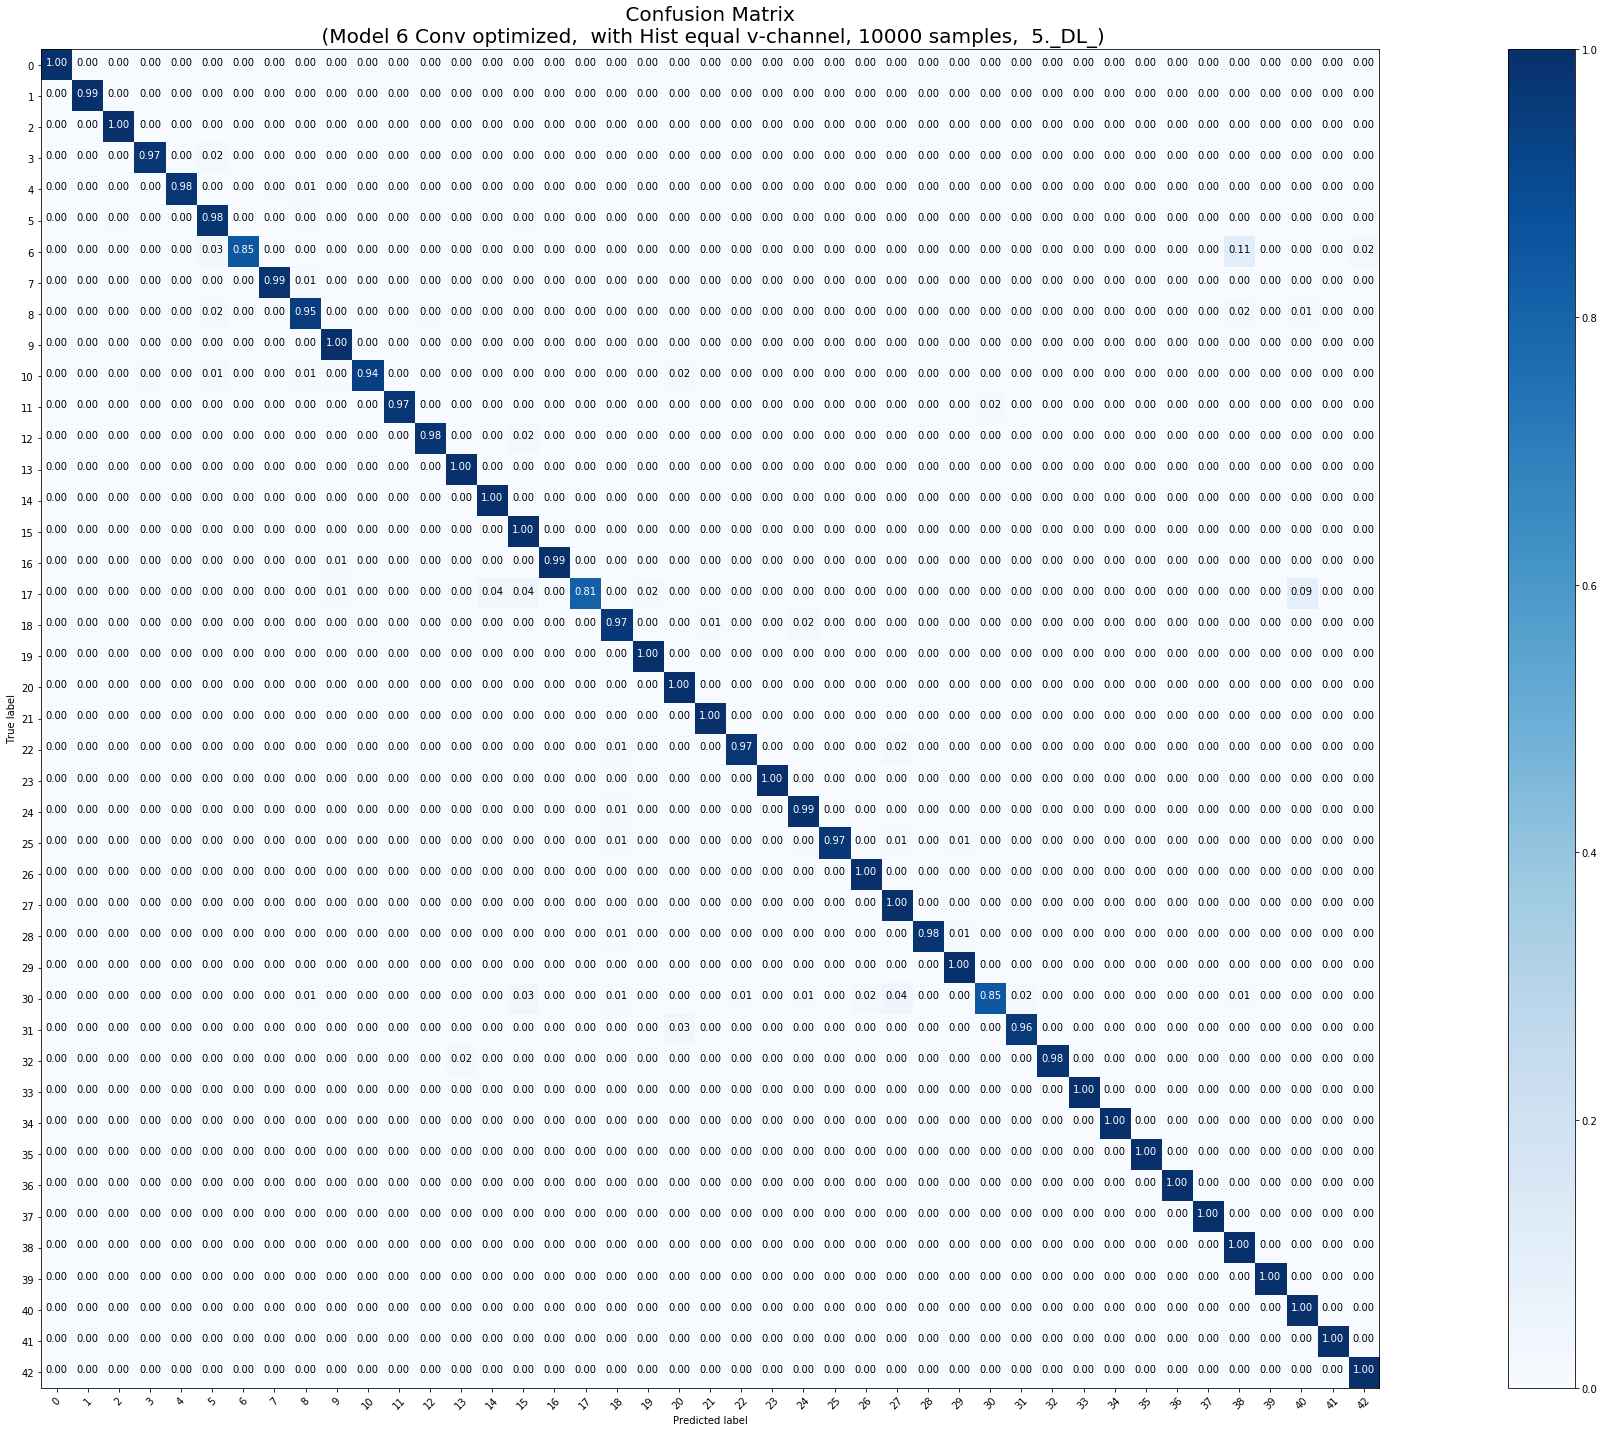

<Figure size 432x288 with 0 Axes>

In [0]:
# Trainingsmenge 10000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_10000, y_tr_10000, X_test, y_test, 0.2, 0.001, False, 10000)

In [0]:
downloader(1,5, 10000)

In [0]:
###########################################################################################################
###########################################################################################################
#########   Wiederholtes Training Model Stergiou 6 Conv unter Verwendung von
#########   Data Augmentation und class-weights=balanced,  
#########   2. Aufteilung der Trainingsdaten,    
###########################################################################################################
########################################################################################################### 
X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200 = make_training_subsets_B(X_train, y_train)

In [0]:
# Trainingsmenge 500
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_500, y_tr_500, X_test, y_test, 0.2, 0.001, False, 500)

In [0]:
downloader(1,5,500)

In [0]:
# Trainingsmenge 1000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_1000, y_tr_1000, X_test, y_test, 0.2, 0.001, False, 1000)

In [0]:
downloader(1,5,1000)

In [0]:
# Trainingsmenge 2000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_2000, y_tr_2000, X_test, y_test, 0.2, 0.001, False, 2000)

In [0]:
downloader(1,5,2000)

In [0]:
# Trainingsmenge 5000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_5000, y_tr_5000, X_test, y_test, 0.2, 0.001, False, 5000)

In [0]:
downloader(1,5,5000)

In [0]:
# Trainingsmenge 10000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_10000, y_tr_10000, X_test, y_test, 0.2, 0.001, False, 10000)

In [0]:
downloader(1,5,10000)

In [0]:
files.download("4._2000_Lernkurve_GTSRB_6_Conv_acc.png")
files.download("4._2000_Lernkurve_GTSRB_6_Conv_loss.png")
files.download("4._DL_2000_Confusion_matrix.png")
files.download("4._DL_2000_beste_Epoche.csv")
files.download("4._DL_2000_GTSRB_opt_ES.hdf5")
files.download("4._DL_2000_GTSRB_opt_ES_weights.hdf5")
files.download("4._DL_2000_metrics.csv")
files.download("4._DL_2000_metrics_train.csv")
files.download("4._DL_2000_precision_recall_fscore.csv")
files.download("4._DL_2000_precision_recall_fscore_train.csv")
files.download("4._DL_2000_roc_auc_score_single_class.npy")
files.download("4._DL_2000_roc_auc_score_single_class_train.npy")
files.download("4._DL_2000_Testzeiten.csv")
files.download("4._DL_2000_Trainingszeiten_ES.csv")
files.download("4._DL_2000_y_pred_label.npy")
files.download("4._DL_2000_y_pred_label_train.npy")


In [0]:
###########################################################################################################
###########################################################################################################
#########   Wiederholtes Training mit Model Stergiou 6 Conv unter Verwendung von
#########   Data Augmentation und class-weights=balanced,  
#########   3. Aufteilung der Trainingsdaten,    
###########################################################################################################
########################################################################################################### 
X_tr,y_tr,X_tr_20000,y_tr_20000,X_tr_10000,y_tr_10000,X_tr_5000,y_tr_5000,X_tr_2000,y_tr_2000,X_tr_1000,y_tr_1000,X_tr_500,y_tr_500,X_tr_200,y_tr_200 = make_training_subsets_C(X_train, y_train)

***************************************************************************** 
1 ._Trainingsdurchlauf
 










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Modell wurde erzeugt
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
1226/1226 [==============================] - 49s 40ms/step - loss: 0.5086 - acc: 0.8283 - val_loss: 0.4165 - val_acc: 0.8811
Epoch 2/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0767 - acc: 0.9688 - val_loss: 0.3204 - val_acc: 0.9132
Epoch 3/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0515 - acc: 0.9798 - val_loss: 0.4062 - val_acc: 0.9124
Epoch 4/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0539 - acc: 0.9801 - val_loss: 0.3353 - val_acc: 0.9171
Epoch 5/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0392 - acc: 0.9838 - val_los

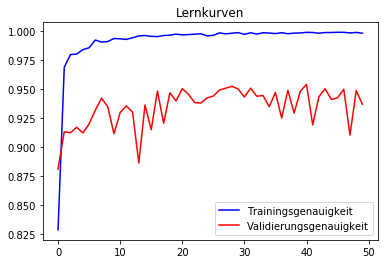

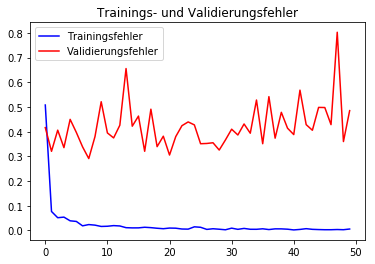

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        60
           1       1.00      0.95      0.97       720
           2       0.97      0.98      0.97       750
           3       0.88      0.94      0.91       450
           4       0.98      0.98      0.98       660
           5       0.93      0.91      0.92       630
           6       1.00      0.85      0.92       150
           7       0.98      0.97      0.97       450
           8       0.96      0.79      0.87       450
           9       0.95      0.98      0.96       480
          10       1.00      0.99      0.99       660
          11       0.86      0.72      0.78       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.94      0.93      0.94       210
          16       0.96      0.99      0.98       

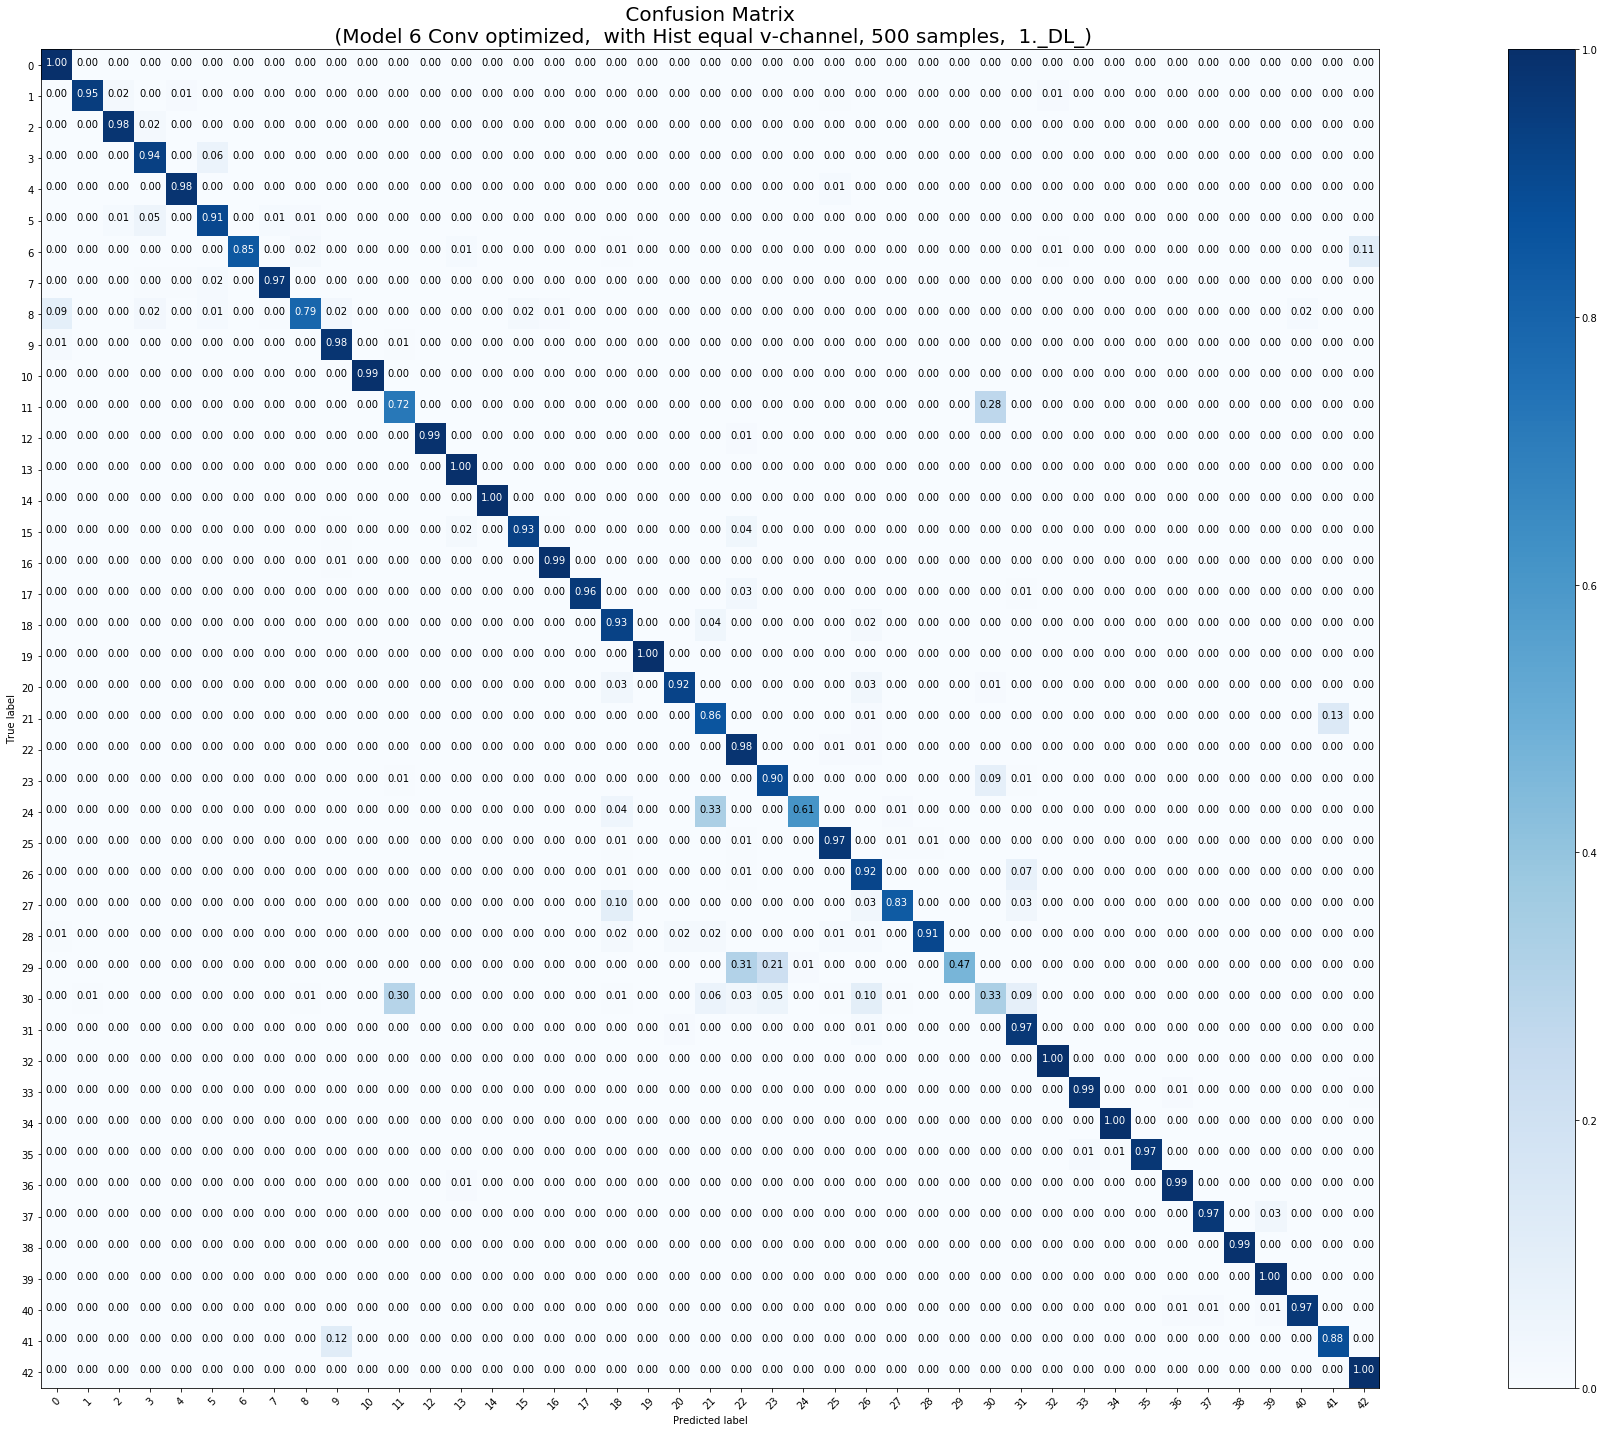

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 48s 40ms/step - loss: 0.4775 - acc: 0.8368 - val_loss: 0.3867 - val_acc: 0.8888
Epoch 2/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0730 - acc: 0.9717 - val_loss: 0.2850 - val_acc: 0.9292
Epoch 3/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0546 - acc: 0.9785 - val_loss: 0.3504 - val_acc: 0.9177
Epoch 4/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0452 - acc: 0.9830 - val_loss: 0.5533 - val_acc: 0.8776
Epoch 5/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0407 - acc: 0.9842 - val_loss: 0.3228 - val_acc: 0.9276
Epoch 6/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0240 - acc: 0.9899 - val_loss: 0.3761 - val_acc: 0.9258
Epoch 7/50
1226/1226 [==============================] - 46s

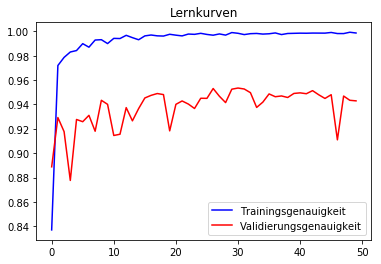

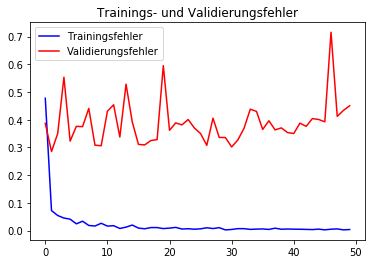

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      0.96      0.98       720
           2       0.97      0.99      0.98       750
           3       0.91      0.93      0.92       450
           4       1.00      0.97      0.98       660
           5       0.93      0.96      0.94       630
           6       1.00      0.85      0.92       150
           7       0.98      0.96      0.97       450
           8       0.95      0.90      0.92       450
           9       0.94      0.99      0.97       480
          10       1.00      0.99      0.99       660
          11       0.86      0.66      0.75       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      0.98      0.99       270
          15       0.80      1.00      0.89       210
          16       0.99      0.99      0.99       

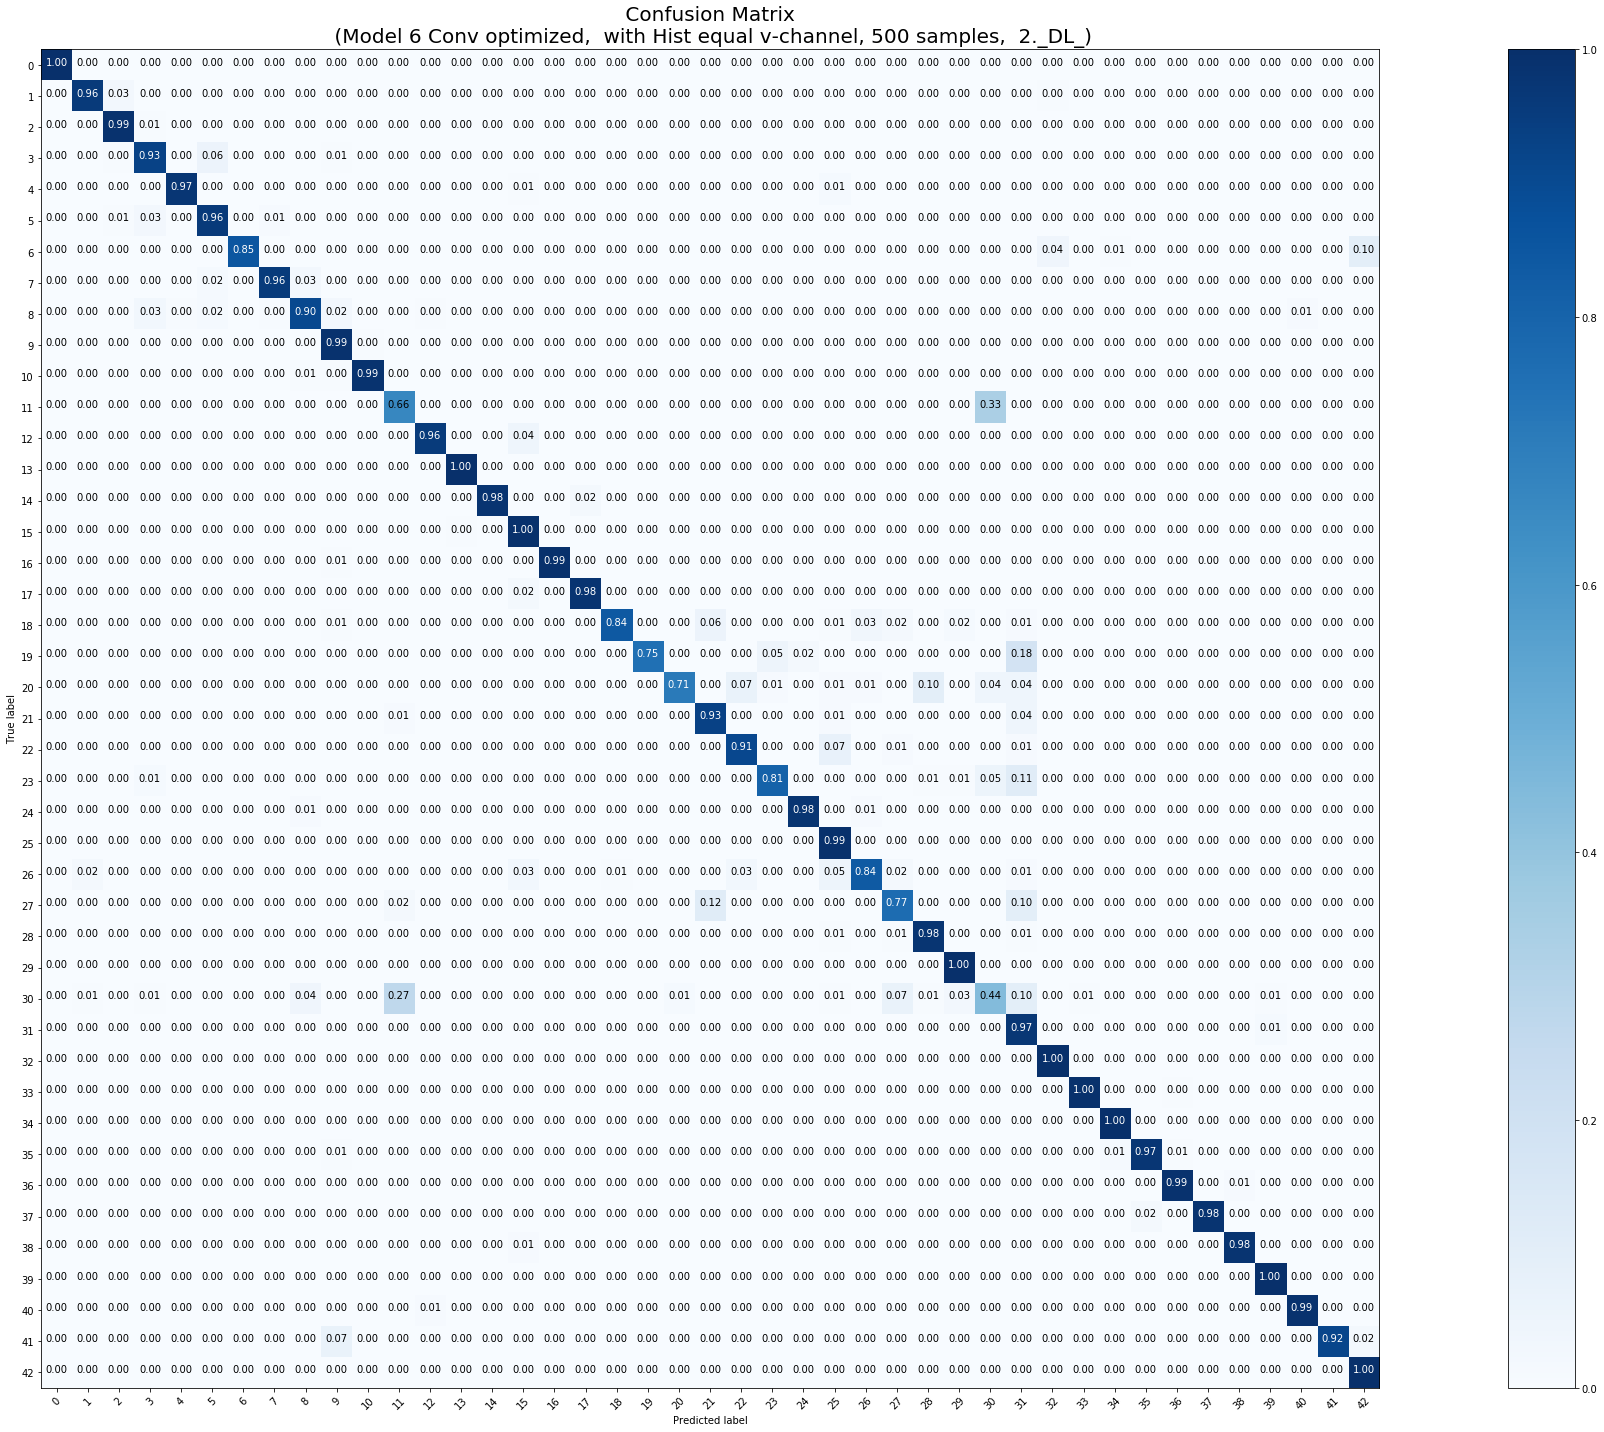

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 49s 40ms/step - loss: 0.4900 - acc: 0.8340 - val_loss: 0.3421 - val_acc: 0.9070
Epoch 2/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0723 - acc: 0.9709 - val_loss: 0.4046 - val_acc: 0.9017
Epoch 3/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0592 - acc: 0.9777 - val_loss: 0.8064 - val_acc: 0.8367
Epoch 4/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0439 - acc: 0.9823 - val_loss: 0.6556 - val_acc: 0.8663
Epoch 5/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0332 - acc: 0.9864 - val_loss: 0.4305 - val_acc: 0.9091
Epoch 6/50
1226/1226 [==============================] - 46s 37ms/step - loss: 0.0303 - acc: 0.9875 - val_loss: 0.3265 - val_acc: 0.9329
Epoch 7/50
1226/1226 [==============================] - 46s

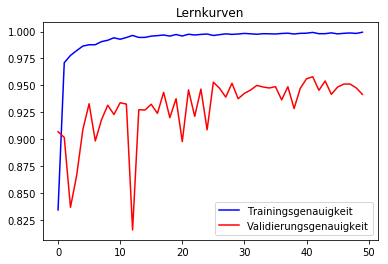

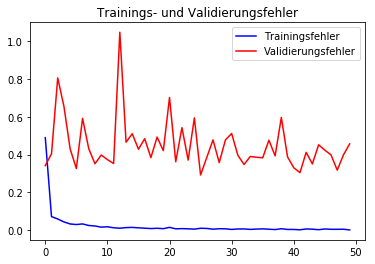

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        60
           1       0.98      0.99      0.98       720
           2       1.00      0.96      0.98       750
           3       0.98      0.92      0.95       450
           4       1.00      0.98      0.99       660
           5       0.91      0.96      0.94       630
           6       0.98      0.82      0.89       150
           7       0.99      0.94      0.96       450
           8       0.89      0.93      0.91       450
           9       0.96      0.99      0.97       480
          10       1.00      0.98      0.99       660
          11       0.99      0.62      0.76       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      0.89      0.94       270
          15       0.85      1.00      0.92       210
          16       0.95      0.99      0.97       

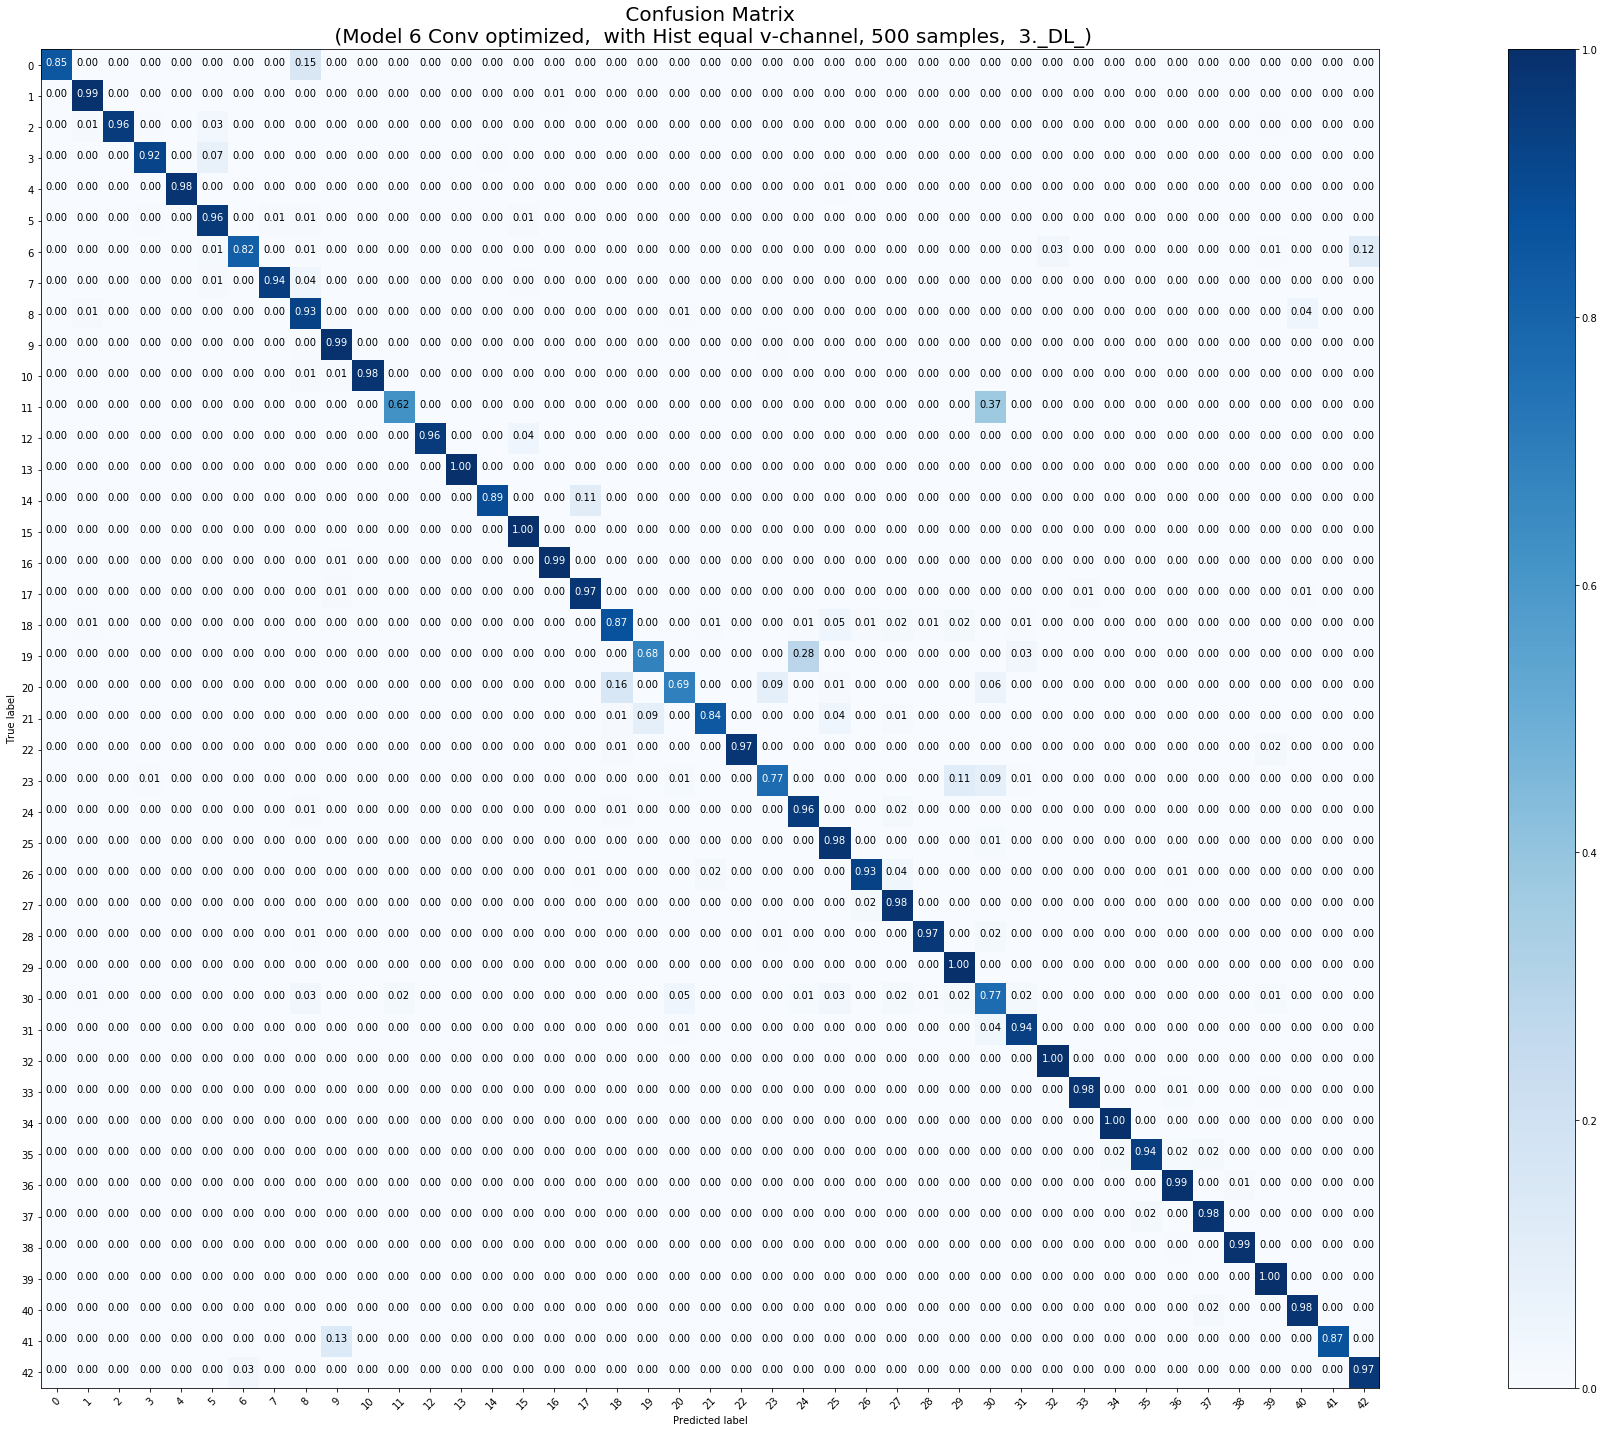

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 49s 40ms/step - loss: 0.5271 - acc: 0.8208 - val_loss: 0.4333 - val_acc: 0.8884
Epoch 2/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0756 - acc: 0.9702 - val_loss: 0.3818 - val_acc: 0.9101
Epoch 3/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0574 - acc: 0.9769 - val_loss: 0.3098 - val_acc: 0.9214
Epoch 4/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0412 - acc: 0.9835 - val_loss: 0.4320 - val_acc: 0.9074
Epoch 5/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0324 - acc: 0.9869 - val_loss: 0.3909 - val_acc: 0.9177
Epoch 6/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0368 - acc: 0.9860 - val_loss: 0.5966 - val_acc: 0.8780
Epoch 7/50
1226/1226 [==============================] - 46s

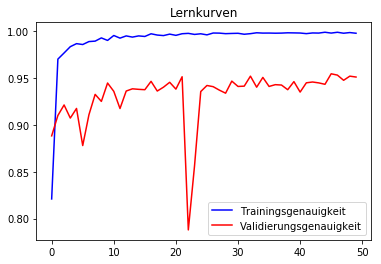

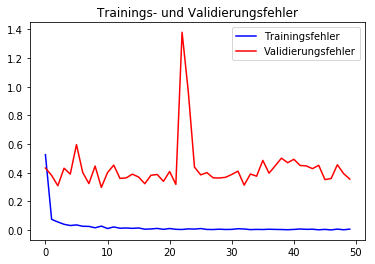

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.99      0.98      0.98       720
           2       0.98      0.99      0.98       750
           3       0.96      0.94      0.95       450
           4       0.98      0.98      0.98       660
           5       0.94      0.95      0.94       630
           6       0.98      0.86      0.92       150
           7       0.95      0.99      0.97       450
           8       0.96      0.92      0.94       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      0.99       660
          11       0.91      0.72      0.80       420
          12       0.99      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      0.97      0.99       270
          15       0.83      1.00      0.91       210
          16       1.00      0.99      1.00       

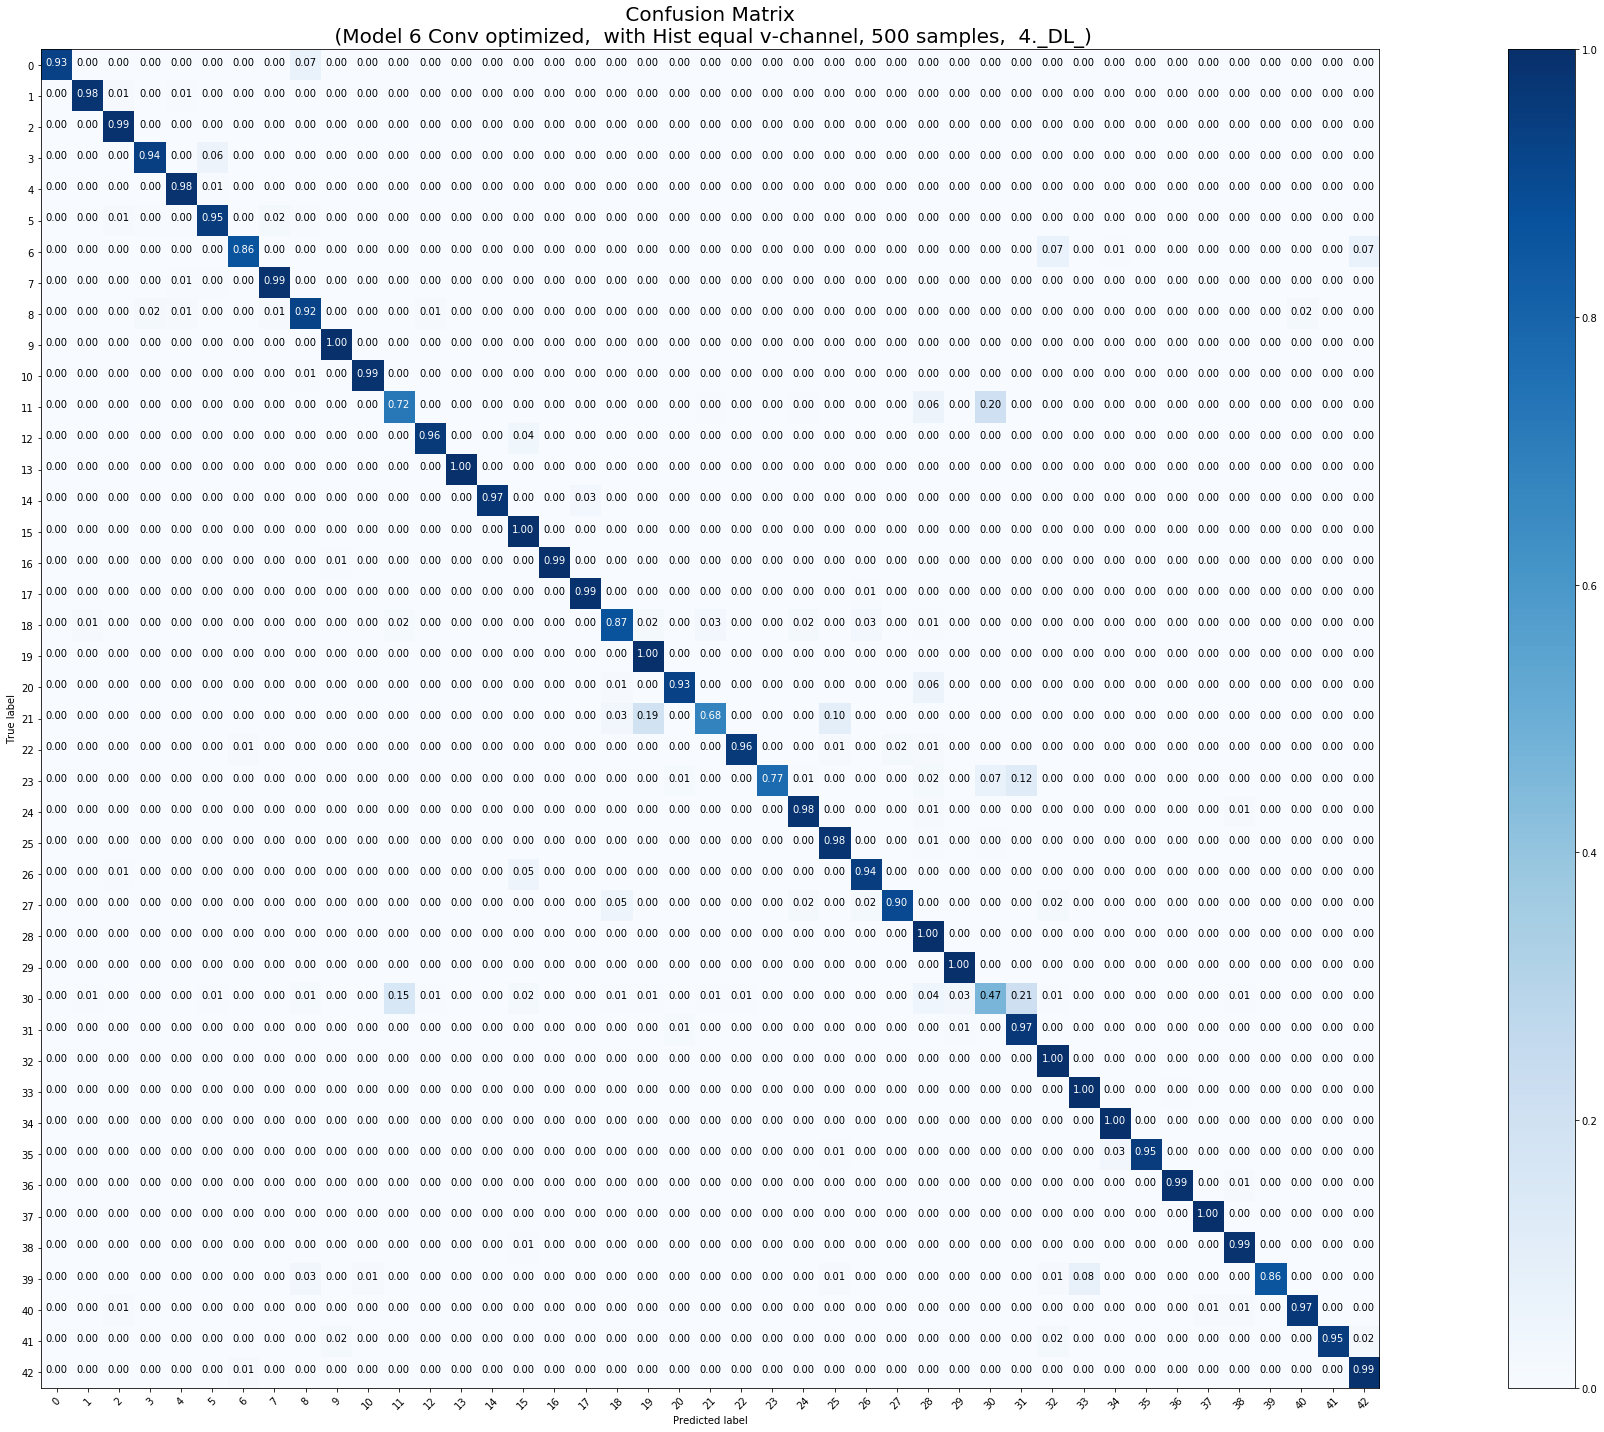

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 50s 40ms/step - loss: 0.4878 - acc: 0.8375 - val_loss: 0.5346 - val_acc: 0.8693
Epoch 2/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0788 - acc: 0.9685 - val_loss: 0.3601 - val_acc: 0.9032
Epoch 3/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0522 - acc: 0.9801 - val_loss: 0.3107 - val_acc: 0.9214
Epoch 4/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0397 - acc: 0.9841 - val_loss: 0.6829 - val_acc: 0.8641
Epoch 5/50
1226/1226 [==============================] - 47s 38ms/step - loss: 0.0432 - acc: 0.9832 - val_loss: 0.3694 - val_acc: 0.9259
Epoch 6/50
1226/1226 [==============================] - 46s 38ms/step - loss: 0.0310 - acc: 0.9888 - val_loss: 0.3604 - val_acc: 0.9156
Epoch 7/50
1225/1226 [============================>.] - ETA

In [0]:
# Trainingsmenge 500
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_500, y_tr_500, X_test, y_test, 0.2, 0.001, False, 500)

In [0]:
downloader(1,5,500)

In [0]:
# Trainingsmenge 1000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_1000, y_tr_1000, X_test, y_test, 0.2, 0.001, False, 1000)

In [0]:
downloader(1,5,1000)

In [0]:
# Trainingsmenge 2000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_2000, y_tr_2000, X_test, y_test, 0.2, 0.001, False, 2000)

In [0]:
downloader(1,5,2000)

***************************************************************************** 
1 ._Trainingsdurchlauf
 










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Modell wurde erzeugt
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
1226/1226 [==============================] - 50s 41ms/step - loss: 0.8495 - acc: 0.7490 - val_loss: 0.1559 - val_acc: 0.9523
Epoch 2/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.2313 - acc: 0.9220 - val_loss: 0.1408 - val_acc: 0.9542
Epoch 3/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.1359 - acc: 0.9507 - val_loss: 0.1294 - val_acc: 0.9646
Epoch 4/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.1215 - acc: 0.9560 - val_loss: 0.0826 - val_acc: 0.9756
Epoch 5/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.0927 - acc: 0.9679 - val_los

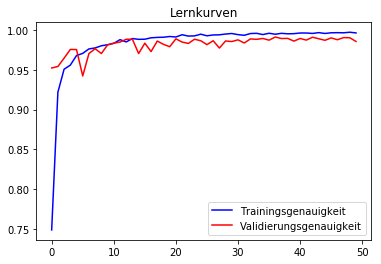

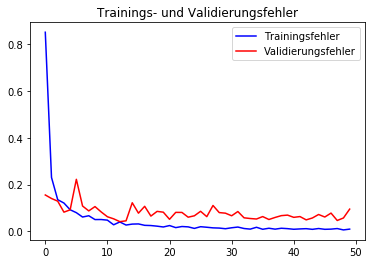

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.99      1.00       660
           5       0.98      0.99      0.98       630
           6       1.00      0.89      0.94       150
           7       0.99      1.00      0.99       450
           8       0.99      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       0.98      1.00      0.99       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       0.99      1.00      0.99       

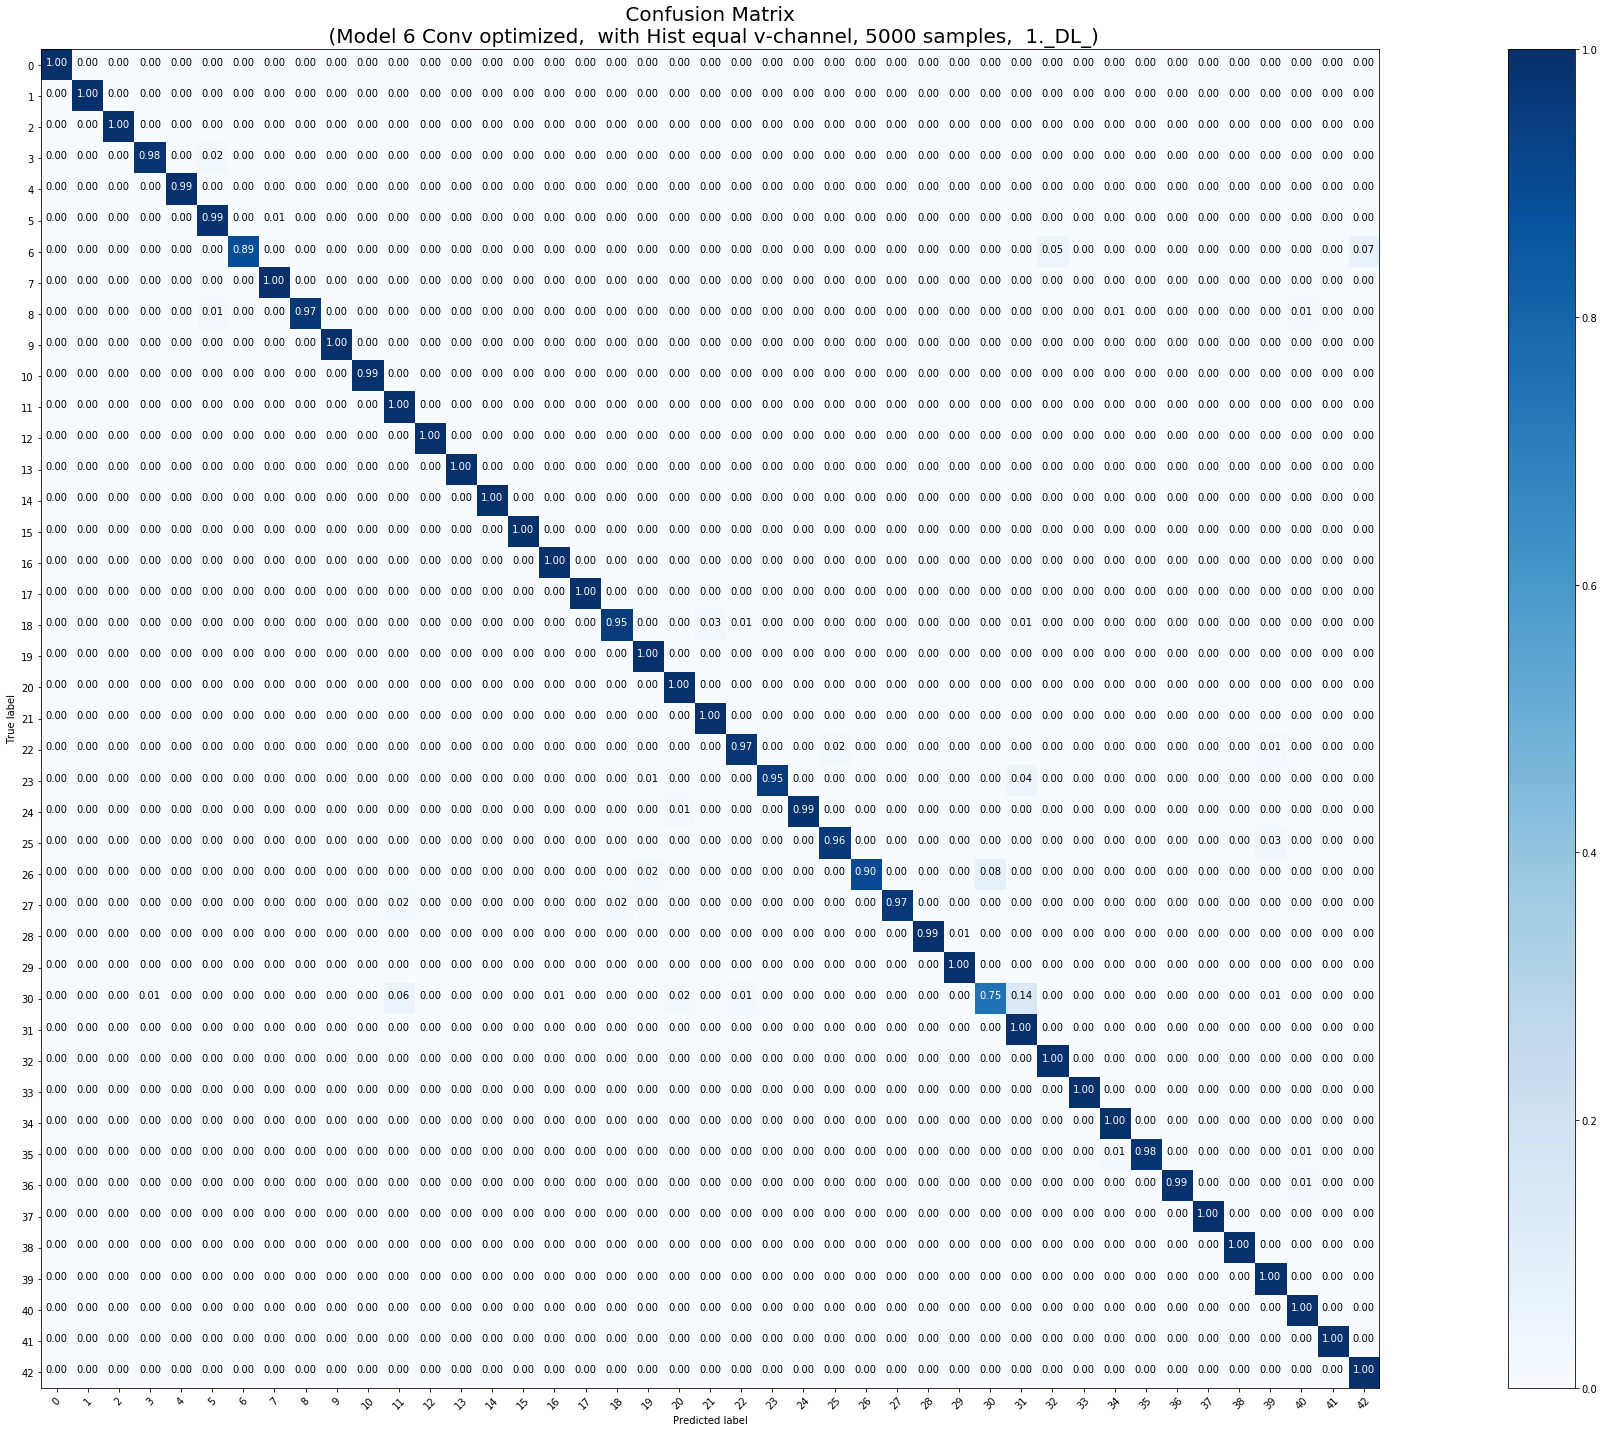

***************************************************************************** 
2 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.8664 - acc: 0.7448 - val_loss: 0.2574 - val_acc: 0.9231
Epoch 2/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.2014 - acc: 0.9313 - val_loss: 0.1322 - val_acc: 0.9582
Epoch 3/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.1502 - acc: 0.9468 - val_loss: 0.0989 - val_acc: 0.9718
Epoch 4/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.1195 - acc: 0.9590 - val_loss: 0.1264 - val_acc: 0.9654
Epoch 5/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.0915 - acc: 0.9683 - val_loss: 0.1683 - val_acc: 0.9578
Epoch 6/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.0772 - acc: 0.9719 - val_loss: 0.0999 - val_acc: 0.9711
Epoch 7/50
1226/1226 [==============================] - 41s

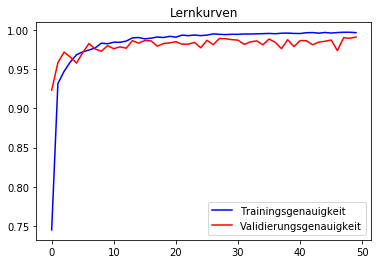

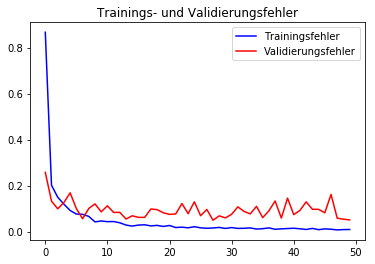

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      0.99      1.00       750
           3       0.99      0.99      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      1.00      0.99       630
           6       0.99      0.93      0.96       150
           7       1.00      1.00      1.00       450
           8       1.00      0.97      0.98       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.97      1.00      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.93      1.00      0.96       210
          16       0.99      1.00      1.00       

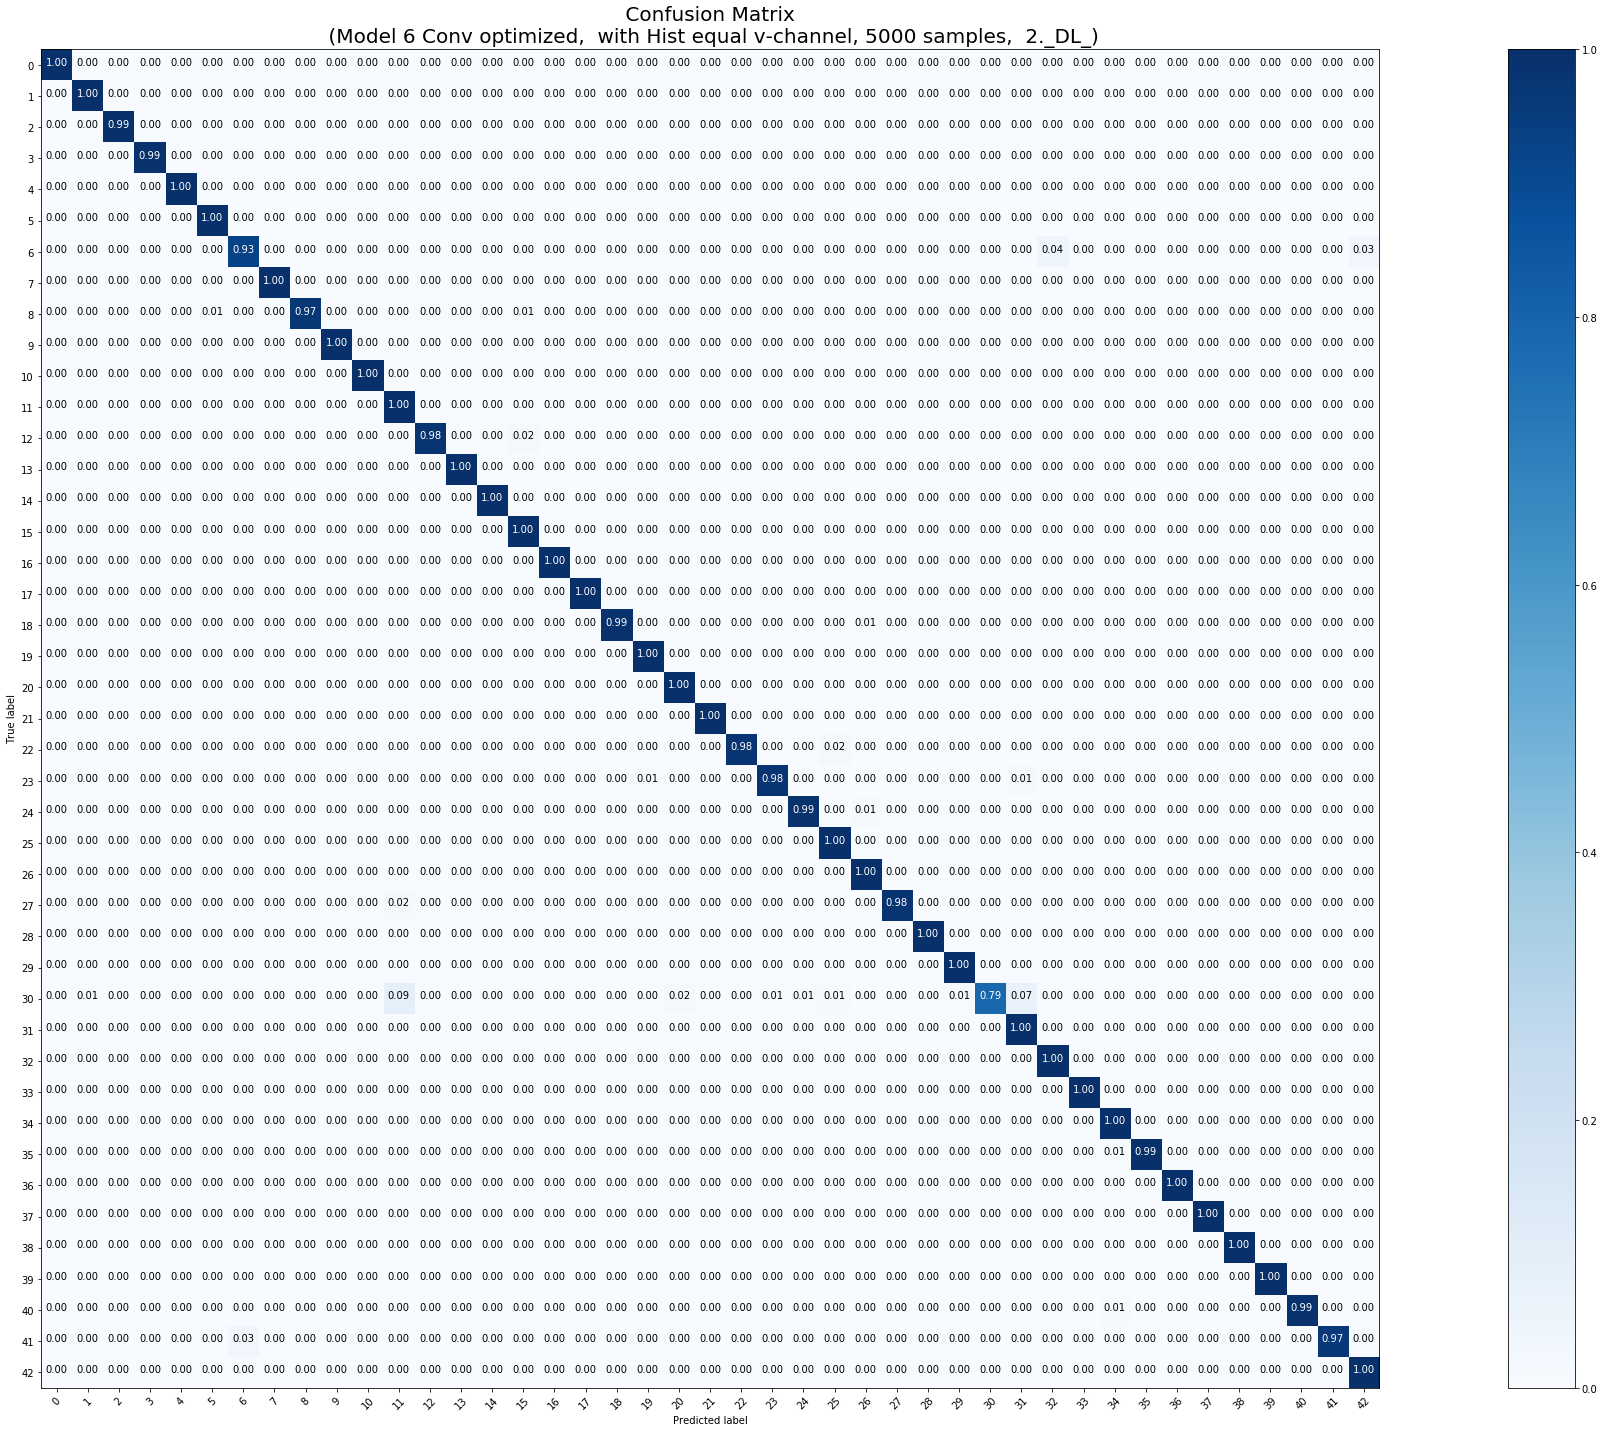

***************************************************************************** 
3 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 43s 35ms/step - loss: 0.8618 - acc: 0.7424 - val_loss: 0.1820 - val_acc: 0.9439
Epoch 2/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.2160 - acc: 0.9251 - val_loss: 0.0933 - val_acc: 0.9724
Epoch 3/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1435 - acc: 0.9490 - val_loss: 0.1824 - val_acc: 0.9503
Epoch 4/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.1090 - acc: 0.9603 - val_loss: 0.1425 - val_acc: 0.9618
Epoch 5/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.0938 - acc: 0.9655 - val_loss: 0.1211 - val_acc: 0.9633
Epoch 6/50
1226/1226 [==============================] - 41s 33ms/step - loss: 0.0834 - acc: 0.9711 - val_loss: 0.0701 - val_acc: 0.9821
Epoch 7/50
1226/1226 [==============================] - 41s

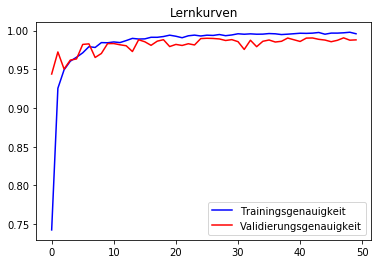

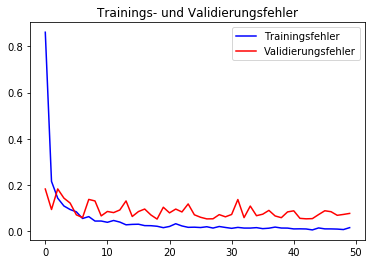

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      0.99       720
           2       1.00      0.99      1.00       750
           3       1.00      0.99      0.99       450
           4       1.00      0.99      1.00       660
           5       0.98      0.98      0.98       630
           6       1.00      0.93      0.96       150
           7       0.98      1.00      0.99       450
           8       0.99      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       0.97      1.00      0.98       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.87      1.00      0.93       210
          16       1.00      1.00      1.00       

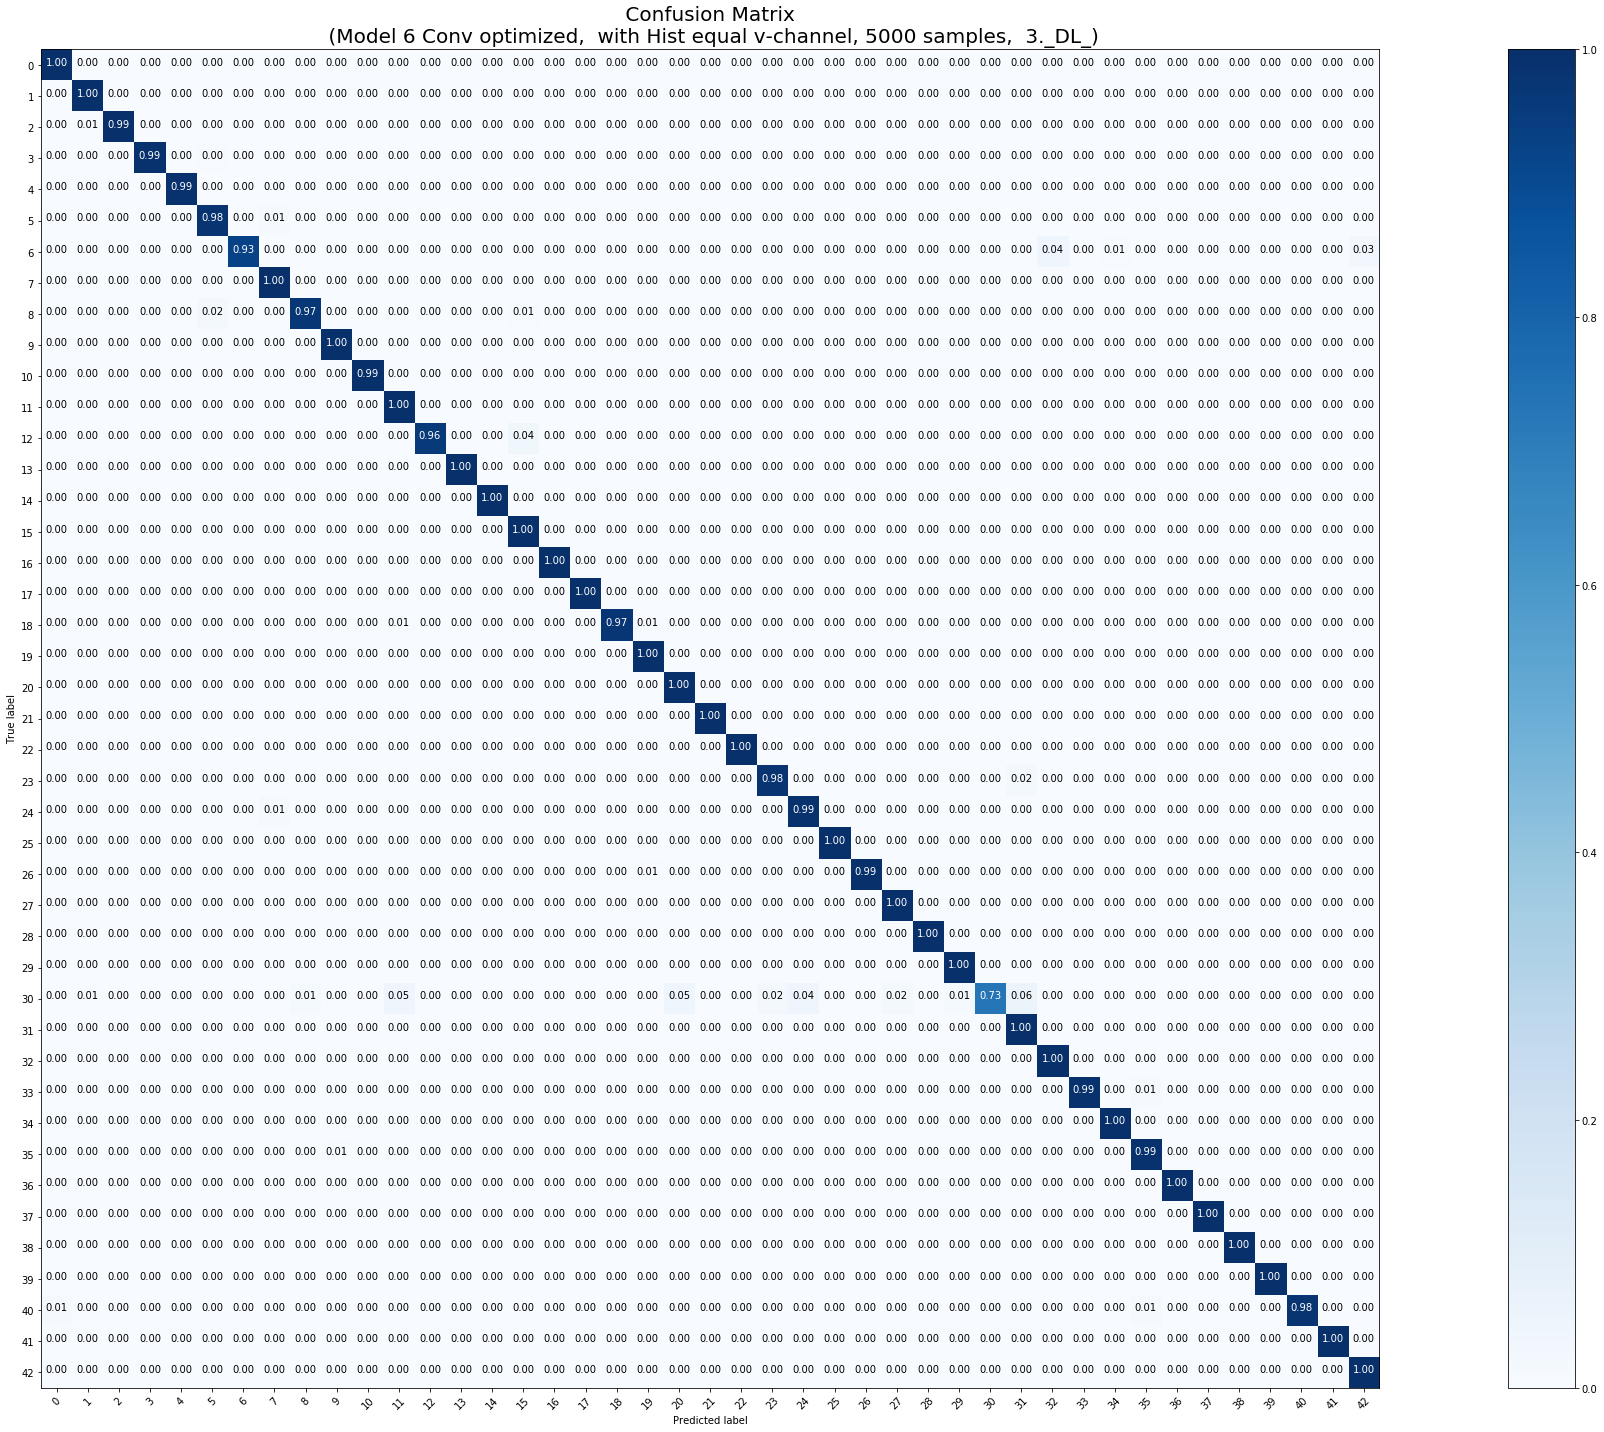

***************************************************************************** 
4 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.8631 - acc: 0.7472 - val_loss: 0.1581 - val_acc: 0.9516
Epoch 2/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.2199 - acc: 0.9233 - val_loss: 0.0942 - val_acc: 0.9709
Epoch 3/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1423 - acc: 0.9501 - val_loss: 0.1072 - val_acc: 0.9688
Epoch 4/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1185 - acc: 0.9574 - val_loss: 0.0957 - val_acc: 0.9738
Epoch 5/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.0900 - acc: 0.9681 - val_loss: 0.1055 - val_acc: 0.9708
Epoch 6/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.0808 - acc: 0.9714 - val_loss: 0.1047 - val_acc: 0.9720
Epoch 7/50
1226/1226 [==============================] - 42s

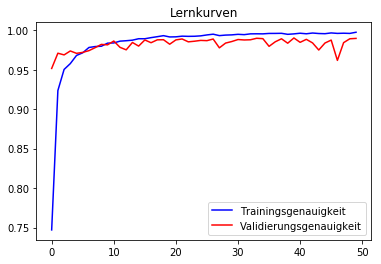

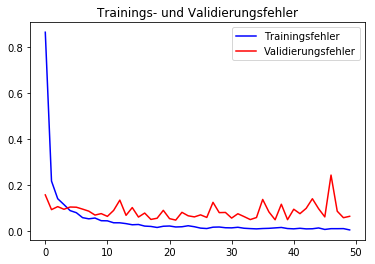

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.99      0.99      0.99       450
           4       1.00      0.99      1.00       660
           5       0.98      0.99      0.98       630
           6       1.00      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      0.96      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       0.95      1.00      0.97       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       0.91      1.00      0.95       210
          16       0.99      1.00      1.00       

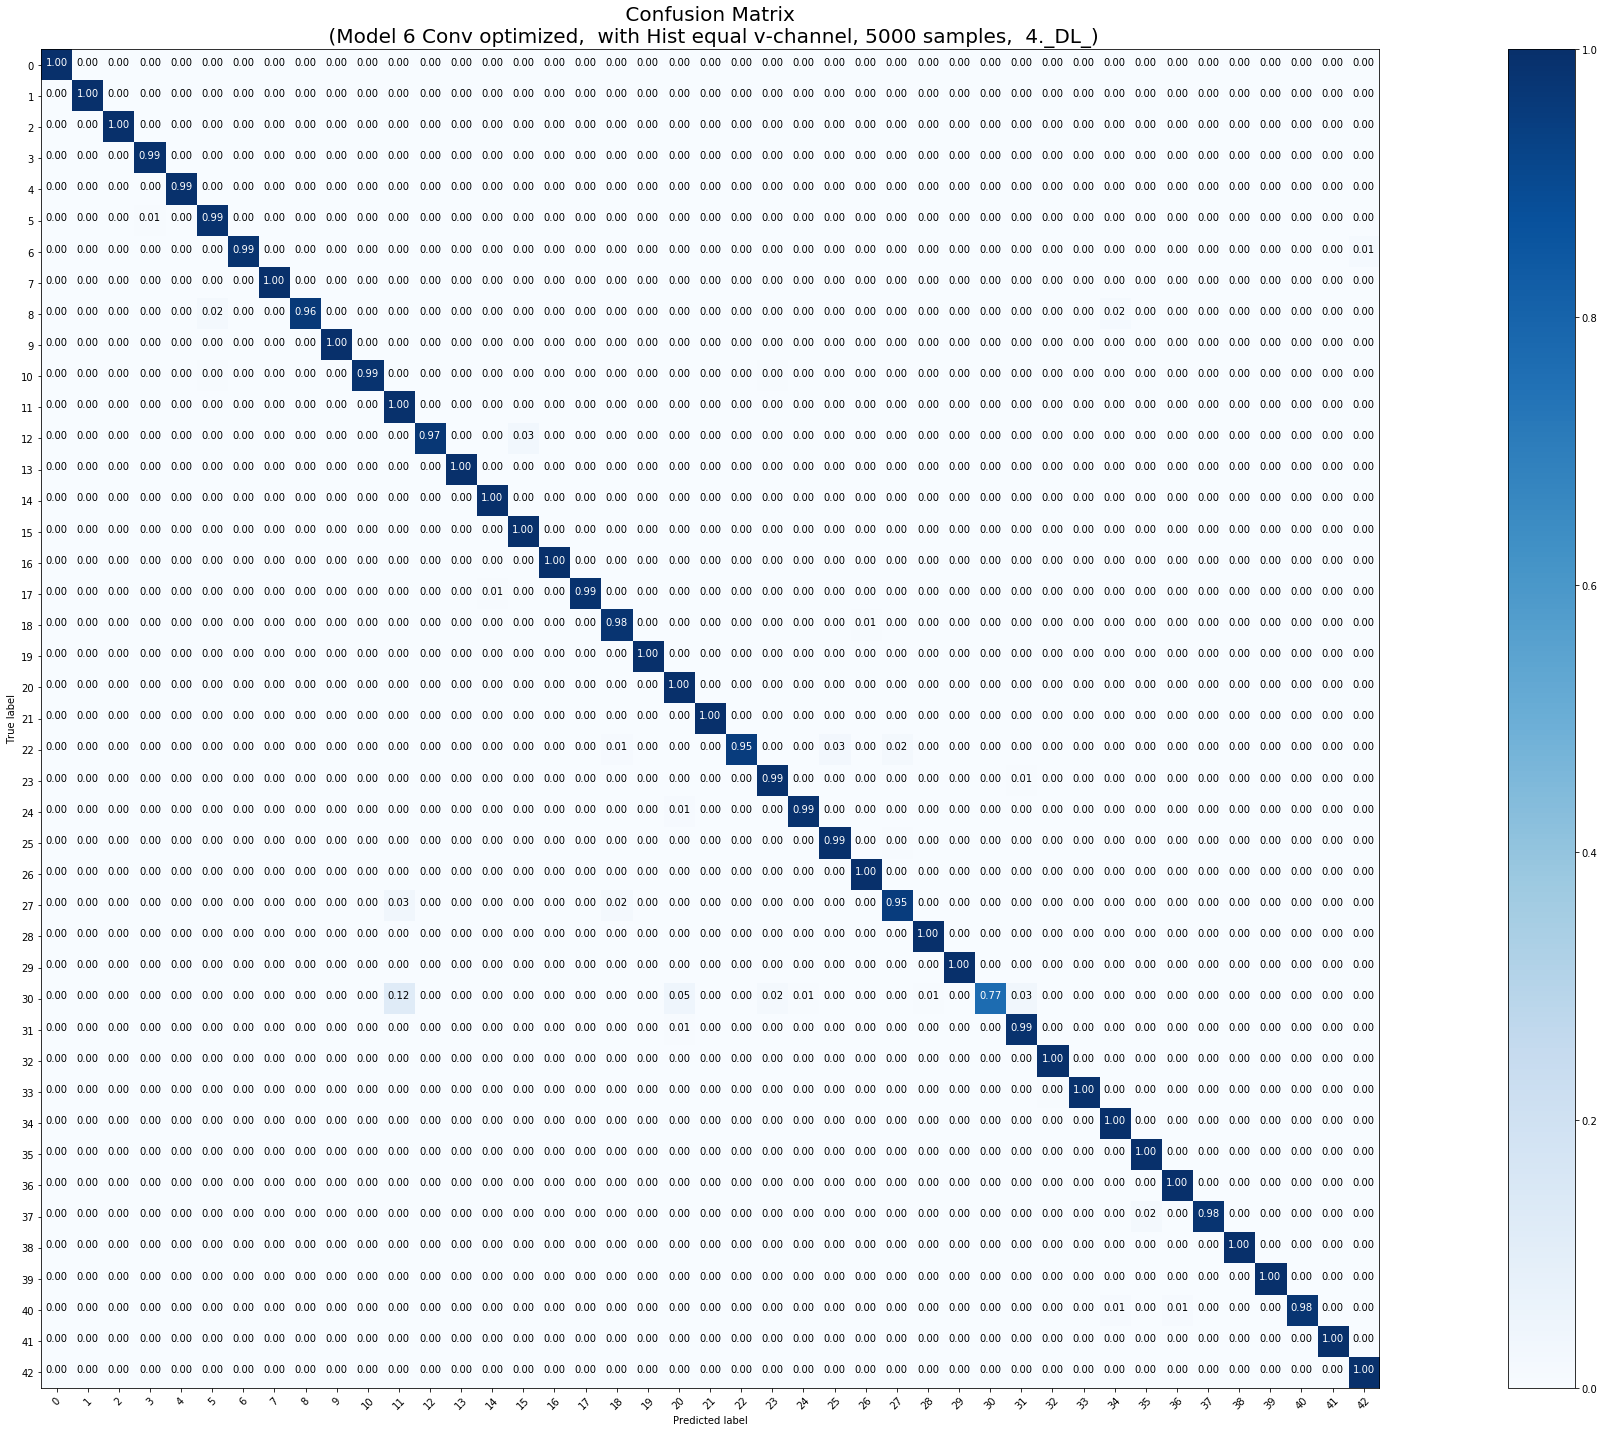

***************************************************************************** 
5 ._Trainingsdurchlauf
 
Modell wurde erzeugt
Epoch 1/50
1226/1226 [==============================] - 44s 36ms/step - loss: 0.8398 - acc: 0.7510 - val_loss: 0.1601 - val_acc: 0.9517
Epoch 2/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.2144 - acc: 0.9255 - val_loss: 0.1330 - val_acc: 0.9602
Epoch 3/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1389 - acc: 0.9497 - val_loss: 0.0716 - val_acc: 0.9785
Epoch 4/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.1117 - acc: 0.9600 - val_loss: 0.1067 - val_acc: 0.9690
Epoch 5/50
1226/1226 [==============================] - 42s 34ms/step - loss: 0.1002 - acc: 0.9637 - val_loss: 0.0760 - val_acc: 0.9799
Epoch 6/50
1226/1226 [==============================] - 41s 34ms/step - loss: 0.0777 - acc: 0.9723 - val_loss: 0.0785 - val_acc: 0.9778
Epoch 7/50
1226/1226 [==============================] - 42s

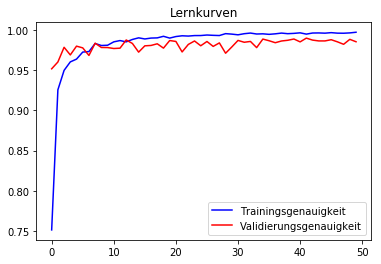

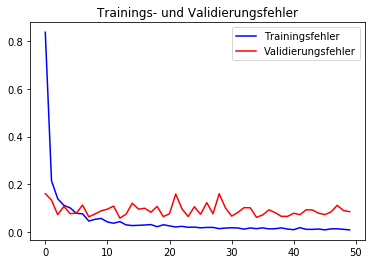

Klassifikationsreport ausgeben
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.99      1.00       720
           2       0.98      1.00      0.99       750
           3       1.00      0.97      0.98       450
           4       1.00      1.00      1.00       660
           5       0.98      0.98      0.98       630
           6       1.00      0.79      0.88       150
           7       1.00      0.99      0.99       450
           8       1.00      0.96      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.97      1.00      0.98       420
          12       0.98      0.97      0.97       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.90      1.00      0.95       210
          16       0.97      1.00      0.98       

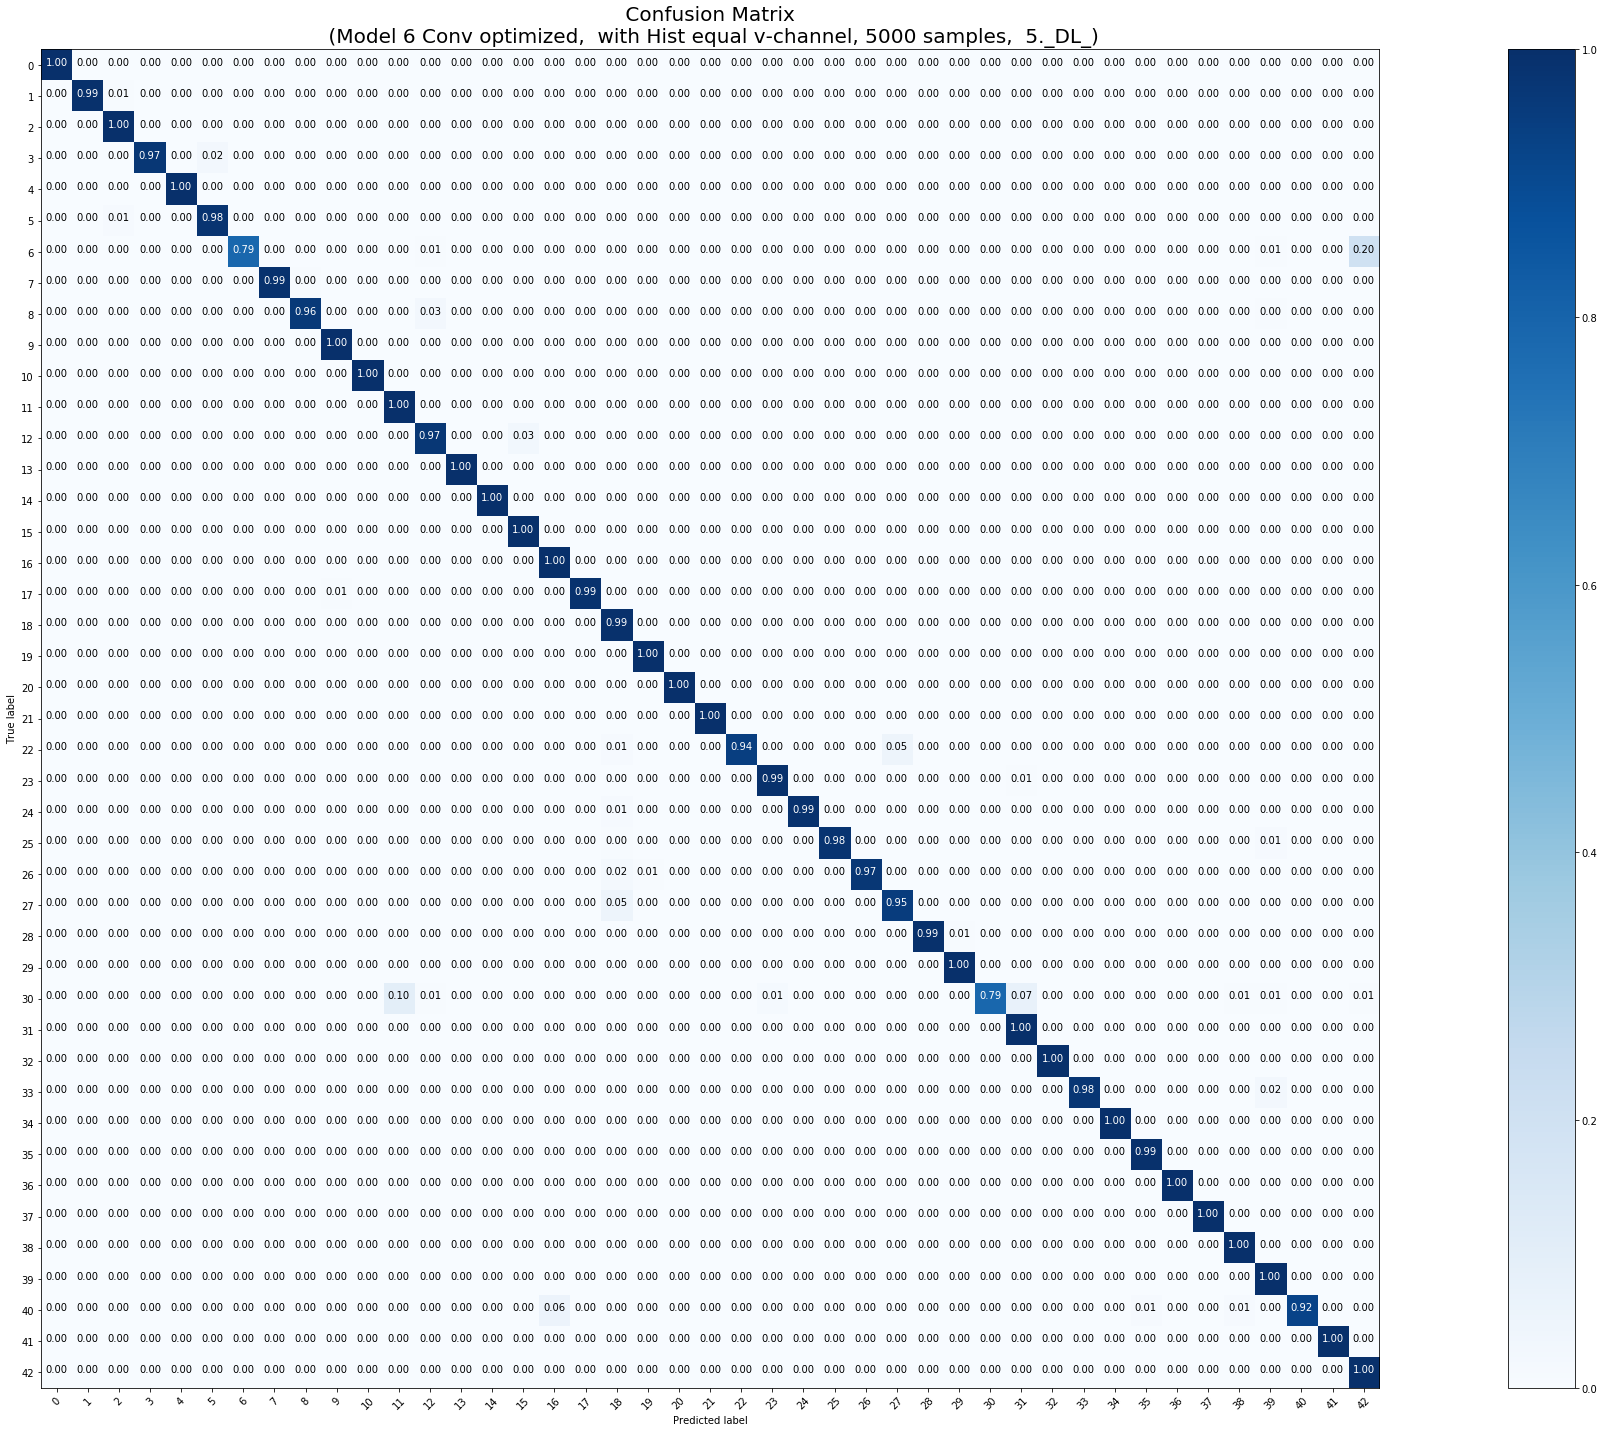

<Figure size 432x288 with 0 Axes>

In [17]:
# Trainingsmenge 5000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_5000, y_tr_5000, X_test, y_test, 0.2, 0.001, False, 5000)

In [0]:
downloader(1,5,5000)

In [0]:
# Trainingsmenge 10000
# Parameter: Dropoutrate = 0.2, Lernrate = 0.001, ohne SpatialDropout
fullDataRuns(1, 5, X_tr_10000, y_tr_10000, X_test, y_test, 0.2, 0.001, False, 10000)

In [0]:
downloader(1,5,10000)